# 1. Business Problem Statement

The Kaggle dataset represents a **general e-commerce retail model**, where churn means customers became inactive.  
In retail e-commerce, annual churn rates of **60–80%** are common ([Ecommerce Fastlane](https://ecommercefastlane.com/ecommerce-churn-rates-measure-and-reduce-lost-customers-and-revenue/?utm_source=chatgpt.com); [Sobot.io](https://www.sobot.io/article/average-churn-rate-for-ecommerce-stores-trends-2024-2025/?utm_source=chatgpt.com)).  

For this project, we **assume the dataset reflects one month of customer activity**. Under this assumption, the ~16% churn rate is far above healthy monthly benchmarks of **5–10%** seen in subscription-style e-commerce ([ScaleMath](https://scalemath.com/blog/what-is-a-good-monthly-churn-rate/?utm_source=chatgpt.com); [Opensend](https://www.opensend.com/post/churn-rate-ecommerce?utm_source=chatgpt.com)).  
This makes churn reduction a **serious business problem** and a strong candidate for predictive modeling and retention strategies.

## Evaluation Metrics

For this churn dataset, the following evaluation setup will be used:

1. **Main Metric → F2-Score**  
   - Prioritizes Recall 4× more than Precision, reflecting the fact that **acquiring a new customer is 5–25× more expensive than retaining an existing one** ([Harvard Business Review, 2014](https://hbr.org/2014/10/the-value-of-keeping-the-right-customers?utm_source=chatgpt.com)).  
   - This makes missing churners (false negatives) far more costly than mistakenly targeting loyal customers (false positives).  
   - Supported by churn prediction literature, where Recall-oriented metrics (e.g., F2) are recommended for imbalanced datasets ([Verbeke et al., 2012](https://doi.org/10.1016/j.dss.2012.05.005)).  

2. **Supporting Metric → ROC-AUC**  
   - Evaluates model discriminative power independent of thresholds.  
   - Widely used in churn research as a benchmark for classification quality.  

3. **Supporting Tool → Classification Report**  
   - Reports Precision, Recall, and F1-score for each class.  
   - Provides transparency into trade-offs, allowing business stakeholders to see exactly how many churners are caught versus how many loyal customers are misclassified.  

4. **Additional Supporting Metrics → F3-Score and F4-Score**  
   - Both further **increase the weight of Recall relative to Precision**.  
   - **F3-Score**: Recall is weighted 9× higher than Precision.  
   - **F4-Score**: Recall is weighted 16× higher than Precision.  
   - Useful for **stress-testing models** under extreme Recall-oriented scenarios, ensuring robustness when the business prioritizes catching nearly all churners at the expense of more false positives.  

**Summary:**  
- **F2-Score** will be the headline evaluation metric.  
- **ROC-AUC** provides a threshold-independent comparison across models.  
- **Classification Report** ensures interpretability and business clarity.  
- **F3 and F4-Scores** serve as additional recall-heavy metrics for sensitivity analysis.  

# 2. Data Understanding

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Load the datasets
file_path = 'E Commerce Dataset.xlsx'
df_ecommerce = pd.read_excel(file_path, sheet_name='E Comm')
df_dict = pd.read_excel(file_path, sheet_name='Data Dict')

print("Feature Descriptions:")
display(df_dict)

print("\nE-commerce Data Head:")
display(df_ecommerce.head())

Feature Descriptions:


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,NaN,Data,Variable,Discerption
1,NaN,E Comm,CustomerID,Unique customer ID
2,NaN,E Comm,Churn,Churn Flag
3,NaN,E Comm,Tenure,Tenure of customer in organization
4,NaN,E Comm,PreferredLoginDevice,Preferred login device of customer
5,NaN,E Comm,CityTier,City tier
6,NaN,E Comm,WarehouseToHome,Distance in between warehouse to home of customer
7,NaN,E Comm,PreferredPaymentMode,Preferred payment method of customer
8,NaN,E Comm,Gender,Gender of customer
9,NaN,E Comm,HourSpendOnApp,Number of hours spend on mobile application or...



E-commerce Data Head:


,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [41]:
# Check data types and look for missing values
print("Data Info:")
df_ecommerce.info()

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberO

## 2. Initial Reconnaissance

### 2.1. `CustomerID` as Index

In [42]:
df_ecommerce.set_index('CustomerID', inplace=True)

### 2.2. Data Types Correction

In [43]:
# Discrete numbers
df_ecommerce = df_ecommerce.astype({
    "Churn": "Int8",
    "Tenure": "Int64",
    "CityTier": "Int8",
    "NumberOfDeviceRegistered": "Int8",
    "SatisfactionScore": "Int8",
    "NumberOfAddress": "Int8",
    "Complain": "Int8", # 0 (No) and 1 (Yes) only (categorical) -> keep as Int8 for skipping conversion to bool
    "CouponUsed": "Int64",
    "OrderCount": "Int64",
    "DaySinceLastOrder": "Int64",
})

# Convert categoricals
categorical_cols = [
    "PreferredLoginDevice", "PreferredPaymentMode",
    "Gender", "PreferedOrderCat", "MaritalStatus"
]
# df_ecommerce[categorical_cols] = df_ecommerce[categorical_cols].astype("category")
df_ecommerce.info()


<class 'pandas.core.frame.DataFrame'>
Index: 5630 entries, 50001 to 55630
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Churn                        5630 non-null   Int8   
 1   Tenure                       5366 non-null   Int64  
 2   PreferredLoginDevice         5630 non-null   object 
 3   CityTier                     5630 non-null   Int8   
 4   WarehouseToHome              5379 non-null   float64
 5   PreferredPaymentMode         5630 non-null   object 
 6   Gender                       5630 non-null   object 
 7   HourSpendOnApp               5375 non-null   float64
 8   NumberOfDeviceRegistered     5630 non-null   Int8   
 9   PreferedOrderCat             5630 non-null   object 
 10  SatisfactionScore            5630 non-null   Int8   
 11  MaritalStatus                5630 non-null   object 
 12  NumberOfAddress              5630 non-null   Int8   
 13  Complain          

In [44]:
df_ecommerce.head()

,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
CustomerID,,,,,,,,,,,,,,,,,,,
50001,1,4,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1,1,5,159.93
50002,1,<NA>,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0,1,0,120.90
50003,1,<NA>,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0,1,3,120.28
50004,1,0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0,1,3,134.07
50005,1,0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1,1,3,129.60


# 3. Exploratory Data Analysis (EDA) on Customer Churn

## 3.3. Descriptive Dive

In [45]:
# Calculate key statistics
print("Descriptive Statistics:")
display(df_ecommerce.describe())

Descriptive Statistics:


,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,5630.0,5366.0,5630.0,5379.000000,5375.000000,5630.0,5630.0,5630.0,5630.0,5365.000000,5374.0,5372.0,5323.0,5630.000000
mean,0.168384,10.189899,1.654707,15.639896,2.931535,3.688988,3.066785,4.214032,0.284902,15.707922,1.751023,3.008004,4.543491,177.223030
std,0.37424,8.557241,0.915389,8.531475,0.721926,1.023999,1.380194,2.583586,0.451408,3.675485,1.894621,2.93968,3.654433,49.207036
min,0.0,0.0,1.0,5.000000,0.000000,1.0,1.0,1.0,0.0,11.000000,0.0,1.0,0.0,0.000000
25%,0.0,2.0,1.0,9.000000,2.000000,3.0,2.0,2.0,0.0,13.000000,1.0,1.0,2.0,145.770000
50%,0.0,9.0,1.0,14.000000,3.000000,4.0,3.0,3.0,0.0,15.000000,1.0,2.0,3.0,163.280000
75%,0.0,16.0,3.0,20.000000,3.000000,4.0,4.0,6.0,1.0,18.000000,2.0,3.0,7.0,196.392500
max,1.0,61.0,3.0,127.000000,5.000000,6.0,5.0,22.0,1.0,26.000000,16.0,16.0,46.0,324.990000


## 3.4. Inconsistency Handling

In [46]:
# Standardize payment mode values
df_ecommerce['PreferredPaymentMode'] = df_ecommerce['PreferredPaymentMode'].replace({'CC': 'Credit Card', 'COD': 'Cash on Delivery'})

# Standardize login device
df_ecommerce['PreferredLoginDevice'] = df_ecommerce['PreferredLoginDevice'].replace({'Phone': 'Mobile Phone'})

# Standardize order category
df_ecommerce['PreferedOrderCat'] = df_ecommerce['PreferedOrderCat'].replace({'Mobile': 'Mobile Phone'})

print("Cleaned Data Checks:")
print('Unique Payment Modes:', df_ecommerce['PreferredPaymentMode'].unique())
print('Unique Login Devices:', df_ecommerce['PreferredLoginDevice'].unique())
print('Unique Order Categories:', df_ecommerce['PreferedOrderCat'].unique())
print('Max WarehouseToHome:', df_ecommerce['WarehouseToHome'].max())

Cleaned Data Checks:
Unique Payment Modes: ['Debit Card' 'UPI' 'Credit Card' 'Cash on Delivery' 'E wallet']
Unique Login Devices: ['Mobile Phone' 'Computer']
Unique Order Categories: ['Laptop & Accessory' 'Mobile Phone' 'Others' 'Fashion' 'Grocery']
Max WarehouseToHome: 127.0


## 3.5. In-Depth Numerical Analysis

### 3.5.1. Univariate Numerical Analysis

Analyzing Numerical Feature: Tenure


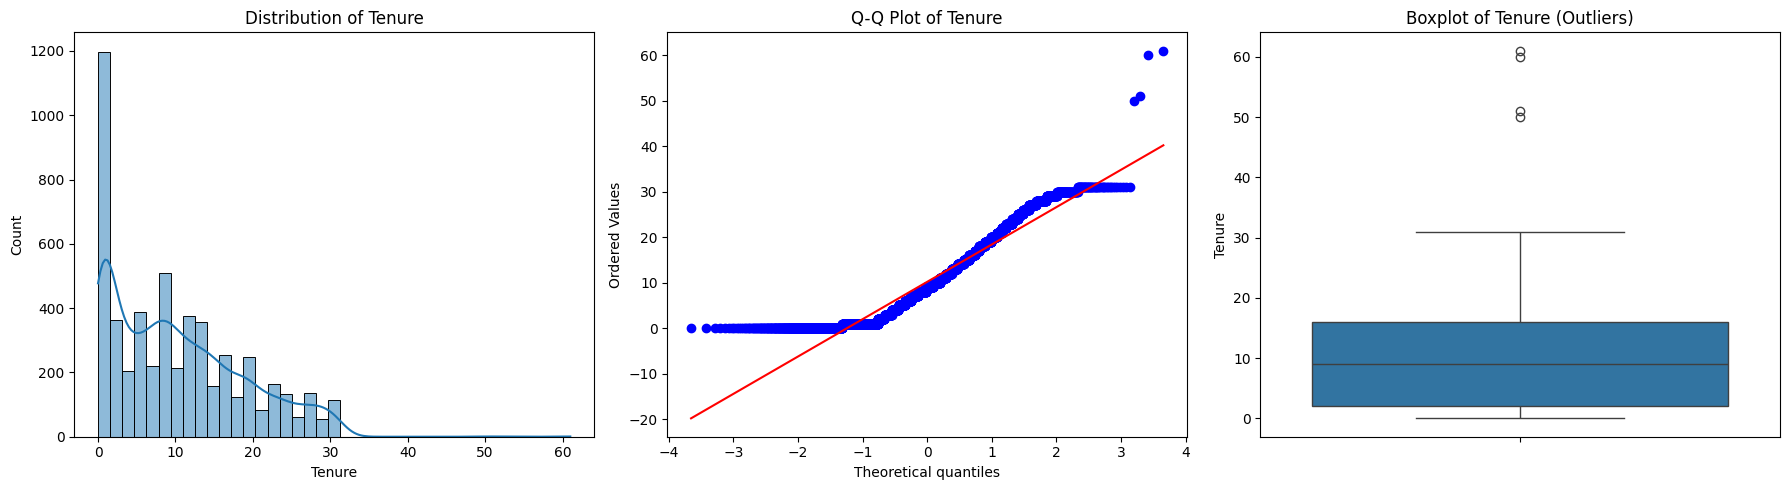

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5366.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk Test for Tenure: Statistics=0.920, p-value=0.000
Conclusion: Sample does not look Gaussian (reject H0).

--------------------------------------------------

Analyzing Numerical Feature: WarehouseToHome


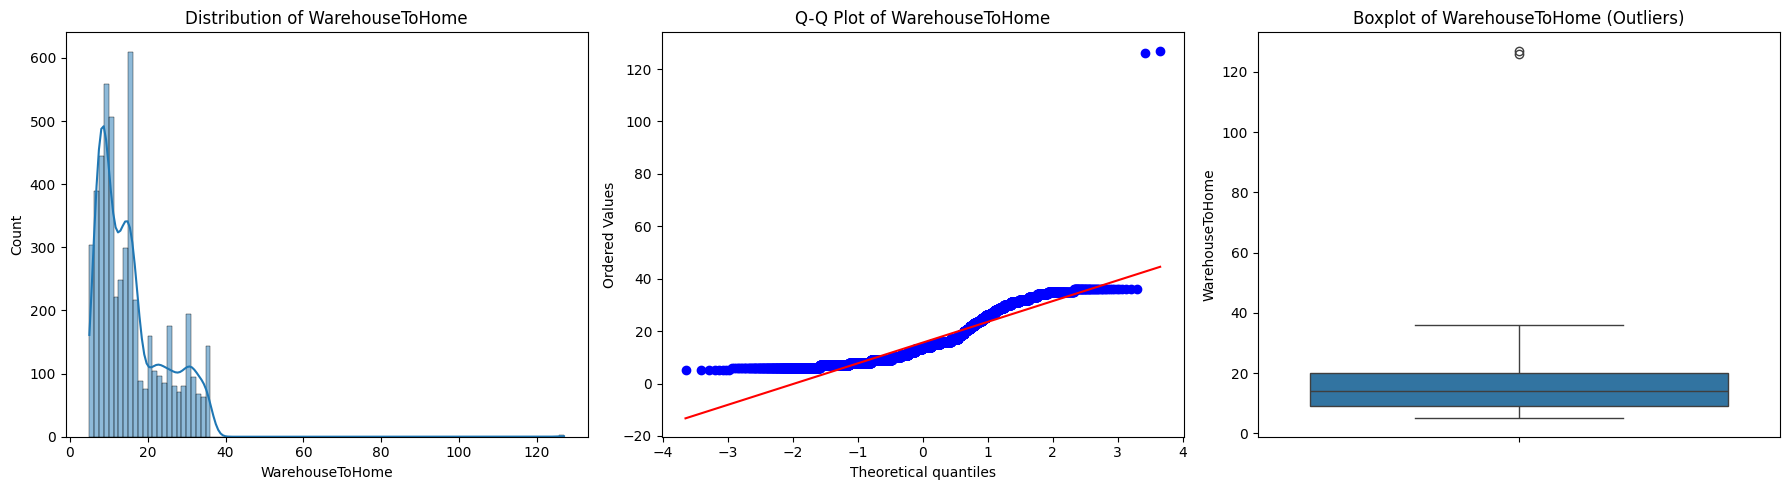

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5379.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk Test for WarehouseToHome: Statistics=0.860, p-value=0.000
Conclusion: Sample does not look Gaussian (reject H0).

--------------------------------------------------

Analyzing Numerical Feature: HourSpendOnApp


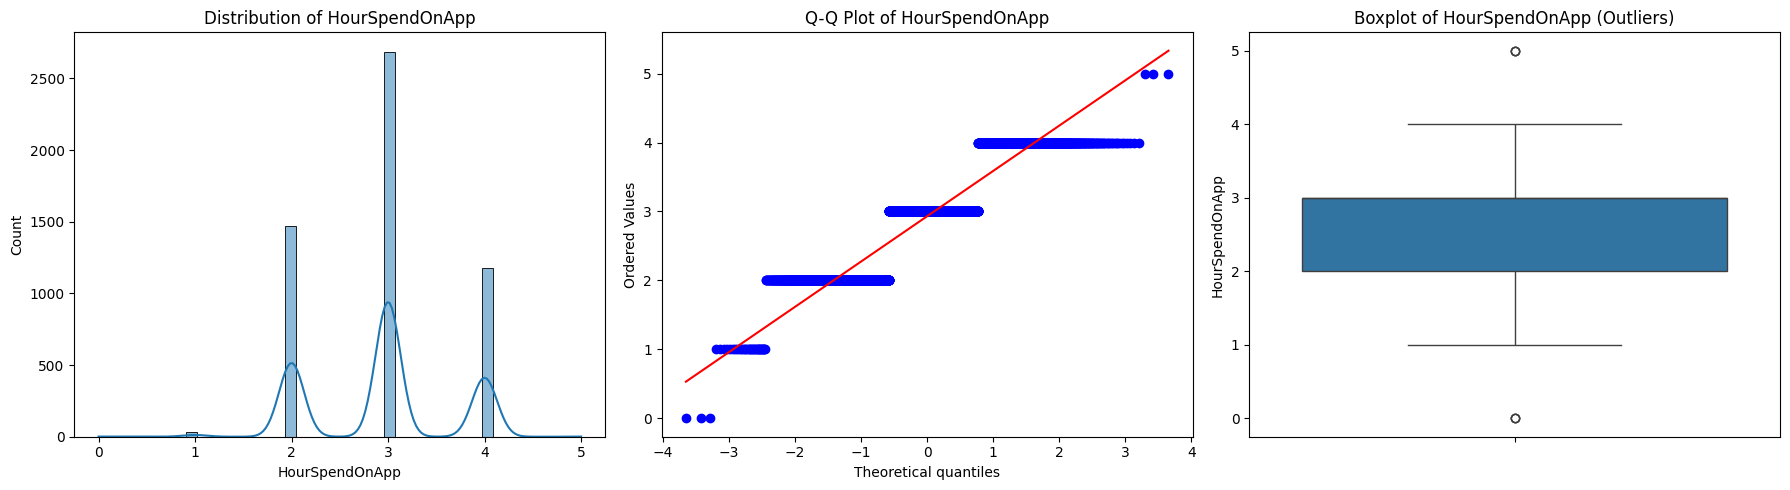

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5375.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk Test for HourSpendOnApp: Statistics=0.827, p-value=0.000
Conclusion: Sample does not look Gaussian (reject H0).

--------------------------------------------------

Analyzing Numerical Feature: NumberOfDeviceRegistered


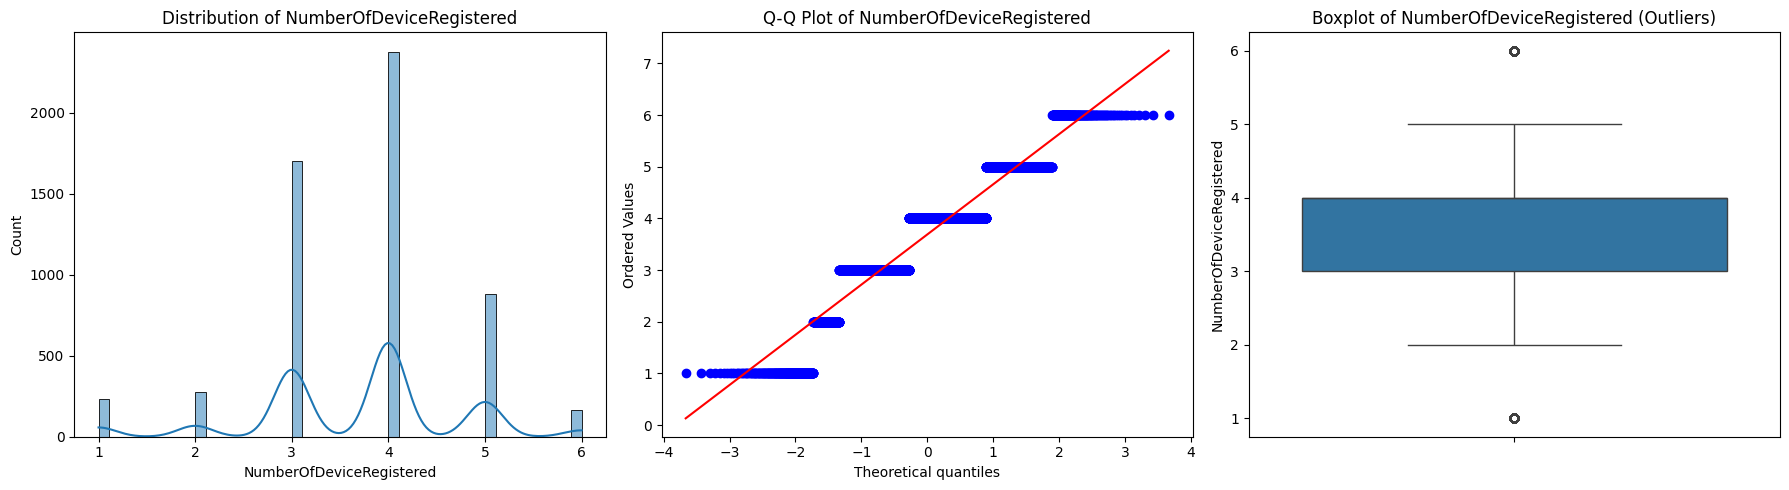

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5630.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk Test for NumberOfDeviceRegistered: Statistics=0.897, p-value=0.000
Conclusion: Sample does not look Gaussian (reject H0).

--------------------------------------------------

Analyzing Numerical Feature: NumberOfAddress


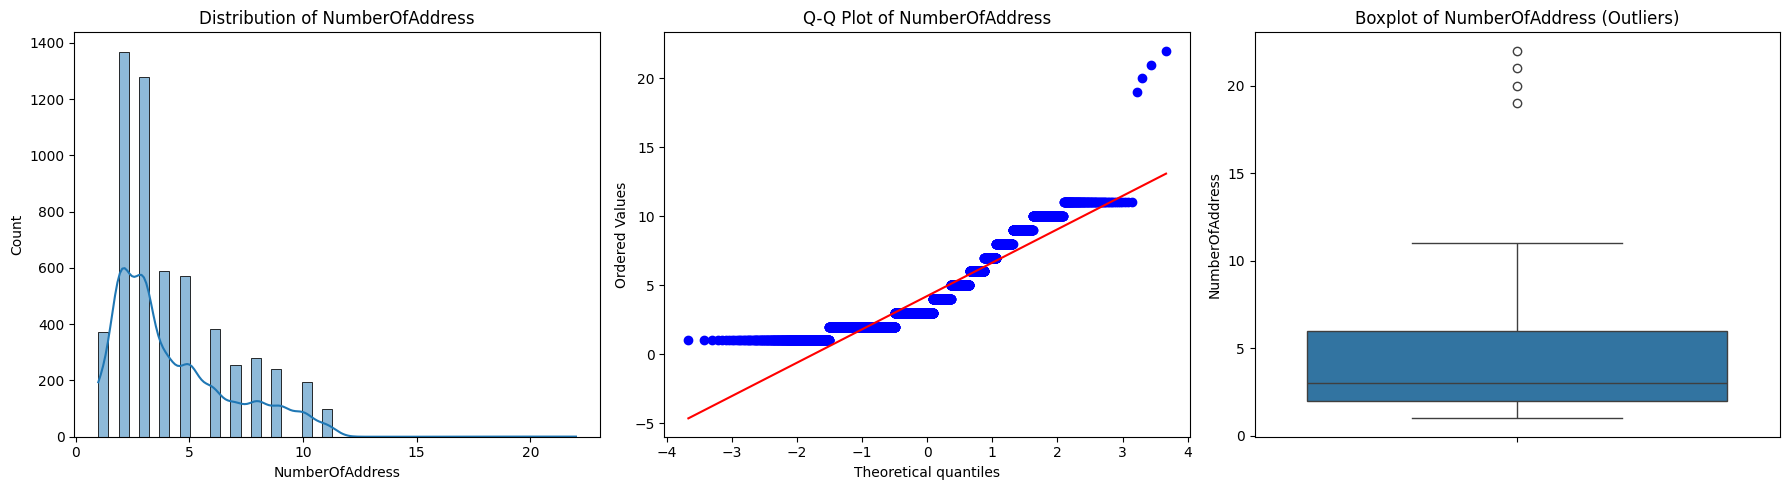

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5630.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk Test for NumberOfAddress: Statistics=0.877, p-value=0.000
Conclusion: Sample does not look Gaussian (reject H0).

--------------------------------------------------

Analyzing Numerical Feature: OrderAmountHikeFromlastYear


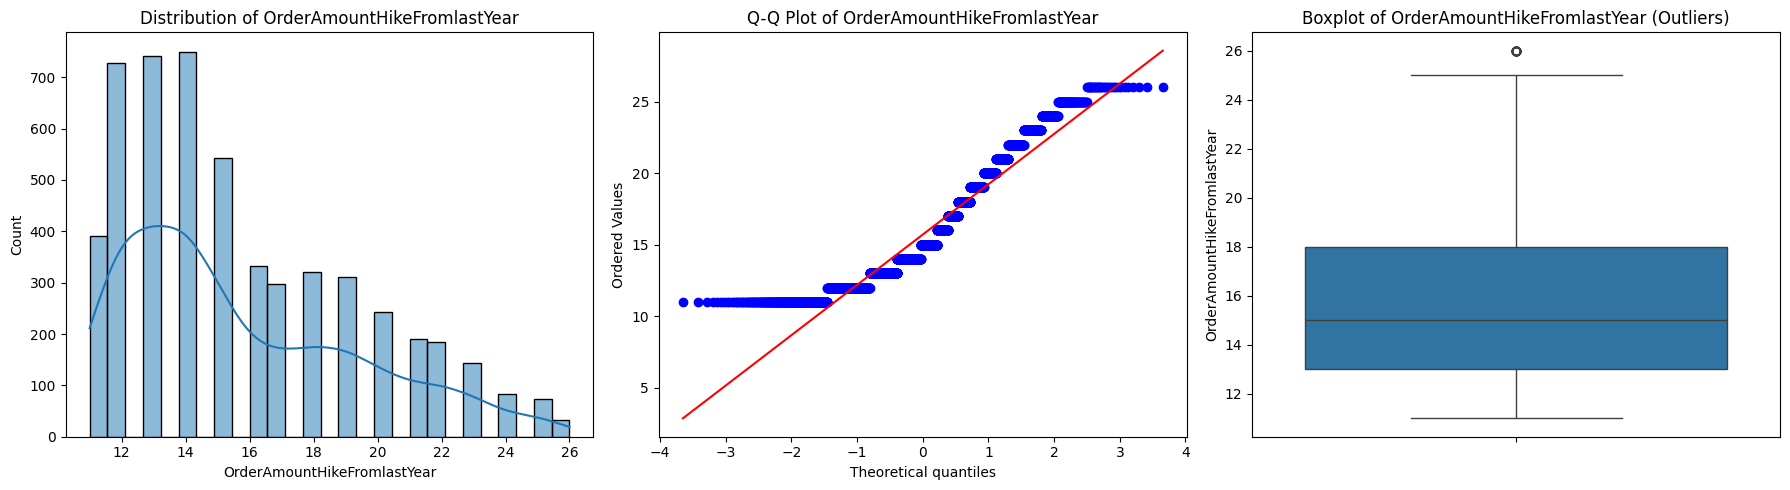

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5365.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk Test for OrderAmountHikeFromlastYear: Statistics=0.915, p-value=0.000
Conclusion: Sample does not look Gaussian (reject H0).

--------------------------------------------------

Analyzing Numerical Feature: CouponUsed


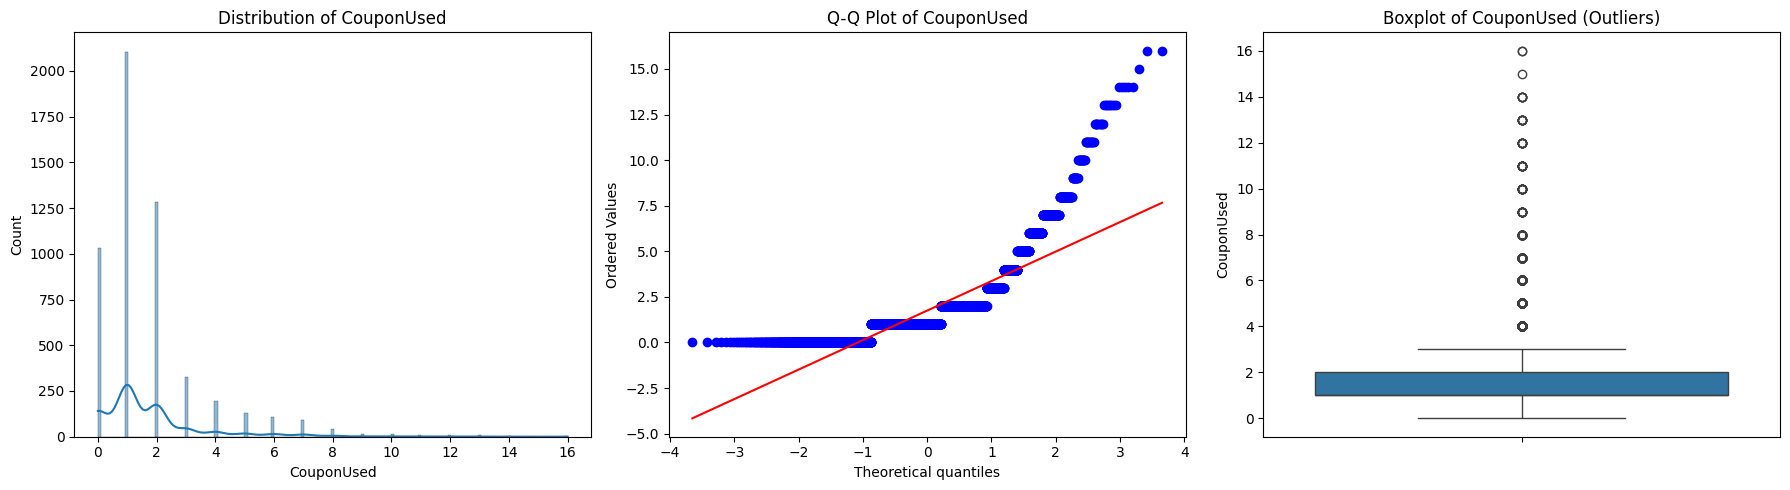

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5374.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk Test for CouponUsed: Statistics=0.728, p-value=0.000
Conclusion: Sample does not look Gaussian (reject H0).

--------------------------------------------------

Analyzing Numerical Feature: OrderCount


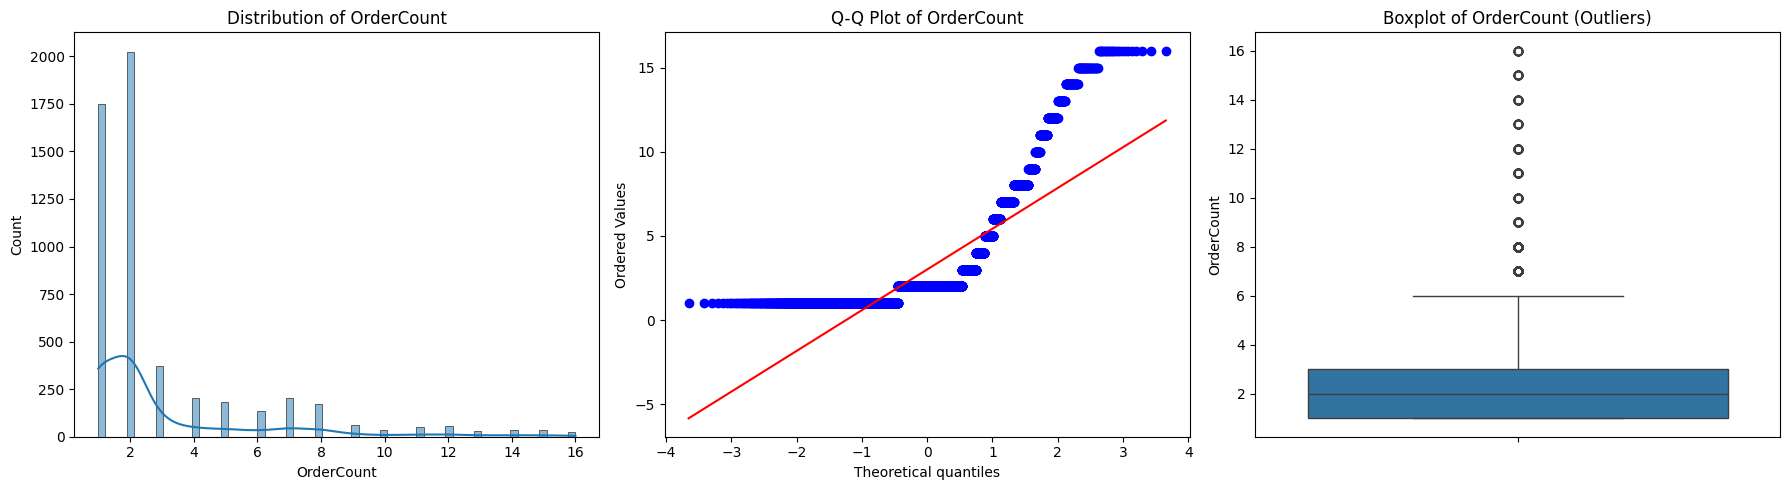

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5372.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk Test for OrderCount: Statistics=0.677, p-value=0.000
Conclusion: Sample does not look Gaussian (reject H0).

--------------------------------------------------

Analyzing Numerical Feature: DaySinceLastOrder


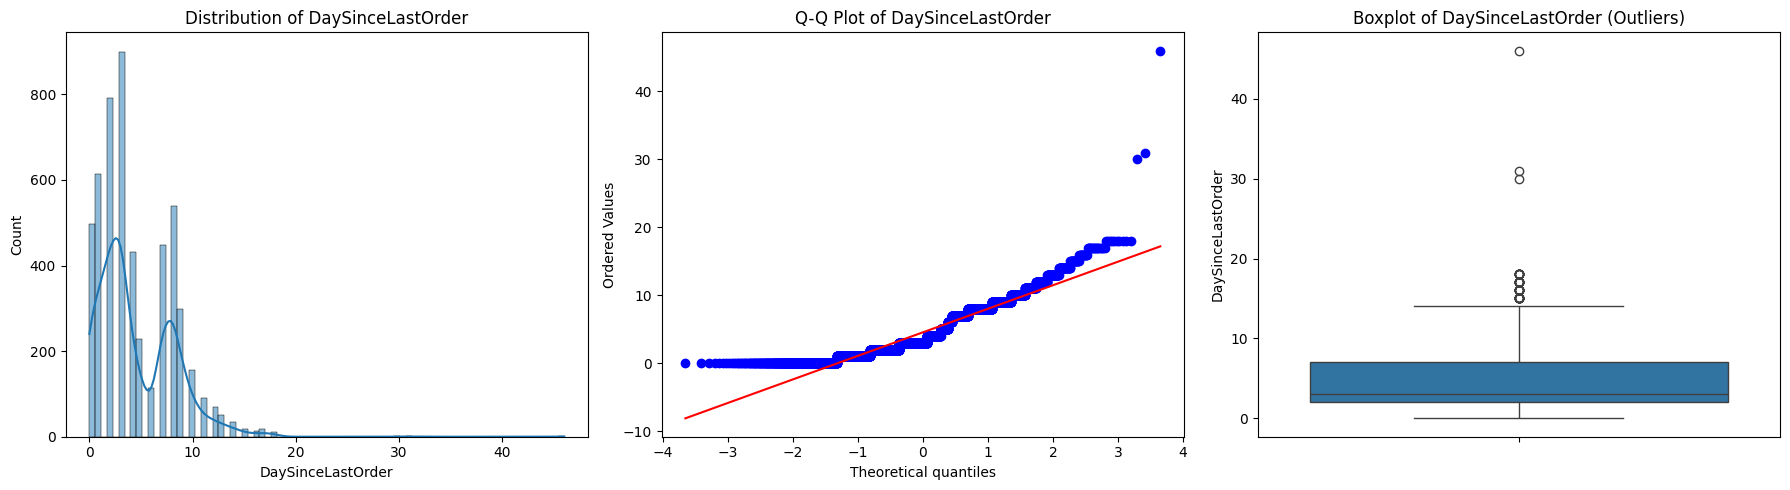

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5323.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk Test for DaySinceLastOrder: Statistics=0.899, p-value=0.000
Conclusion: Sample does not look Gaussian (reject H0).

--------------------------------------------------

Analyzing Numerical Feature: CashbackAmount


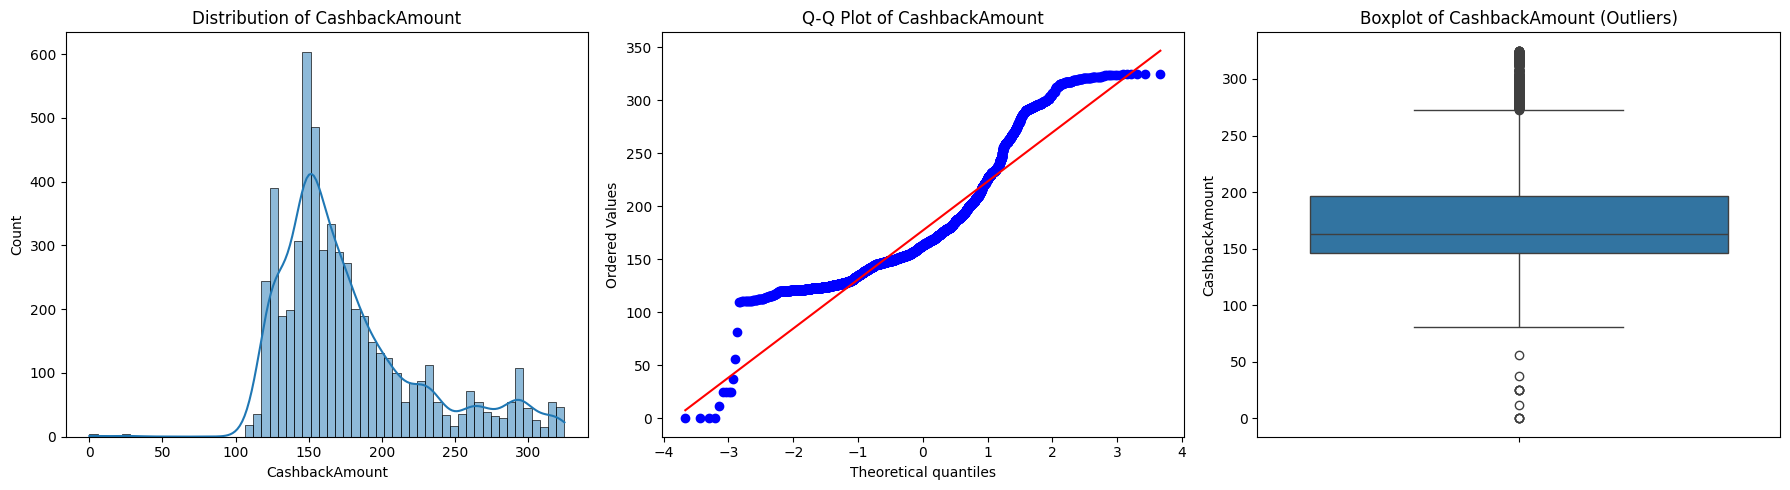

Shapiro-Wilk Test for CashbackAmount: Statistics=0.883, p-value=0.000
Conclusion: Sample does not look Gaussian (reject H0).

--------------------------------------------------



/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5630.
  res = hypotest_fun_out(*samples, **kwds)


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming your DataFrame is named 'df_ecommerce'.
# Make sure to load your data into this DataFrame before running the code.
# Example: df_ecommerce = pd.read_csv('your_data_file.csv')

numerical_features = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'NumberOfAddress', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']

for col in numerical_features:
    print(f'Analyzing Numerical Feature: {col}')
    
    # Distribution, Normality, and Outlier Check
    plt.figure(figsize=(18, 5)) # Increased figure size to accommodate 3 plots
    
    # Histogram
    plt.subplot(1, 3, 1) # Changed to 1 row, 3 columns
    sns.histplot(df_ecommerce[col], kde=True)
    plt.title(f'Distribution of {col}')
    
    # Q-Q Plot
    plt.subplot(1, 3, 2) # Changed to 1 row, 3 columns
    stats.probplot(df_ecommerce[col].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {col}')

    # Boxplot for Outliers
    plt.subplot(1, 3, 3) # Added a third subplot
    sns.boxplot(y=df_ecommerce[col])
    plt.title(f'Boxplot of {col} (Outliers)')
    
    plt.tight_layout()
    plt.show() # Display the plot directly
    
    # Shapiro-Wilk Test
    stat, p = stats.shapiro(df_ecommerce[col].dropna())
    print(f'Shapiro-Wilk Test for {col}: Statistics={stat:.3f}, p-value={p:.3f}')
    
    if p > 0.05:
        print('Conclusion: Sample looks Gaussian (fail to reject H0).')
        normality = True
    else:
        print('Conclusion: Sample does not look Gaussian (reject H0).')
        normality = False
    
    print('\n' + '-'*50 + '\n')

**Based on the provided charts, here are the key insights for each variable:**

#### Days Since Last Order
The data is heavily **right-skewed**, indicating that most customers placed an order very recently. The majority of customers last ordered within the first 10 days. The Q-Q plot shows a clear departure from the normal distribution, confirming the skewness. The boxplot reveals numerous outliers, representing customers who haven't ordered in a long time.

---

#### Number of Devices Registered
The distribution is **multimodal**, with distinct peaks at 1, 3, 4, 5, and 6 devices. The most common number of devices is 4. The data is not normally distributed, as shown by the Q-Q plot and the distinct peaks in the histogram. The boxplot indicates a few outliers, with a registered device count of 1 and 6.

---

#### Tenure
The distribution of customer tenure is **right-skewed**, meaning most customers have a short tenure. The Q-Q plot shows a clear departure from the theoretical quantiles, confirming the non-normal distribution. The boxplot highlights several outliers, representing customers with a very long tenure.

---

#### Warehouse to Home Distance
This distribution is also **right-skewed**, with most customers living relatively close to the warehouse (less than 20 units of distance). The Q-Q plot indicates a non-normal distribution, with the points deviating significantly from the red line. The boxplot shows many outliers, representing customers who live a great distance from the warehouse.

---

#### Order Count
The data for order count is **heavily right-skewed**, with most customers having a low number of orders (1 or 2). As the order count increases, the frequency of customers drops sharply. The Q-Q plot and the boxplot with numerous outliers confirm this pattern.

---

#### Hours Spent on App
The distribution is **multimodal**, with clear peaks at 1, 2, 3, and 4 hours. The most common time spent on the app is 3 hours. The Q-Q plot shows that the data is not normally distributed. The boxplot shows outliers at 0 and 5 hours.

---

#### Order Amount Hike from Last Year
The distribution appears **slightly left-skewed**, with a peak around a 14% to 15% increase. The Q-Q plot shows a slight deviation from the normal distribution. The boxplot reveals a few outliers at the upper and lower ends of the range.

---

#### Coupons Used
The distribution of coupons used is **heavily right-skewed**, with a large majority of customers using 0 or 1 coupon. The number of customers drops dramatically as the number of coupons used increases. The Q-Q plot and the boxplot with many outliers confirm this extreme skewness.

---

#### Number of Addresses
The data is **heavily right-skewed**, with most customers having a small number of addresses (1 to 5). The frequency of customers decreases significantly as the number of addresses increases. The Q-Q plot and the boxplot with multiple outliers confirm the non-normal and skewed nature of the data.

---

#### Cashback Amount
The distribution of cashback amount is **bimodal**, with two peaks. This suggests that there might be two different groups of customers based on their cashback amount. The Q-Q plot confirms that the data is not normally distributed. The boxplot shows several outliers on both the high and low ends.

### 3.5.2. Bivariate Numerical Analysis

Analyzing Tenure by Churn


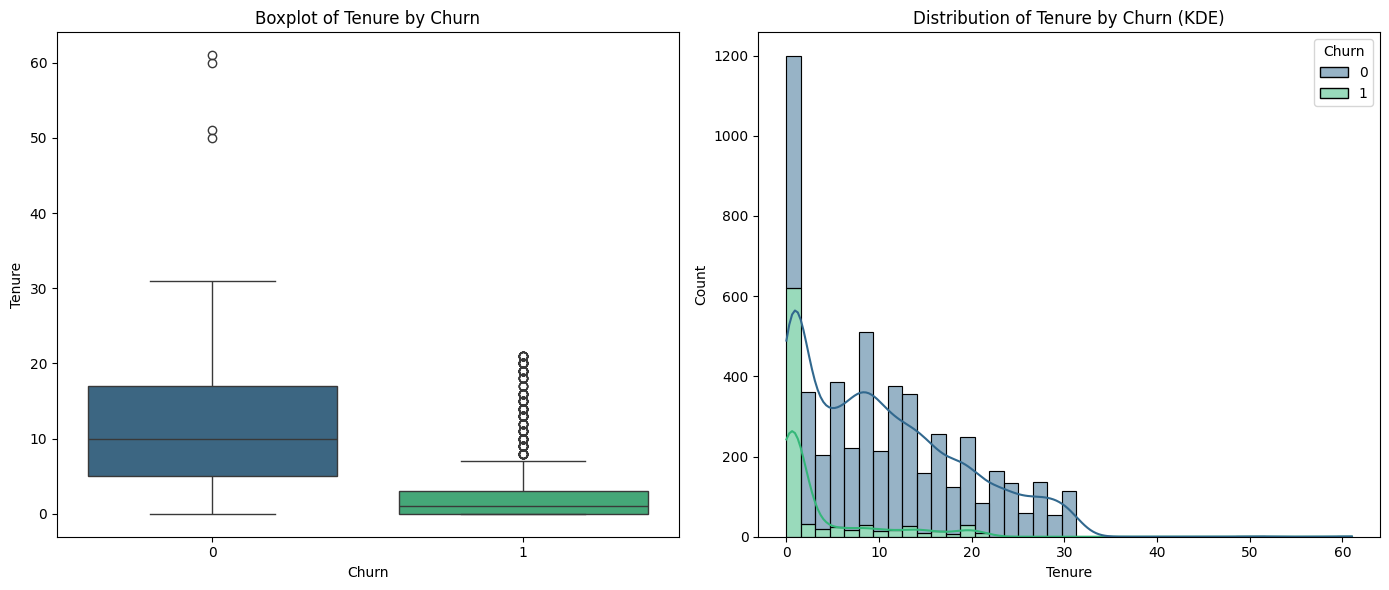

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5366.
  res = hypotest_fun_out(*samples, **kwds)


Mann-Whitney U test for Tenure: U-statistic=714994.000, p-value=0.000
Conclusion: There is a significant difference in distributions between churn groups.

--------------------------------------------------

Analyzing WarehouseToHome by Churn


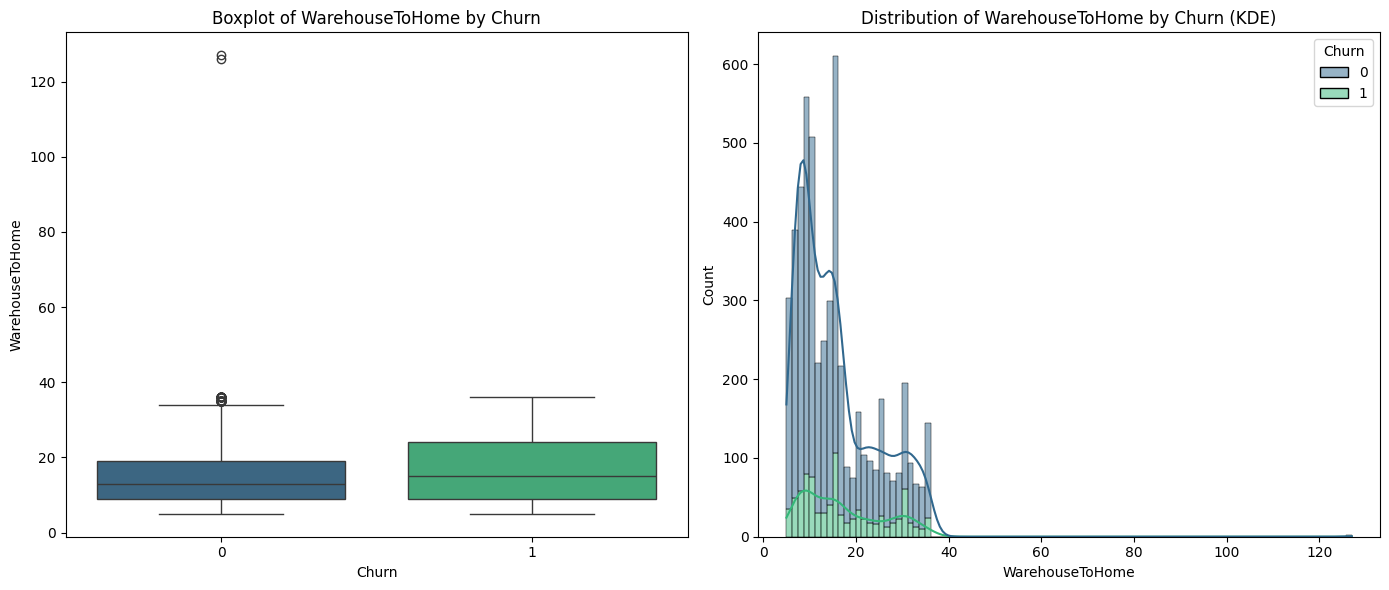

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5379.
  res = hypotest_fun_out(*samples, **kwds)


Mann-Whitney U test for WarehouseToHome: U-statistic=2198913.500, p-value=0.000
Conclusion: There is a significant difference in distributions between churn groups.

--------------------------------------------------

Analyzing HourSpendOnApp by Churn


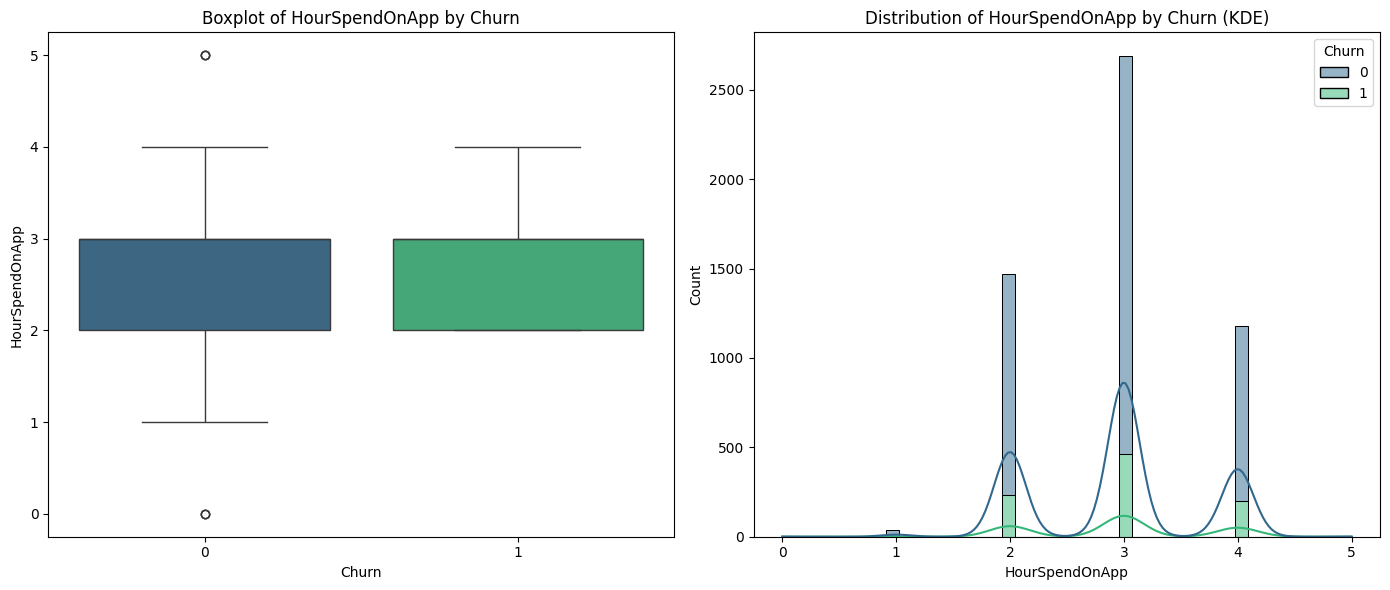

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5375.
  res = hypotest_fun_out(*samples, **kwds)


Mann-Whitney U test for HourSpendOnApp: U-statistic=2042784.000, p-value=0.227
Conclusion: There is no significant difference in distributions between churn groups.

--------------------------------------------------

Analyzing NumberOfDeviceRegistered by Churn


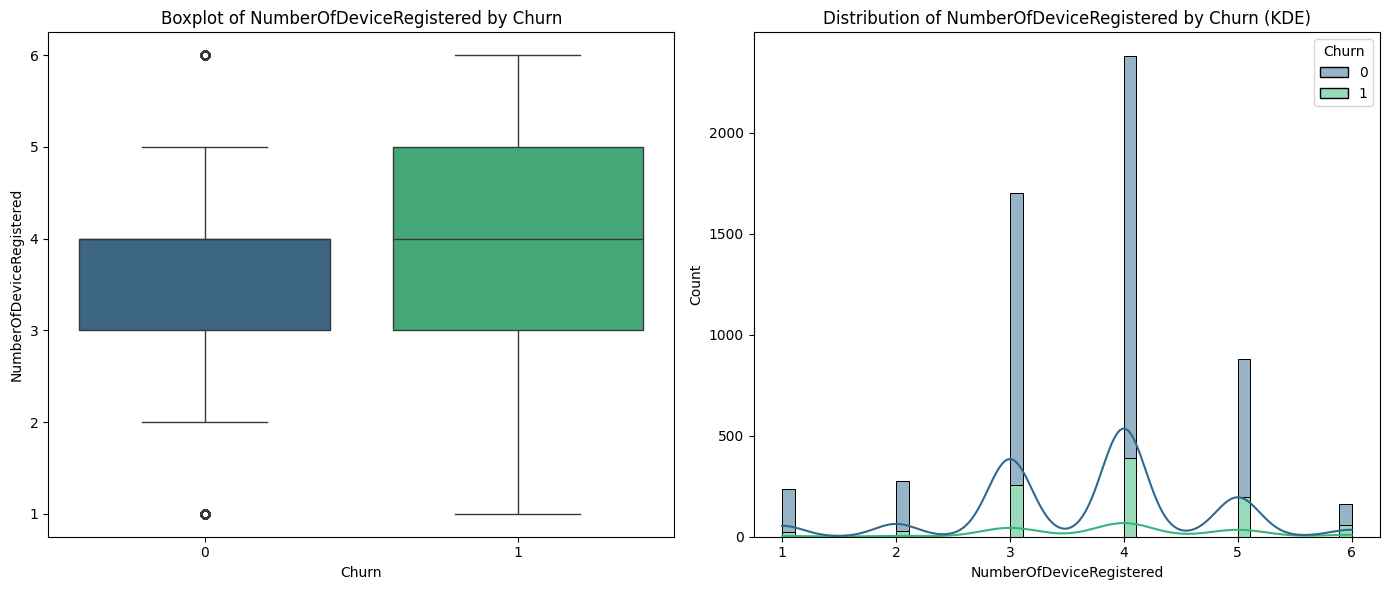

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5630.
  res = hypotest_fun_out(*samples, **kwds)


Mann-Whitney U test for NumberOfDeviceRegistered: U-statistic=2546899.000, p-value=0.000
Conclusion: There is a significant difference in distributions between churn groups.

--------------------------------------------------

Analyzing NumberOfAddress by Churn


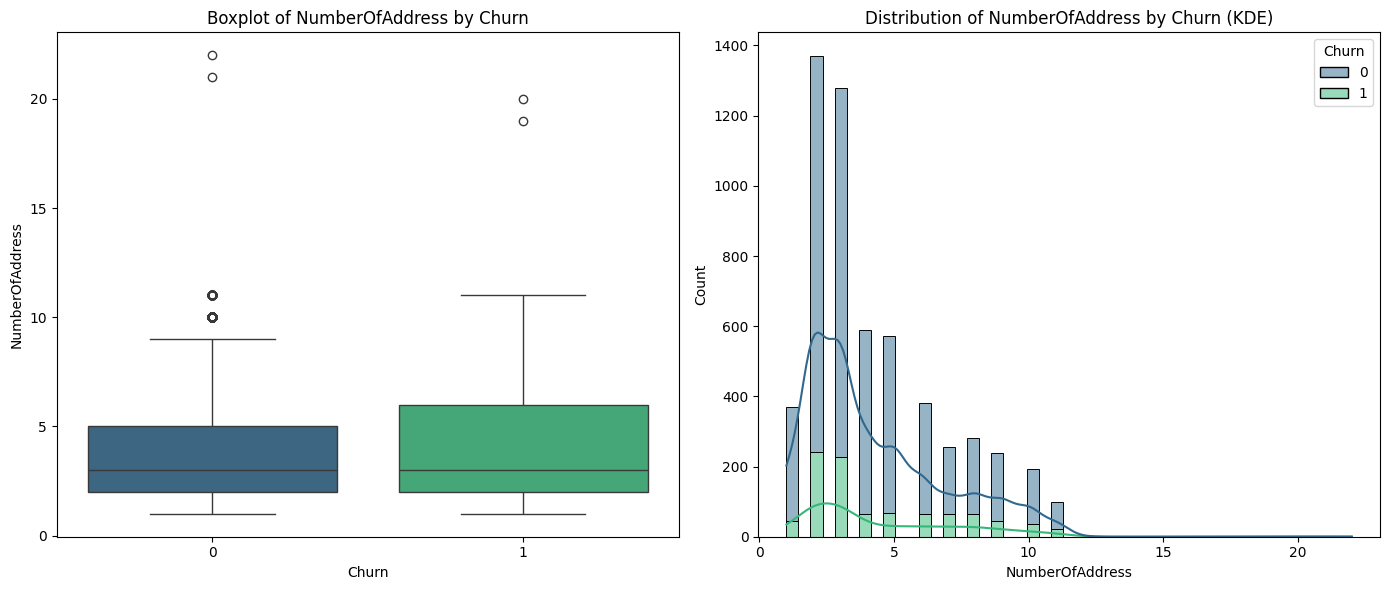

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5630.
  res = hypotest_fun_out(*samples, **kwds)


Mann-Whitney U test for NumberOfAddress: U-statistic=2316556.500, p-value=0.030
Conclusion: There is a significant difference in distributions between churn groups.

--------------------------------------------------

Analyzing OrderAmountHikeFromlastYear by Churn


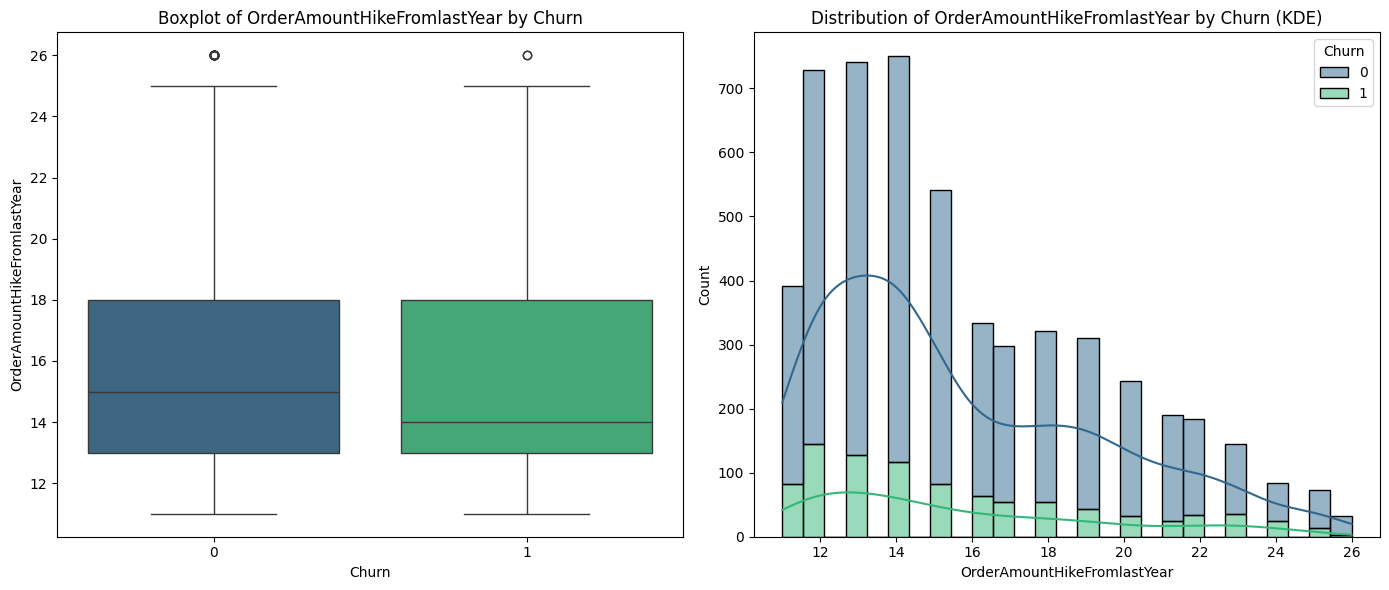

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5365.
  res = hypotest_fun_out(*samples, **kwds)


Mann-Whitney U test for OrderAmountHikeFromlastYear: U-statistic=2004453.000, p-value=0.130
Conclusion: There is no significant difference in distributions between churn groups.

--------------------------------------------------

Analyzing CouponUsed by Churn


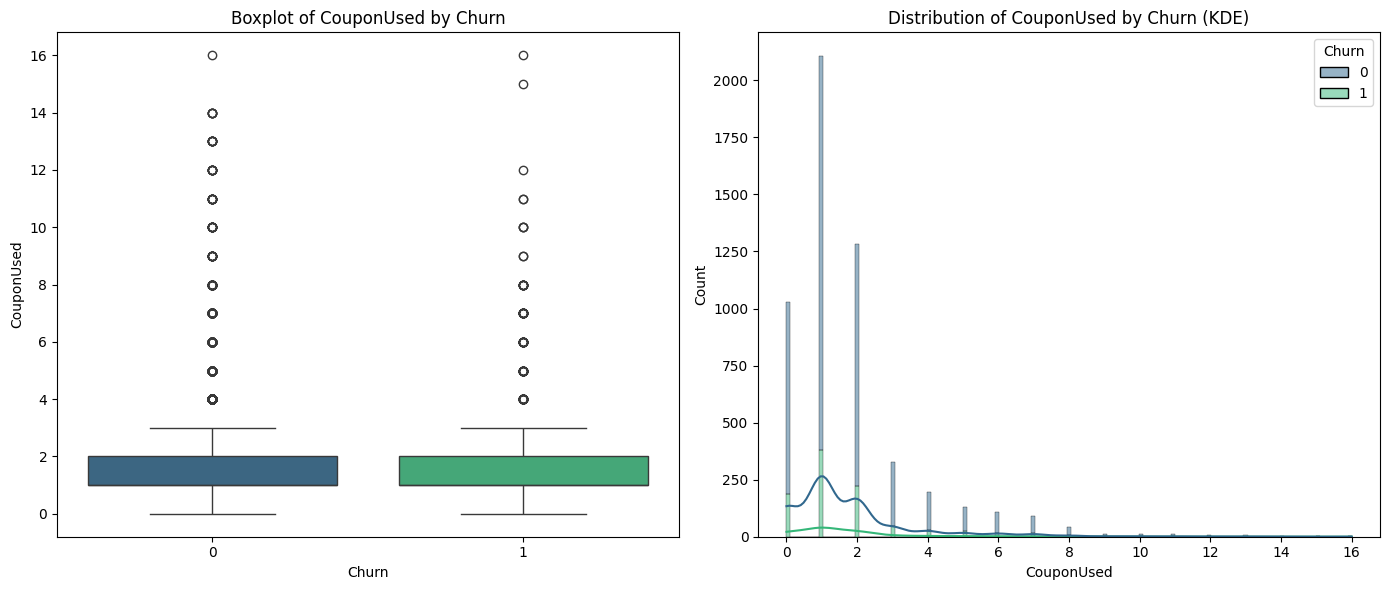

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5374.
  res = hypotest_fun_out(*samples, **kwds)


Mann-Whitney U test for CouponUsed: U-statistic=2038042.500, p-value=0.267
Conclusion: There is no significant difference in distributions between churn groups.

--------------------------------------------------

Analyzing OrderCount by Churn


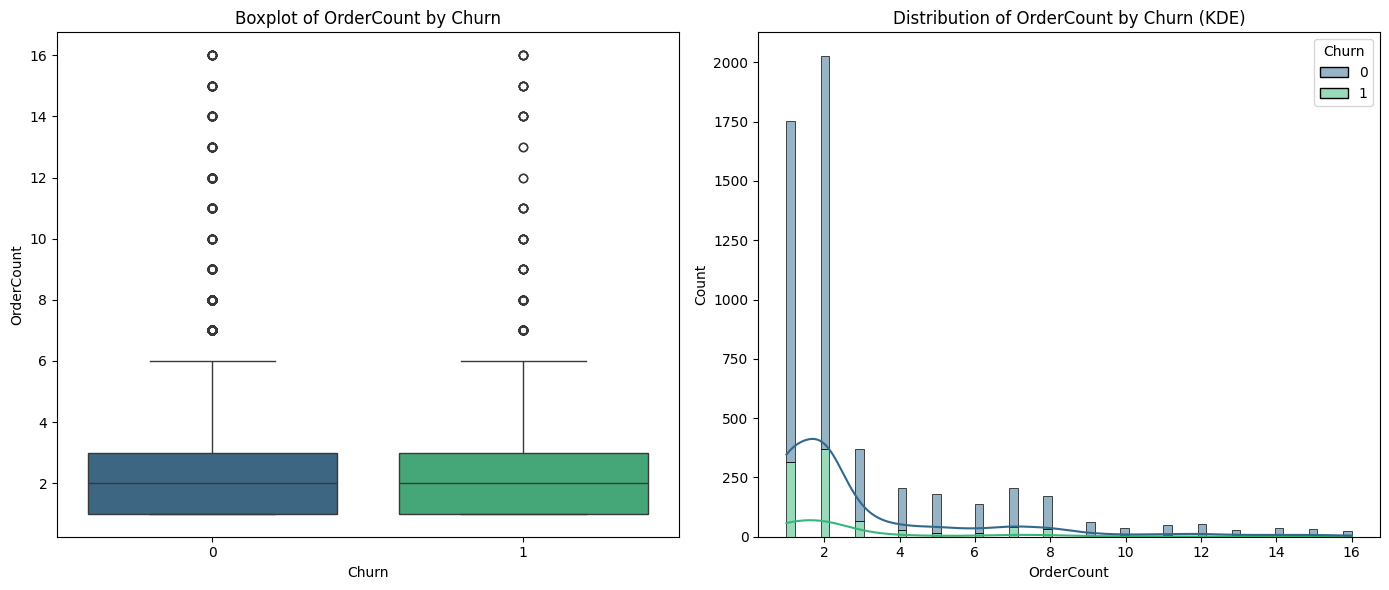

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5372.
  res = hypotest_fun_out(*samples, **kwds)


Mann-Whitney U test for OrderCount: U-statistic=1979607.000, p-value=0.036
Conclusion: There is a significant difference in distributions between churn groups.

--------------------------------------------------

Analyzing DaySinceLastOrder by Churn


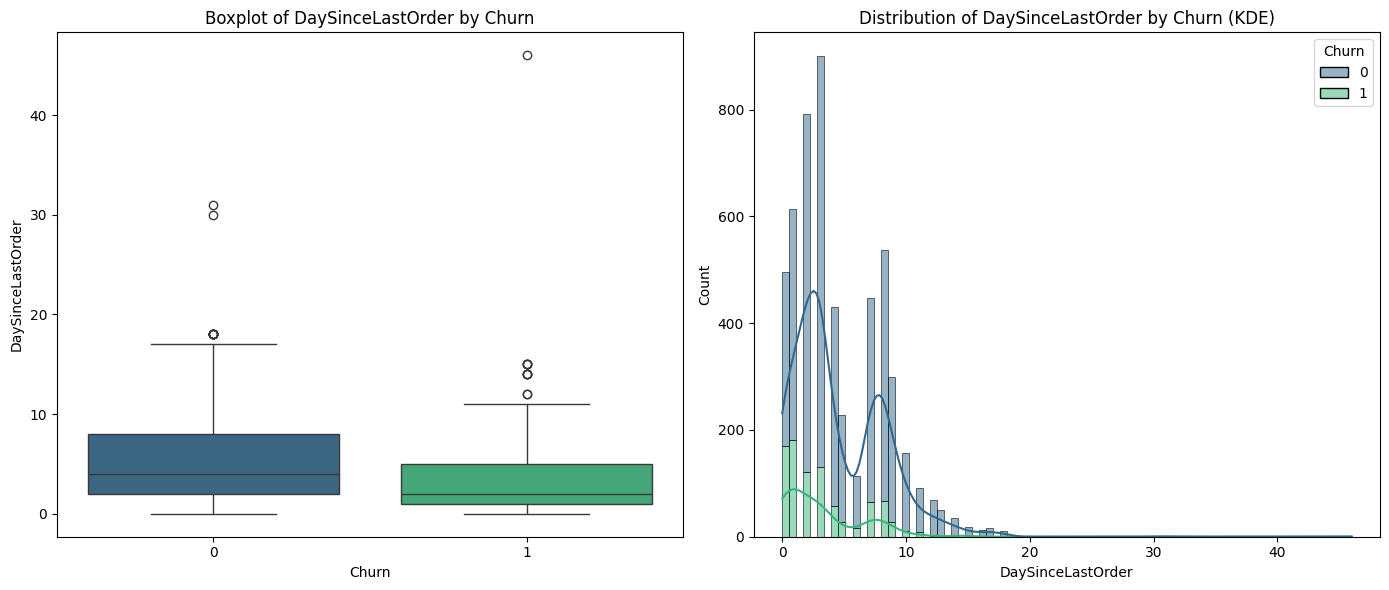

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5323.
  res = hypotest_fun_out(*samples, **kwds)


Mann-Whitney U test for DaySinceLastOrder: U-statistic=1412515.000, p-value=0.000
Conclusion: There is a significant difference in distributions between churn groups.

--------------------------------------------------

Analyzing CashbackAmount by Churn


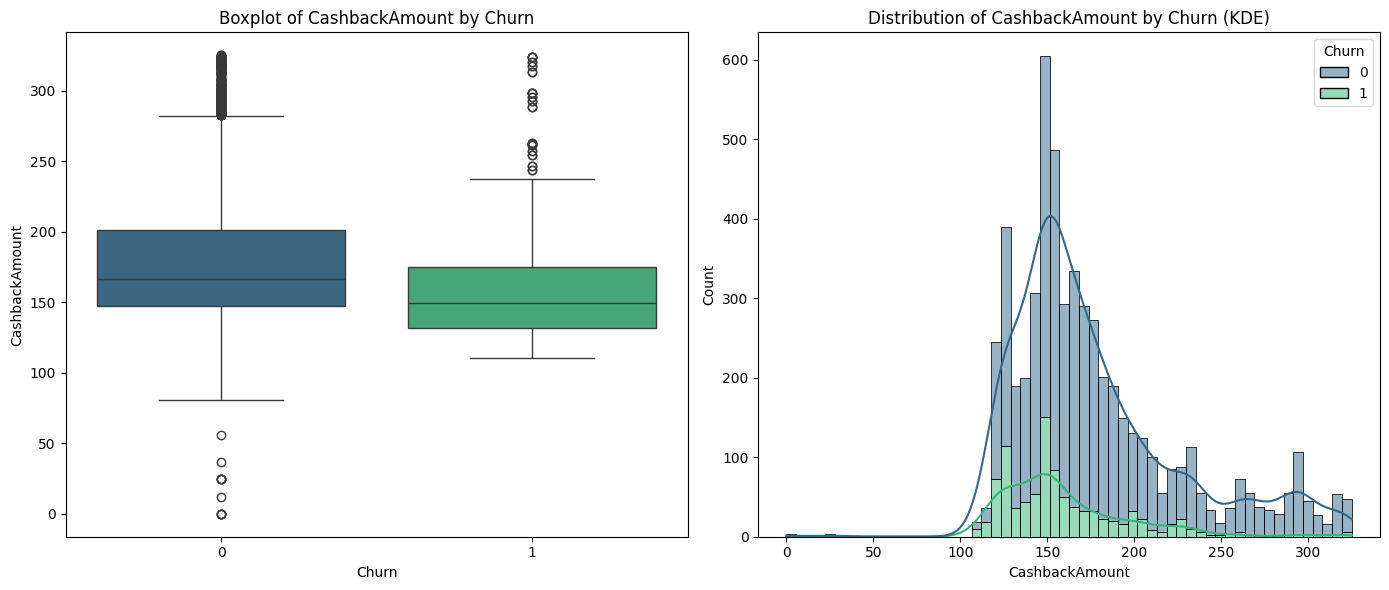

Mann-Whitney U test for CashbackAmount: U-statistic=1628505.000, p-value=0.000
Conclusion: There is a significant difference in distributions between churn groups.

--------------------------------------------------



/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5630.
  res = hypotest_fun_out(*samples, **kwds)


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming your DataFrame is named 'df_ecommerce'.
# Make sure to load your data into this DataFrame before running the code.
# Example: df_ecommerce = pd.read_csv('your_data_file.csv')

numerical_features = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'NumberOfAddress', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']

for col in numerical_features:
    print(f'Analyzing {col} by Churn')
    
    plt.figure(figsize=(14, 6)) # Adjust figure size for two plots

    # Boxplot by Churn with distinct colors
    plt.subplot(1, 2, 1)
    sns.boxplot(x='Churn', y=col, data=df_ecommerce, hue='Churn', palette='viridis', legend=False) # Added hue='Churn' and palette
    plt.title(f'Boxplot of {col} by Churn')
    
    # Histplot with KDE by Churn
    plt.subplot(1, 2, 2)
    sns.histplot(data=df_ecommerce, x=col, hue='Churn', kde=True, palette='viridis', multiple="stack") # Added hue='Churn' and kde=True
    plt.title(f'Distribution of {col} by Churn (KDE)')
    
    plt.tight_layout()
    plt.show() # Display the plot directly
    
    # Prepare data for statistical tests
    churn_yes = df_ecommerce[df_ecommerce['Churn'] == 1][col].dropna()
    churn_no = df_ecommerce[df_ecommerce['Churn'] == 0][col].dropna()
    
    # Determine normality from the univariate analysis (assuming it was run)
    # If you run these cells independently, you might need to re-calculate normality here.
    # For now, let's include a quick check or assume 'normality' is passed from Cell 1 if run sequentially.
    # For robust independent execution, uncomment the following line:
    _, p_shapiro = stats.shapiro(df_ecommerce[col].dropna())
    normality = p_shapiro > 0.05
    
    if normality:
        t_stat, t_p = stats.ttest_ind(churn_yes, churn_no)
        print(f'Independent T-test for {col}: T-statistic={t_stat:.3f}, p-value={t_p:.3f}')
        if t_p < 0.05:
            print('Conclusion: There is a significant difference in means between churn groups.')
        else:
            print('Conclusion: There is no significant difference in means between churn groups.')
    else:
        u_stat, u_p = stats.mannwhitneyu(churn_yes, churn_no)
        print(f'Mann-Whitney U test for {col}: U-statistic={u_stat:.3f}, p-value={u_p:.3f}')
        if u_p < 0.05:
            print('Conclusion: There is a significant difference in distributions between churn groups.')
        else:
            print('Conclusion: There is no significant difference in distributions between churn groups.')
            
    print('\n' + '-'*50 + '\n')

**Impact of Customer Behavior on Churn**

Based on the charts, here are the key insights into how various customer behaviors relate to churn.

---

**Key Churn Indicators**

**Tenure:**
There is a **strong relationship** between tenure and churn. The charts show that customers with **short tenure** (less than 5 units) are far more likely to churn than those with longer tenure. The median tenure for non-churning customers is significantly higher than for churning customers.

**Days Since Last Order:**
Customers who have not churned have a **wider range** of days since their last order, but the majority of churning customers have a very **recent last order** (typically within the first 5 days). This could indicate that customers are leaving shortly after a recent poor experience.

**Cashback Amount:**
The median cashback amount is noticeably **lower** for churning customers compared to non-churning customers. This suggests that a higher cashback amount may be a factor in retaining customers.

**Number of Devices Registered:**
Customers who churn tend to have a **higher number of registered devices**. The median number of devices for churning customers is 4, while for non-churning customers it is 3. This could imply that customers with more registered devices are less committed to a single platform.

---

#### Other Behavioral Factors

**Warehouse to Home Distance:**
There isn't a significant difference in the distribution of warehouse-to-home distance between churning and non-churning customers. The medians and overall boxplot ranges are very similar, suggesting this factor may not be a strong predictor of churn.

**Order Count & Coupons Used:**
For both order count and coupons used, the distributions are **heavily skewed towards low values** for both churning and non-churning customers. While there are slight differences, neither variable appears to have a strong, clear relationship with churn.

**Hours Spent on App & Order Amount Hike from Last Year:**
The distributions for both of these variables are quite similar for both churning and non-churning customers. The boxplots show very similar medians and ranges, suggesting they are **not strong predictors of churn**.

## 3.6. In-depth Categorical Analysis

### 3.6.1. Univariate

--- Starting Univariate Analysis ---

Analyzing Univariate Feature: PreferredLoginDevice


/tmp/ipykernel_1441534/4226672541.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')


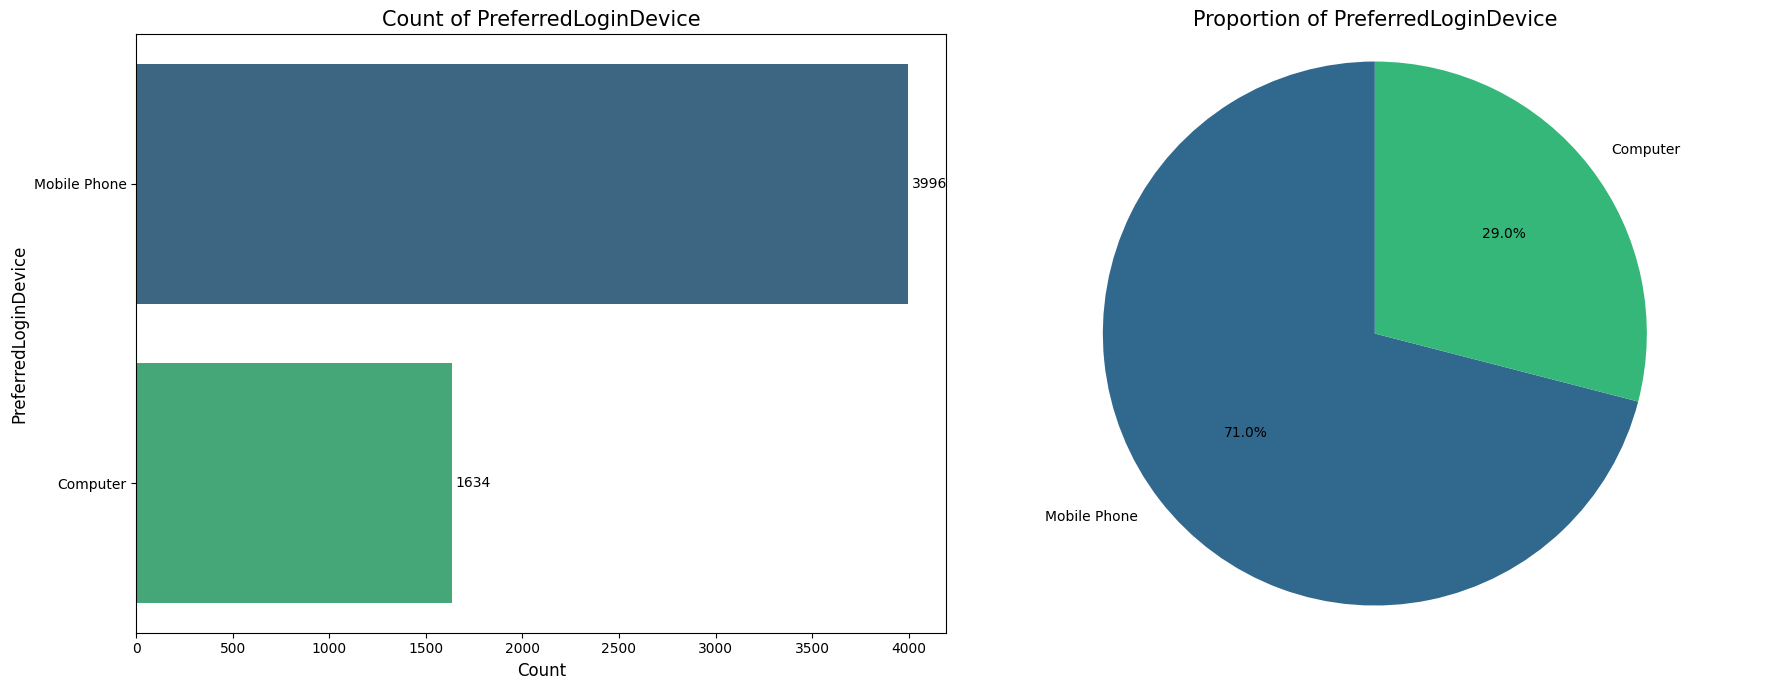

--------------------------------------------------

Analyzing Univariate Feature: PreferredPaymentMode


/tmp/ipykernel_1441534/4226672541.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')


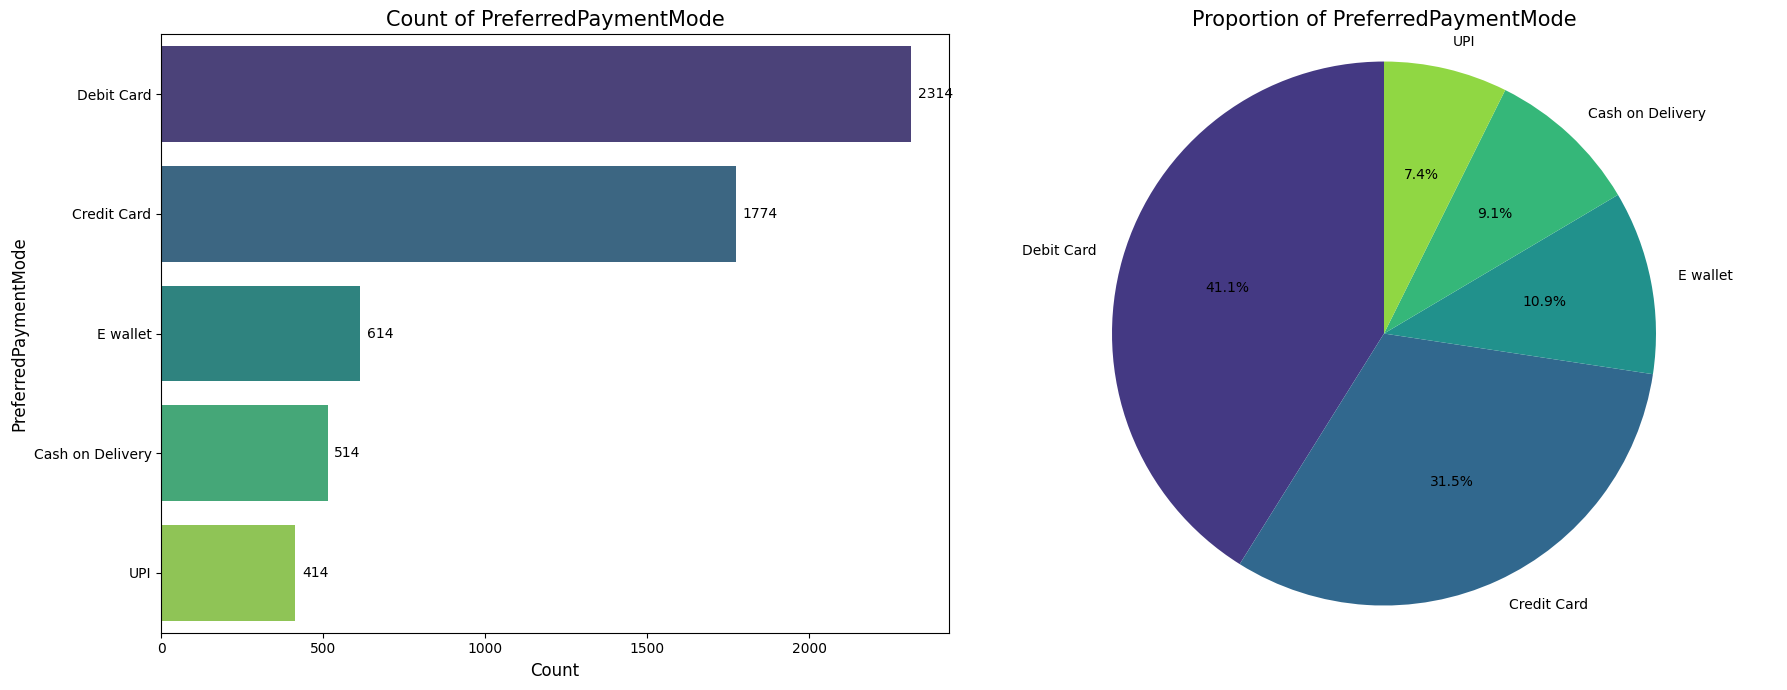

--------------------------------------------------

Analyzing Univariate Feature: Gender


/tmp/ipykernel_1441534/4226672541.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')


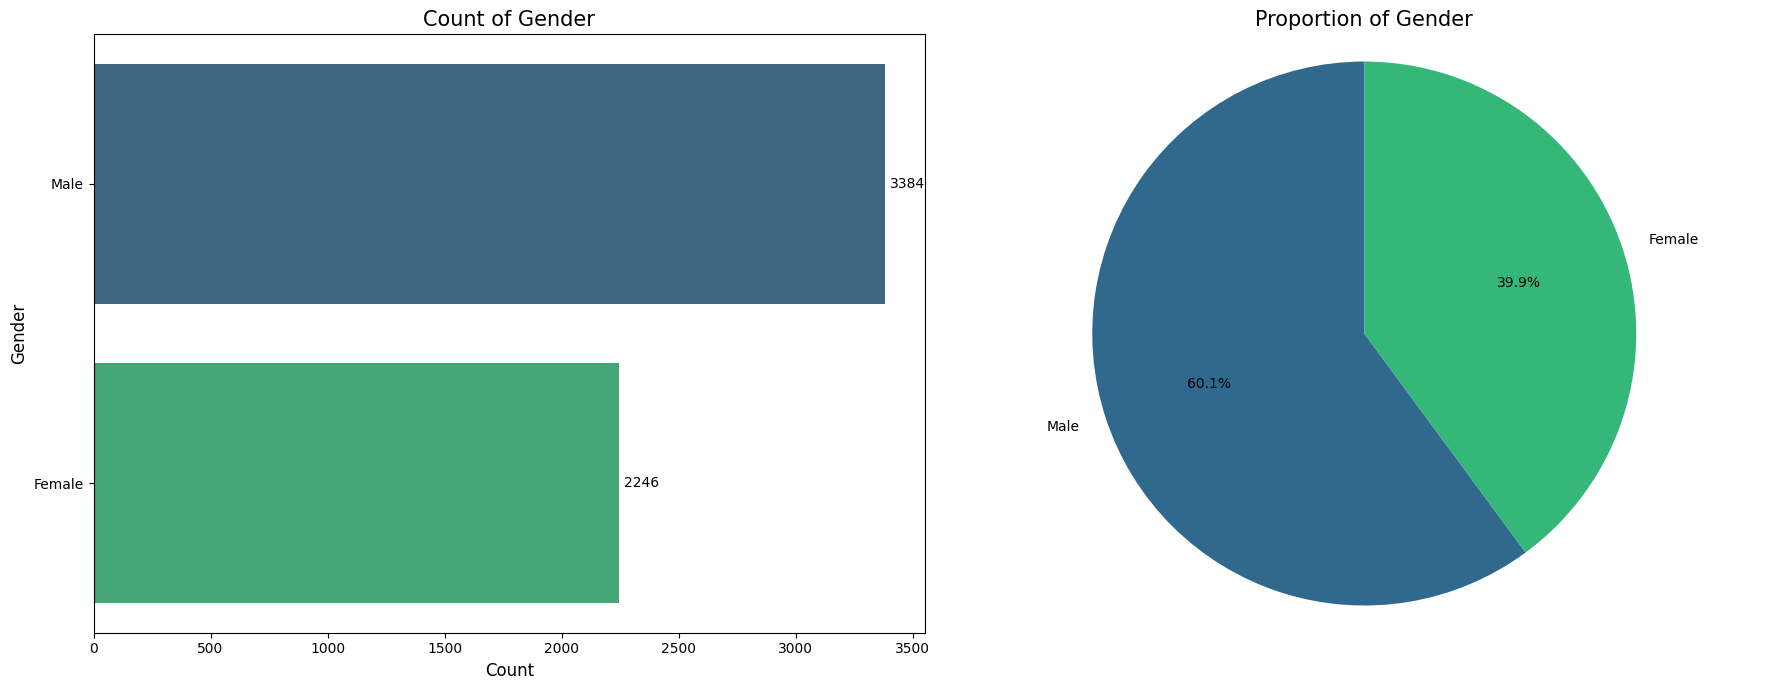

--------------------------------------------------

Analyzing Univariate Feature: PreferedOrderCat


/tmp/ipykernel_1441534/4226672541.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')


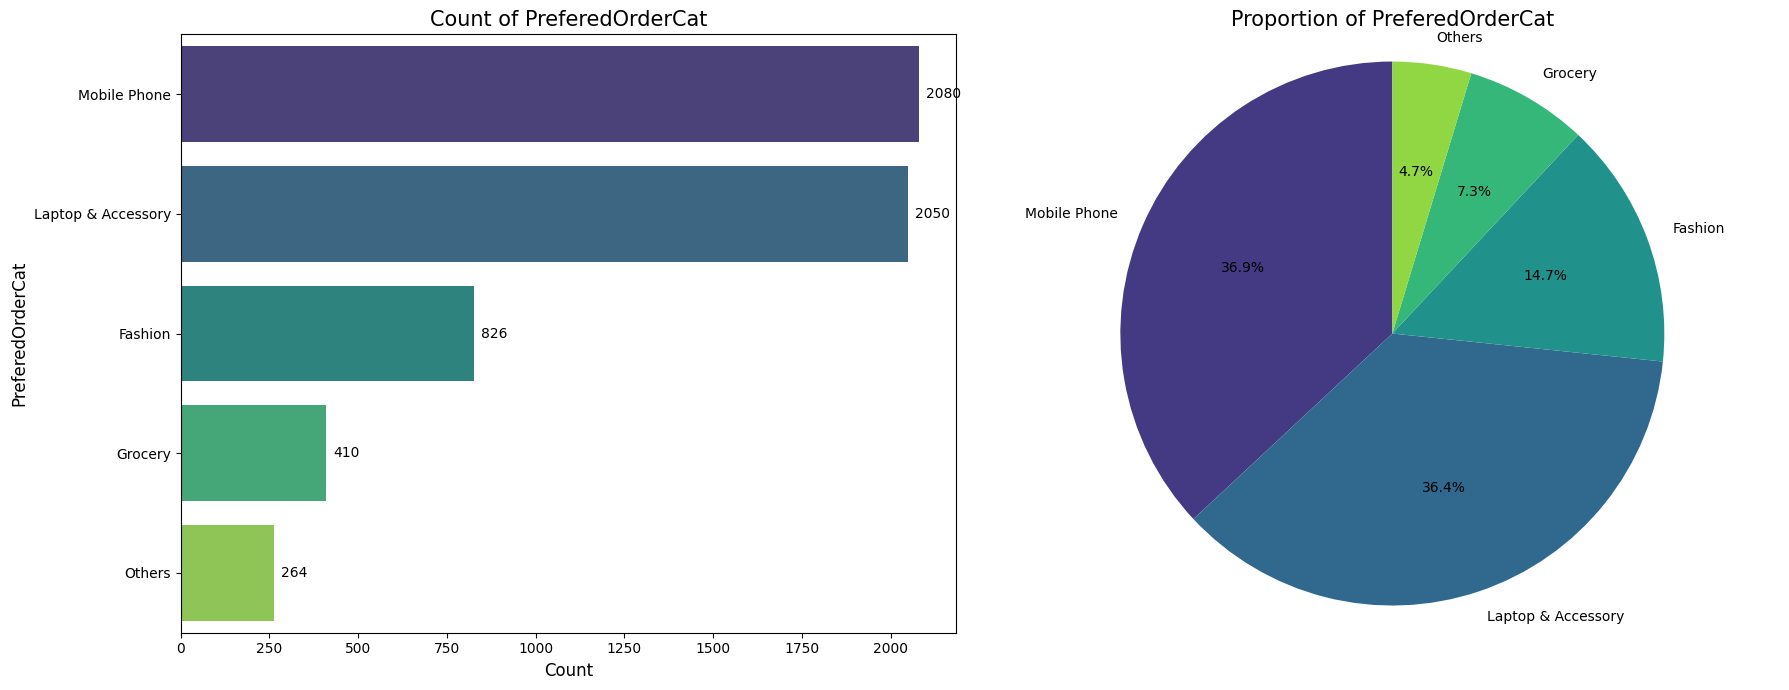

--------------------------------------------------

Analyzing Univariate Feature: MaritalStatus


/tmp/ipykernel_1441534/4226672541.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')


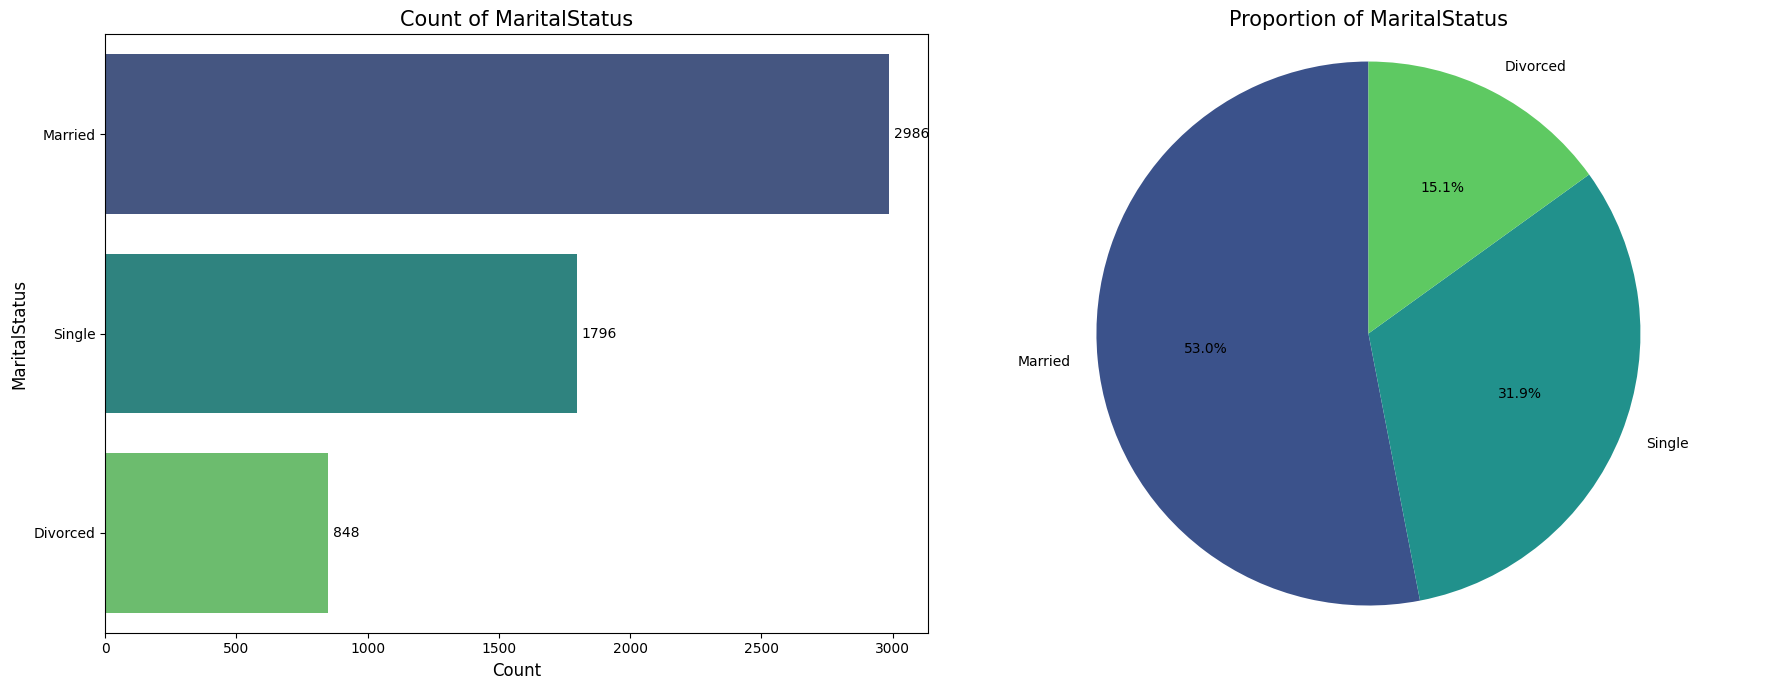

--------------------------------------------------

Analyzing Univariate Feature: CityTier


/tmp/ipykernel_1441534/4226672541.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')


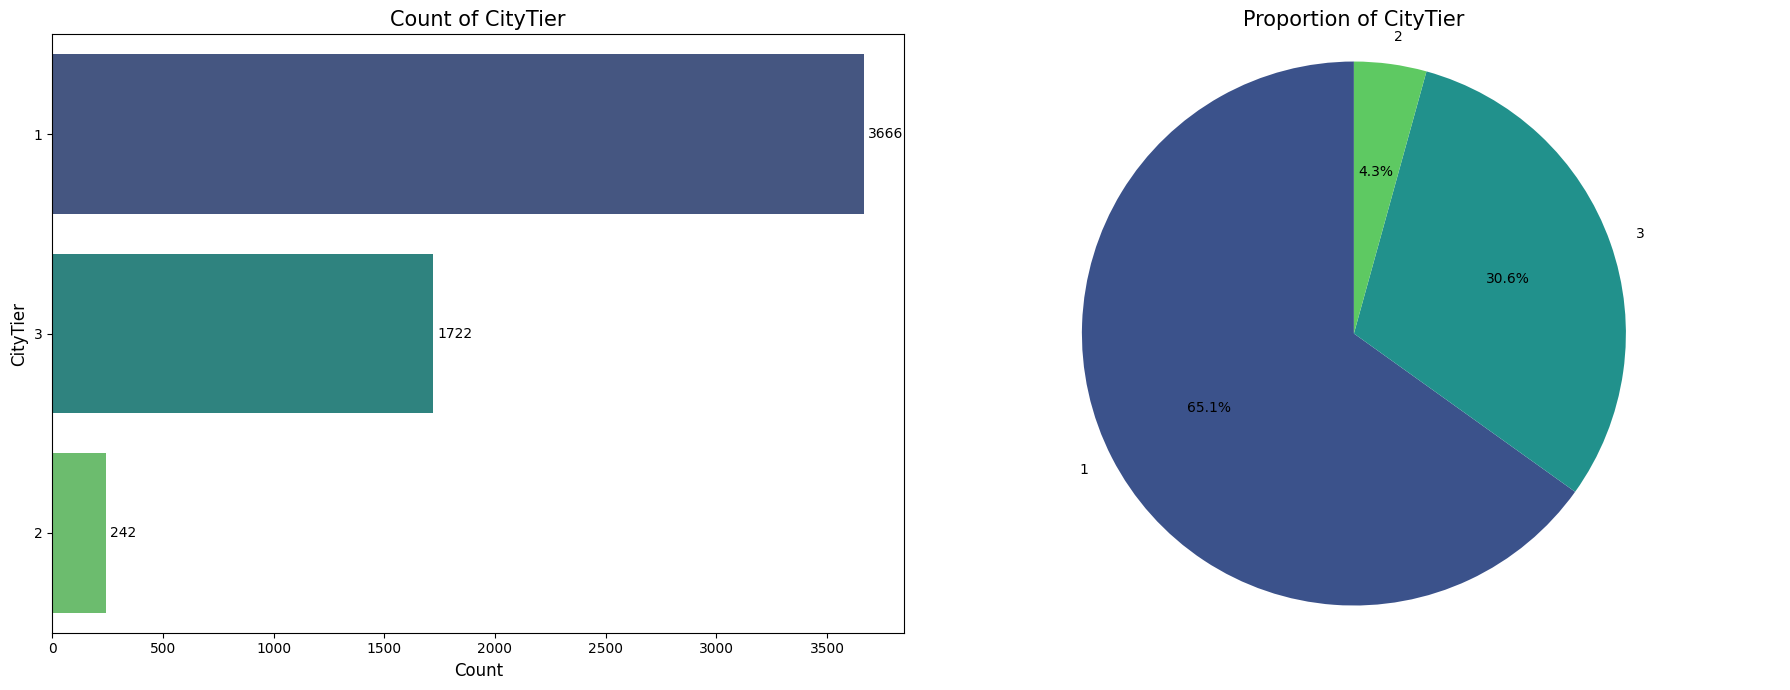

--------------------------------------------------

Analyzing Univariate Feature: SatisfactionScore


/tmp/ipykernel_1441534/4226672541.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')


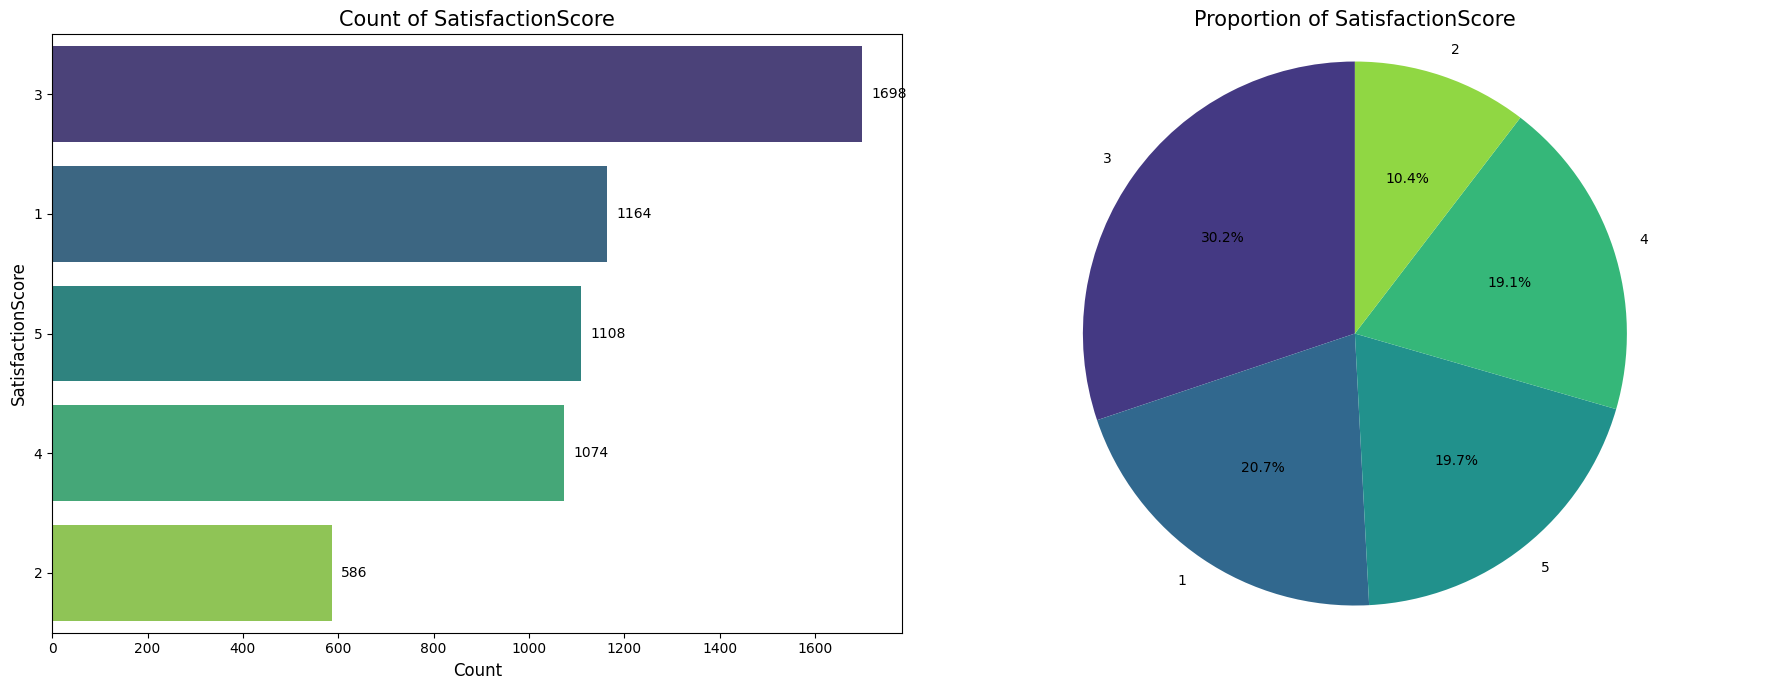

--------------------------------------------------

Analyzing Univariate Feature: Complain


/tmp/ipykernel_1441534/4226672541.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')


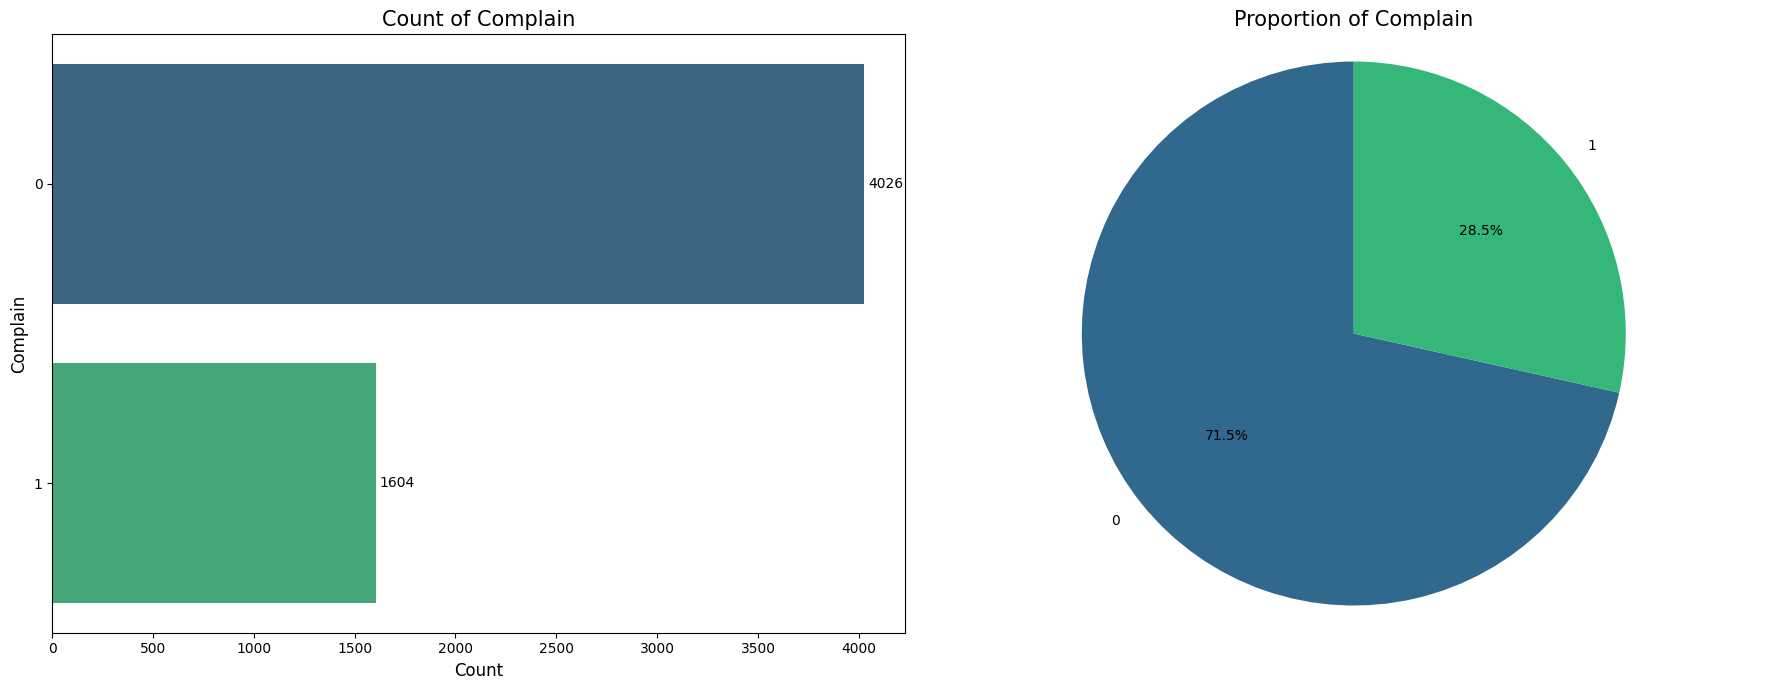

--------------------------------------------------


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Define all categorical features to analyze
categorical_features = df_ecommerce.select_dtypes(include='object').columns.tolist()
ordinal_binary_features = ['CityTier', 'SatisfactionScore', 'Complain']
all_categorical = categorical_features + ordinal_binary_features

print("--- Starting Univariate Analysis ---")

for col in all_categorical:
    print(f'\nAnalyzing Univariate Feature: {col}')
    
    # Check for "super minority" classes (e.g., less than 1% of the total)
    total_count = len(df_ecommerce[col])
    value_counts = df_ecommerce[col].value_counts(normalize=True)
    minority_classes = value_counts[value_counts < 0.01].index.tolist()
    
    if minority_classes:
        print(f"Warning: The following classes in '{col}' are super minority classes (<1%): {minority_classes}")
        print("Consider grouping these classes for better analysis/modeling.")

    plt.figure(figsize=(18, 7))

    # Subplot 1: Countplot for absolute counts
    plt.subplot(1, 2, 1)
    ax = sns.countplot(y=df_ecommerce[col], order=df_ecommerce[col].value_counts().index, palette='viridis')
    plt.title(f'Count of {col}', fontsize=15)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel(col, fontsize=12)
    for p in ax.patches:
        width = p.get_width()
        plt.text(width + 20, p.get_y() + p.get_height() / 2, f'{int(width)}', va='center')

    # Subplot 2: Pie chart for proportions
    plt.subplot(1, 2, 2)
    counts = df_ecommerce[col].value_counts()
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', len(counts)))
    plt.title(f'Proportion of {col}', fontsize=15)
    plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
    
    plt.tight_layout()
    plt.show()
    
    print("-" * 50)

**City Tier**  
- **Tier 1 cities dominate** with ~65% of customers.  
- Tier 3 contributes ~31%, while Tier 2 is very small (~4%).  
➡️ Most customers are concentrated in Tier 1 cities, so retention/marketing efforts could be city-focused.

---

**Satisfaction Score**  
- Score **3 is the most common** (~30%), suggesting many customers are neutral.  
- Extreme values:  
  - Score 2 → ~10%  
  - Score 5 → ~20%  
➡️ Satisfaction is **polarized**, with a large neutral base. Converting "3" scores into "4–5" would improve retention.

---

**Complain**  
- **71% have not complained**, but **29% have**.  
➡️ A relatively high complaint rate → improving issue resolution may significantly reduce churn.

---

**Preferred Login Device**  
- **Mobile dominates (71%)** vs Computer (29%).  
➡️ The platform is **mobile-first**, so UX improvements on mobile should be prioritized.

---

**Preferred Payment Mode**  
- **Debit card leads (41%)**  
- Credit card (32%)  
- Digital wallets (~11%)  
- Cash on Delivery (~9%)  
- UPI (7%)  
➡️ Customers prefer **cards over wallets/UPI**, which differs from some markets. Possibly dataset-specific.

---

**Gender**  
- Male ~60%  
- Female ~40%  
➡️ A male-dominated customer base, but still a significant female segment.

---

**Preferred Order Category**  
- **Mobile Phones (37%)**  
- **Laptop & Accessories (36%)**  
- Fashion (~15%)  
- Grocery (~7%)  
- Others (~5%)  
➡️ Electronics dominate; fashion & groceries are **under-penetrated growth opportunities**.

---

**✅ Overall Takeaways**  
- Business is **urban (Tier 1 heavy), mobile-first, card-payment focused, and electronics-centric**.  
- **Pain points**:  
  - ~30% complain  
  - Satisfaction skews neutral (3)  
- **Opportunities**:  
  - Improve Tier 3/2 coverage  
  - Expand Fashion & Grocery categories  
  - Reduce complaints  
  - Enhance customer satisfaction  

### 3.6.2. Bivariate

--- Starting Bivariate Analysis with Churn ---

Analyzing Bivariate Feature: PreferredLoginDevice vs. Churn


<Figure size 1200x700 with 0 Axes>

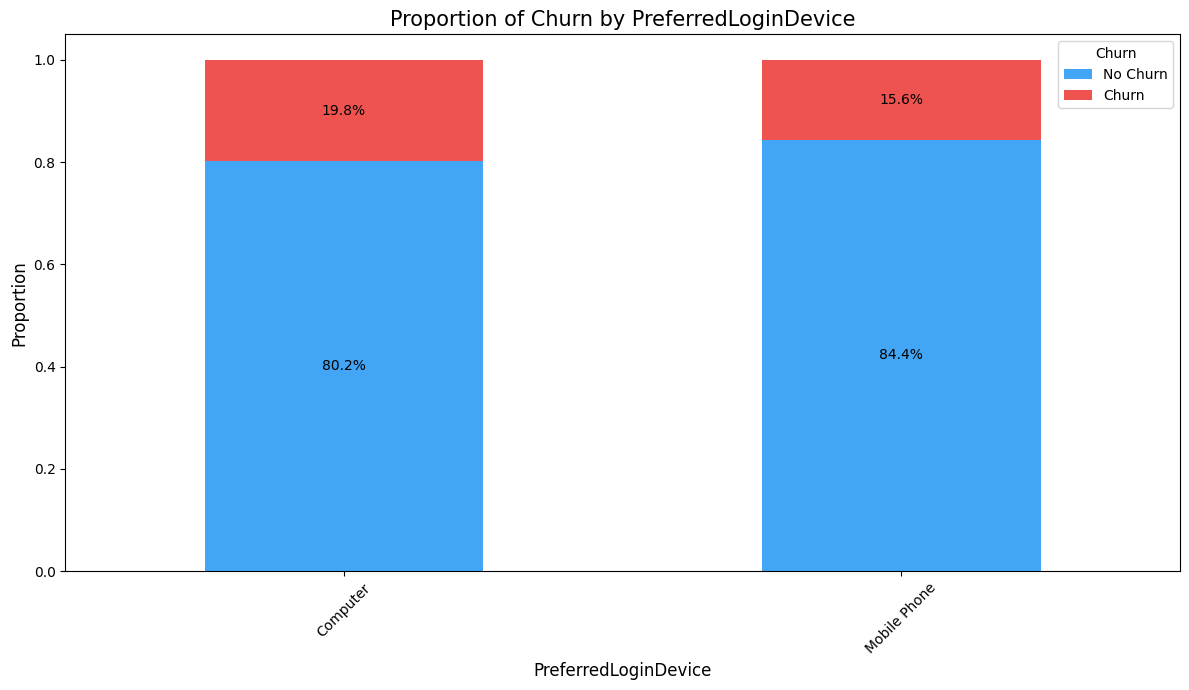

Chi-squared Test for PreferredLoginDevice: Chi2-statistic=14.401, p-value=0.000
Conclusion: There is a statistically significant association between PreferredLoginDevice and Churn.
--------------------------------------------------

Analyzing Bivariate Feature: PreferredPaymentMode vs. Churn


<Figure size 1200x700 with 0 Axes>

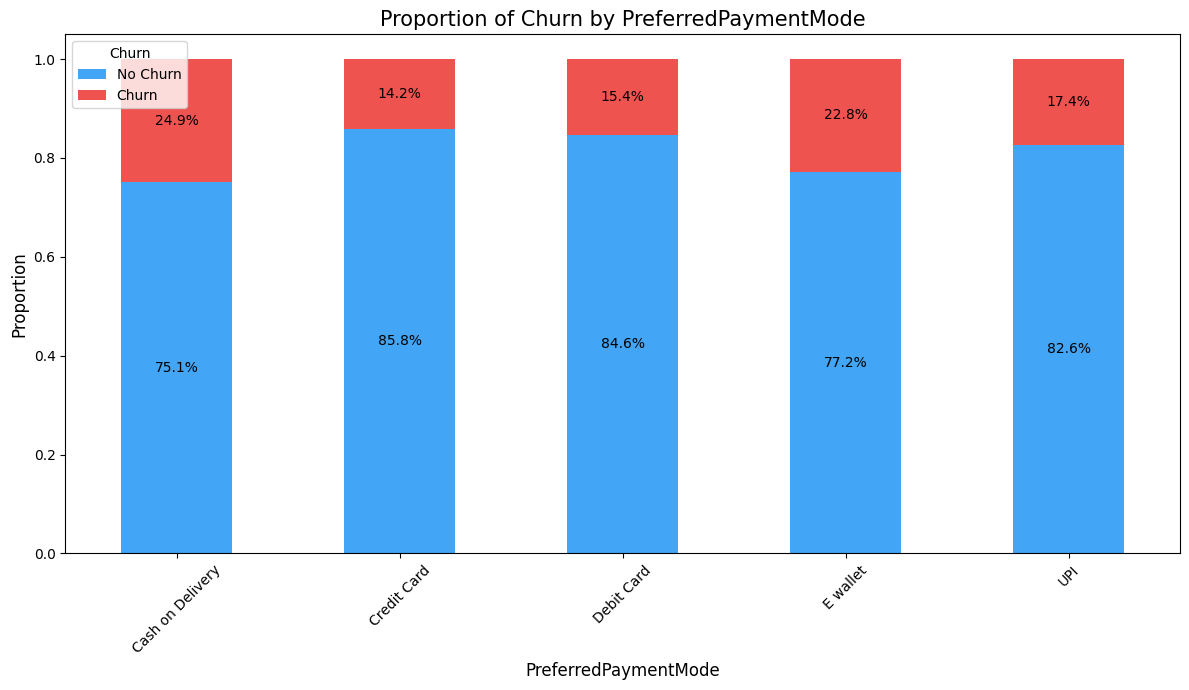

Chi-squared Test for PreferredPaymentMode: Chi2-statistic=51.829, p-value=0.000
Conclusion: There is a statistically significant association between PreferredPaymentMode and Churn.
--------------------------------------------------

Analyzing Bivariate Feature: Gender vs. Churn


<Figure size 1200x700 with 0 Axes>

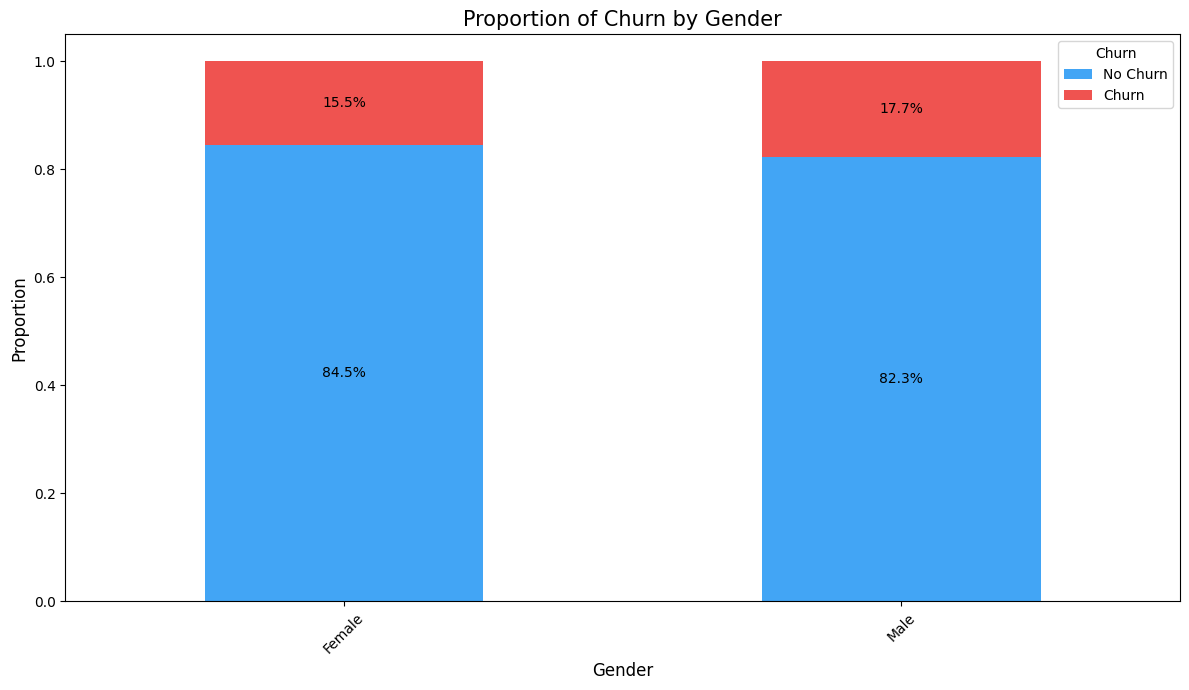

Chi-squared Test for Gender: Chi2-statistic=4.663, p-value=0.031
Conclusion: There is a statistically significant association between Gender and Churn.
--------------------------------------------------

Analyzing Bivariate Feature: PreferedOrderCat vs. Churn


<Figure size 1200x700 with 0 Axes>

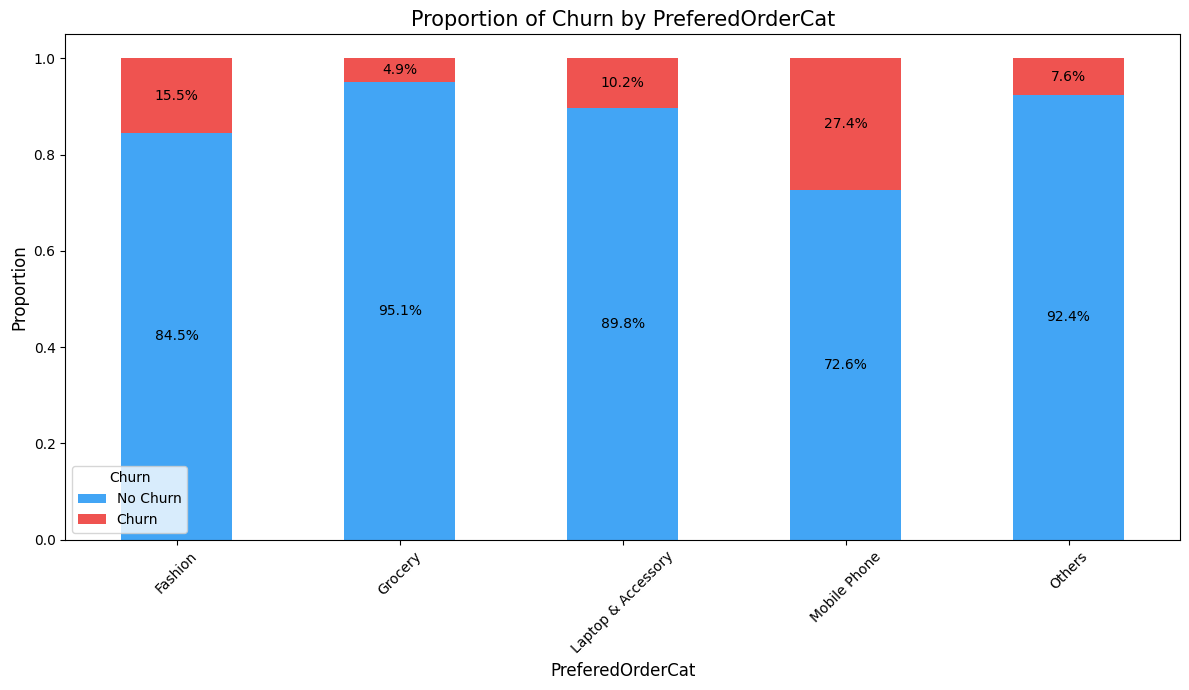

Chi-squared Test for PreferedOrderCat: Chi2-statistic=288.598, p-value=0.000
Conclusion: There is a statistically significant association between PreferedOrderCat and Churn.
--------------------------------------------------

Analyzing Bivariate Feature: MaritalStatus vs. Churn


<Figure size 1200x700 with 0 Axes>

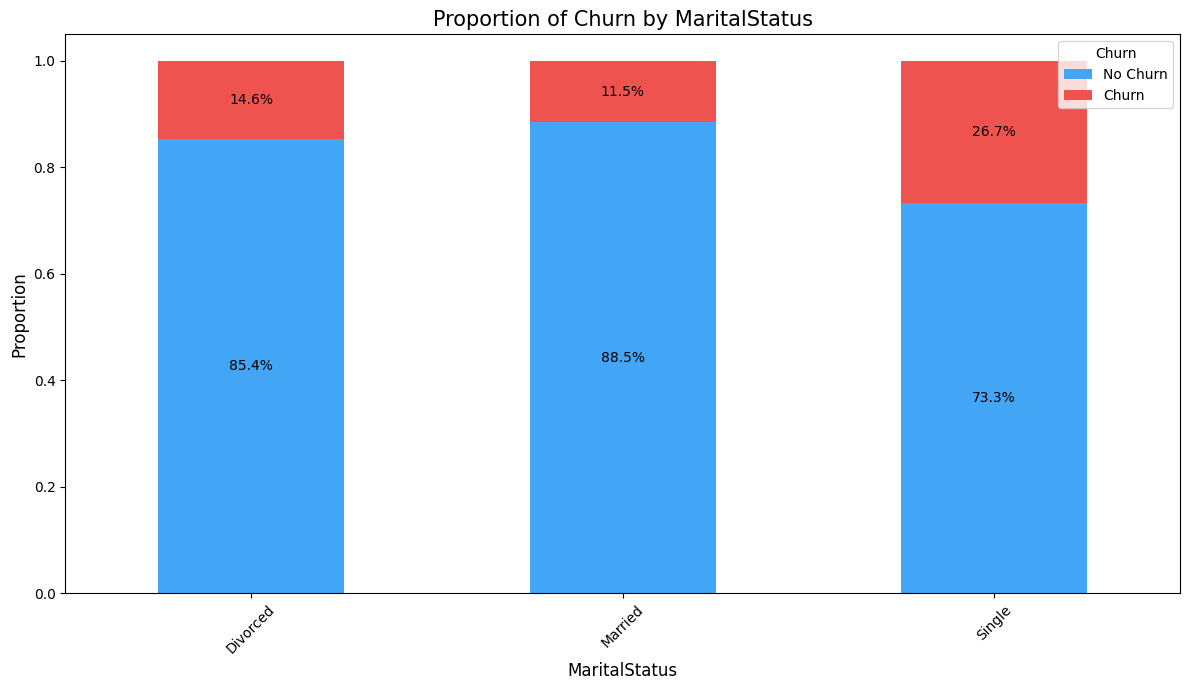

Chi-squared Test for MaritalStatus: Chi2-statistic=188.671, p-value=0.000
Conclusion: There is a statistically significant association between MaritalStatus and Churn.
--------------------------------------------------

Analyzing Bivariate Feature: CityTier vs. Churn


<Figure size 1200x700 with 0 Axes>

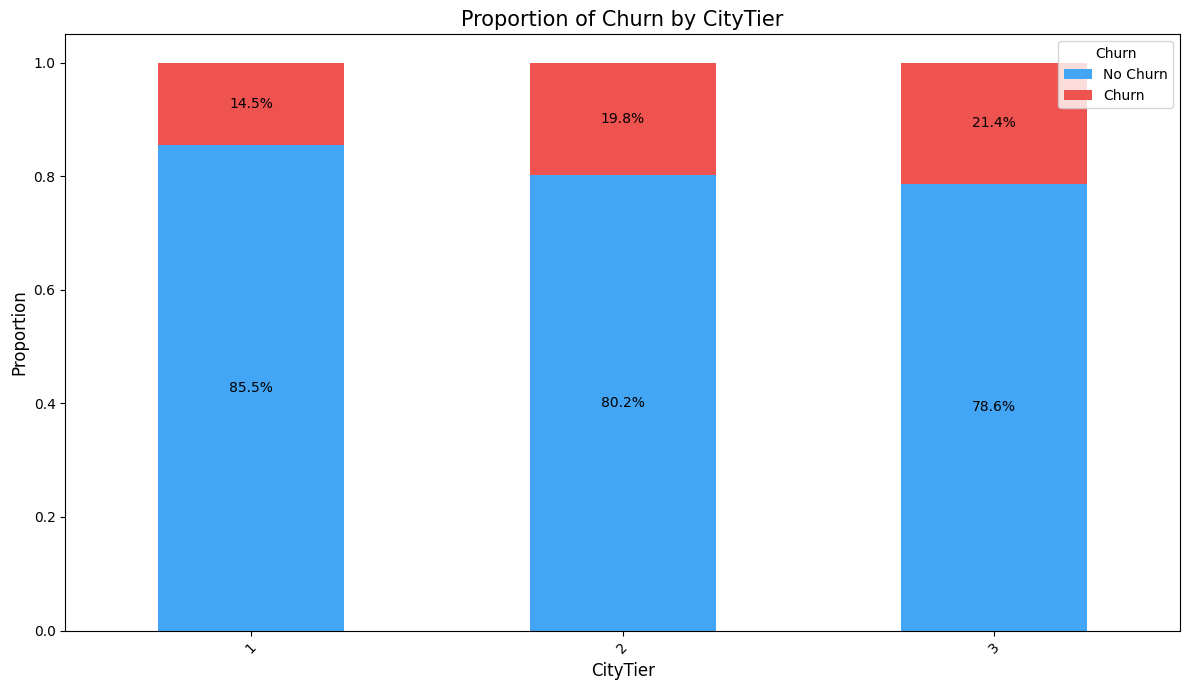

Chi-squared Test for CityTier: Chi2-statistic=40.982, p-value=0.000
Conclusion: There is a statistically significant association between CityTier and Churn.
--------------------------------------------------

Analyzing Bivariate Feature: SatisfactionScore vs. Churn


<Figure size 1200x700 with 0 Axes>

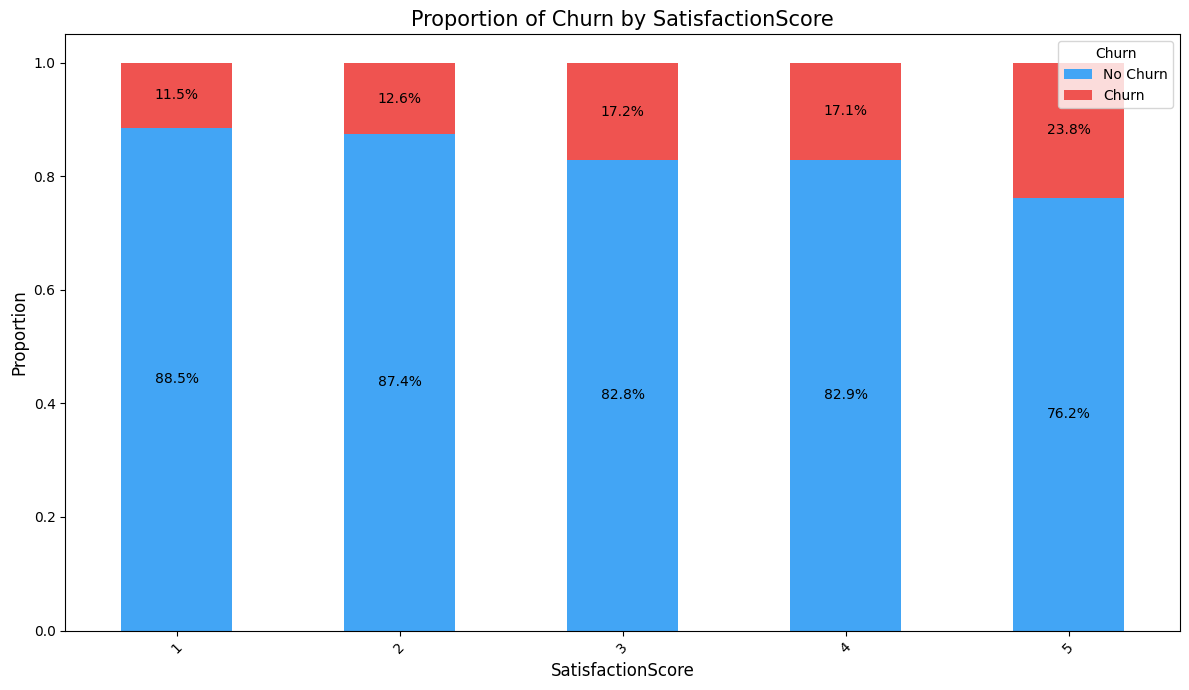

Chi-squared Test for SatisfactionScore: Chi2-statistic=69.865, p-value=0.000
Conclusion: There is a statistically significant association between SatisfactionScore and Churn.
--------------------------------------------------

Analyzing Bivariate Feature: Complain vs. Churn


<Figure size 1200x700 with 0 Axes>

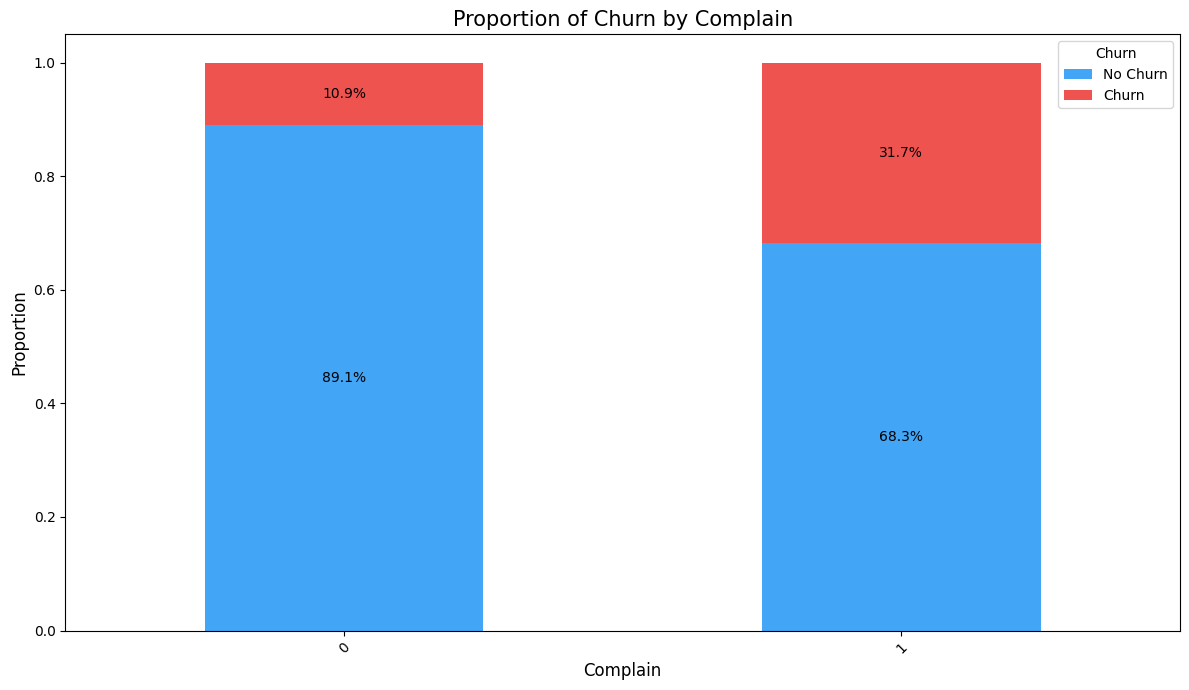

Chi-squared Test for Complain: Chi2-statistic=350.925, p-value=0.000
Conclusion: There is a statistically significant association between Complain and Churn.
--------------------------------------------------


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming df_ecommerce is already loaded and all_categorical is defined from Cell 1

print("--- Starting Bivariate Analysis with Churn ---")

for col in all_categorical:
    print(f'\nAnalyzing Bivariate Feature: {col} vs. Churn')

    # Calculate churn proportion for each category
    churn_proportion = df_ecommerce.groupby(col)['Churn'].value_counts(normalize=True).unstack().fillna(0)
    
    # The '.unstack()' operation might re-order columns; ensure 'Churn' and 'No Churn' are in the right order
    churn_proportion = churn_proportion.sort_index(axis=1)

    # Visualization: Bar plot with proportion numbers
    plt.figure(figsize=(12, 7))
    ax = churn_proportion.plot(kind='bar', stacked=True, figsize=(12, 7), color=['#42a5f5', '#ef5350'])
    
    plt.title(f'Proportion of Churn by {col}', fontsize=15)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Proportion', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Churn', labels=['No Churn', 'Churn'])

    # Add proportion labels to the bars
    for c in ax.containers:
        labels = [f'{v.get_height():.1%}' if v.get_height() > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

    # Chi-squared Test for Association
    contingency_table = pd.crosstab(df_ecommerce[col], df_ecommerce['Churn'])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    
    print(f'Chi-squared Test for {col}: Chi2-statistic={chi2:.3f}, p-value={p:.3f}')
    
    if p < 0.05:
        print(f'Conclusion: There is a statistically significant association between {col} and Churn.')
    else:
        print(f'Conclusion: There is no statistically significant association between {col} and Churn.')
        
    print("-" * 50)

--- Starting Bivariate Analysis with Churn ---

Analyzing Bivariate Feature: PreferredLoginDevice vs. Churn


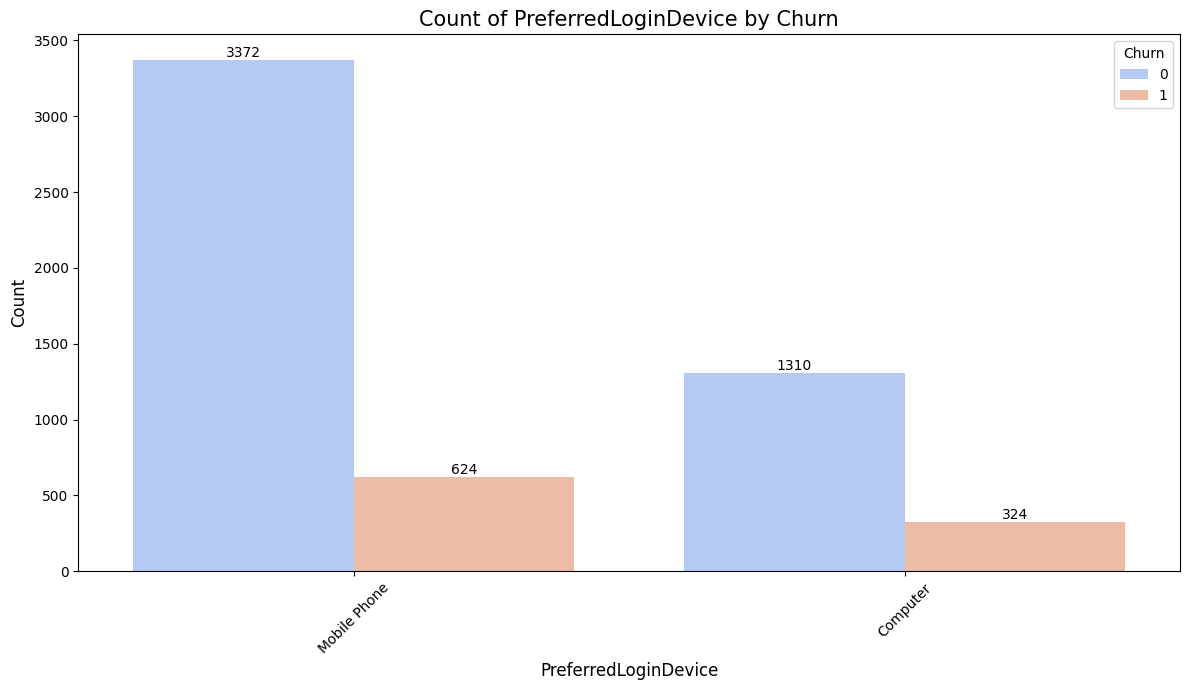

Chi-squared Test for PreferredLoginDevice: Chi2-statistic=14.401, p-value=0.000
Conclusion: There is a statistically significant association between PreferredLoginDevice and Churn.
--------------------------------------------------

Analyzing Bivariate Feature: PreferredPaymentMode vs. Churn


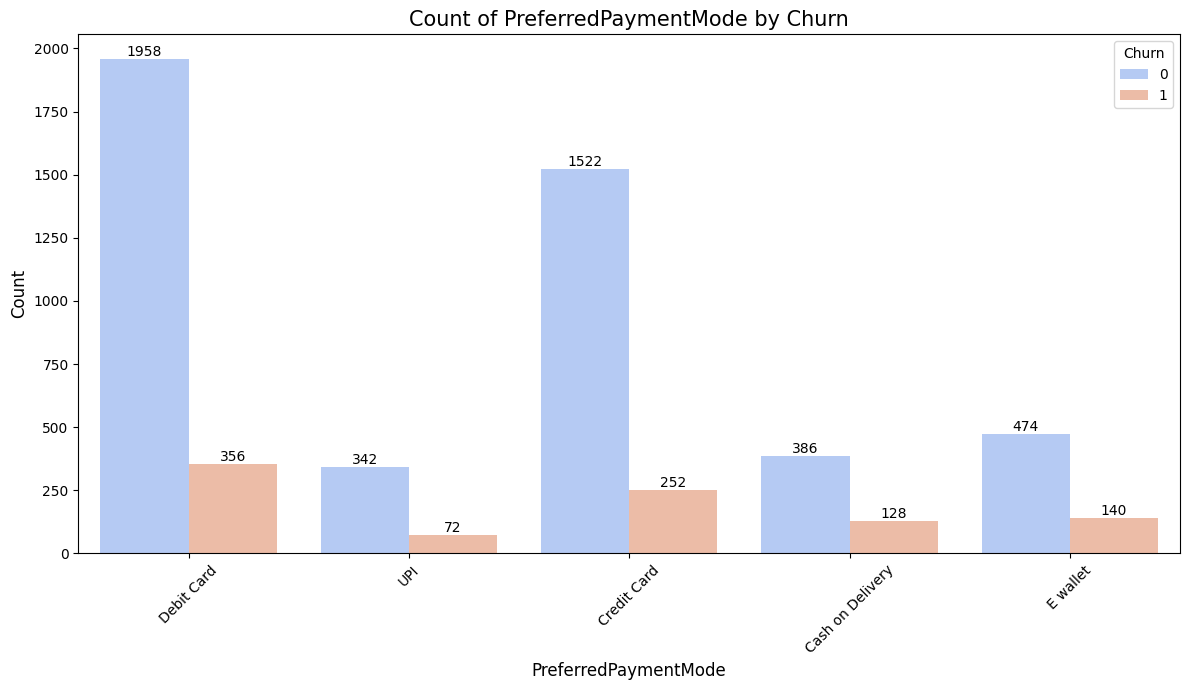

Chi-squared Test for PreferredPaymentMode: Chi2-statistic=51.829, p-value=0.000
Conclusion: There is a statistically significant association between PreferredPaymentMode and Churn.
--------------------------------------------------

Analyzing Bivariate Feature: Gender vs. Churn


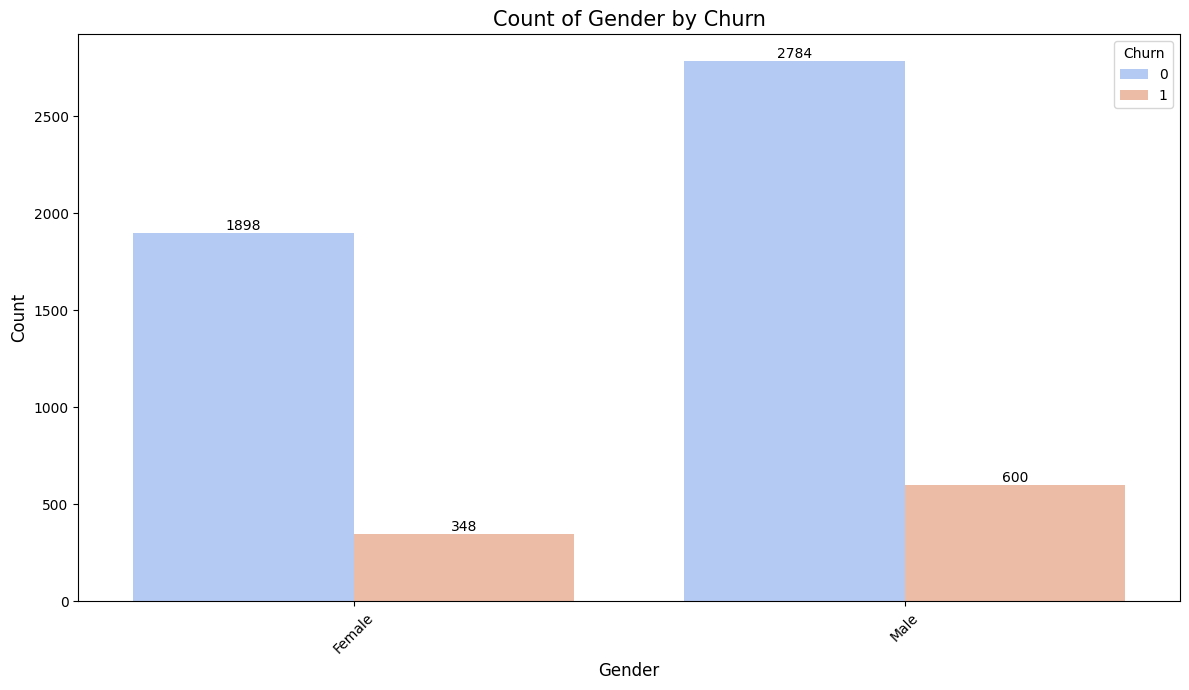

Chi-squared Test for Gender: Chi2-statistic=4.663, p-value=0.031
Conclusion: There is a statistically significant association between Gender and Churn.
--------------------------------------------------

Analyzing Bivariate Feature: PreferedOrderCat vs. Churn


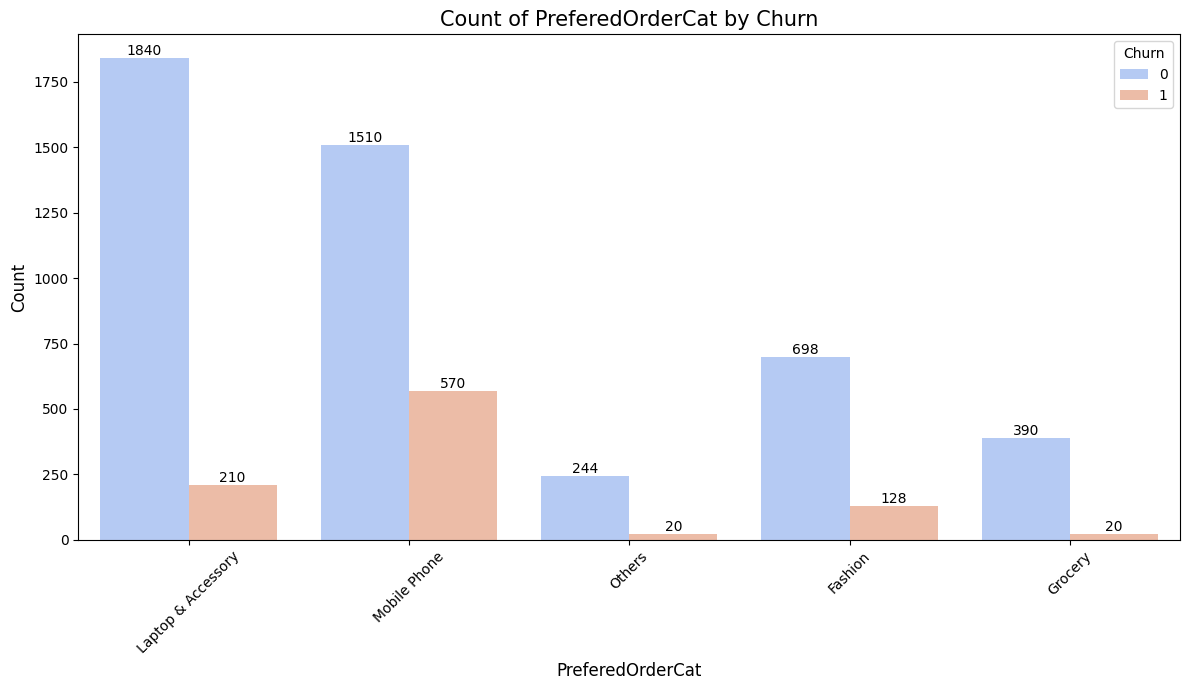

Chi-squared Test for PreferedOrderCat: Chi2-statistic=288.598, p-value=0.000
Conclusion: There is a statistically significant association between PreferedOrderCat and Churn.
--------------------------------------------------

Analyzing Bivariate Feature: MaritalStatus vs. Churn


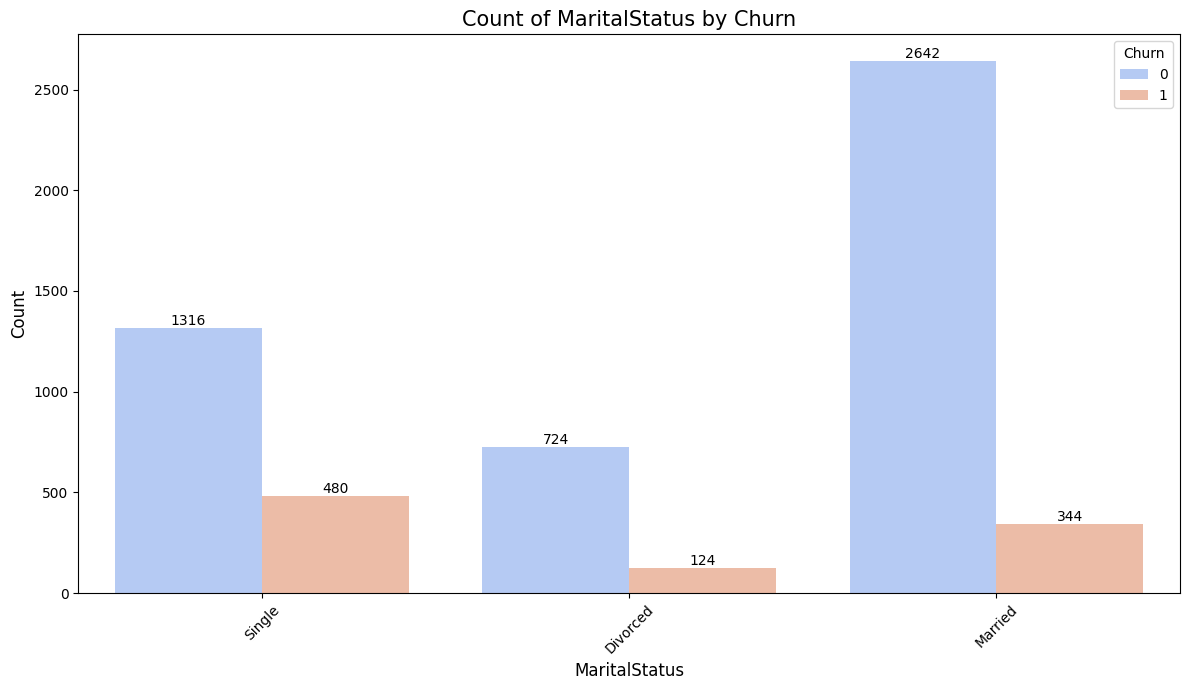

Chi-squared Test for MaritalStatus: Chi2-statistic=188.671, p-value=0.000
Conclusion: There is a statistically significant association between MaritalStatus and Churn.
--------------------------------------------------

Analyzing Bivariate Feature: CityTier vs. Churn


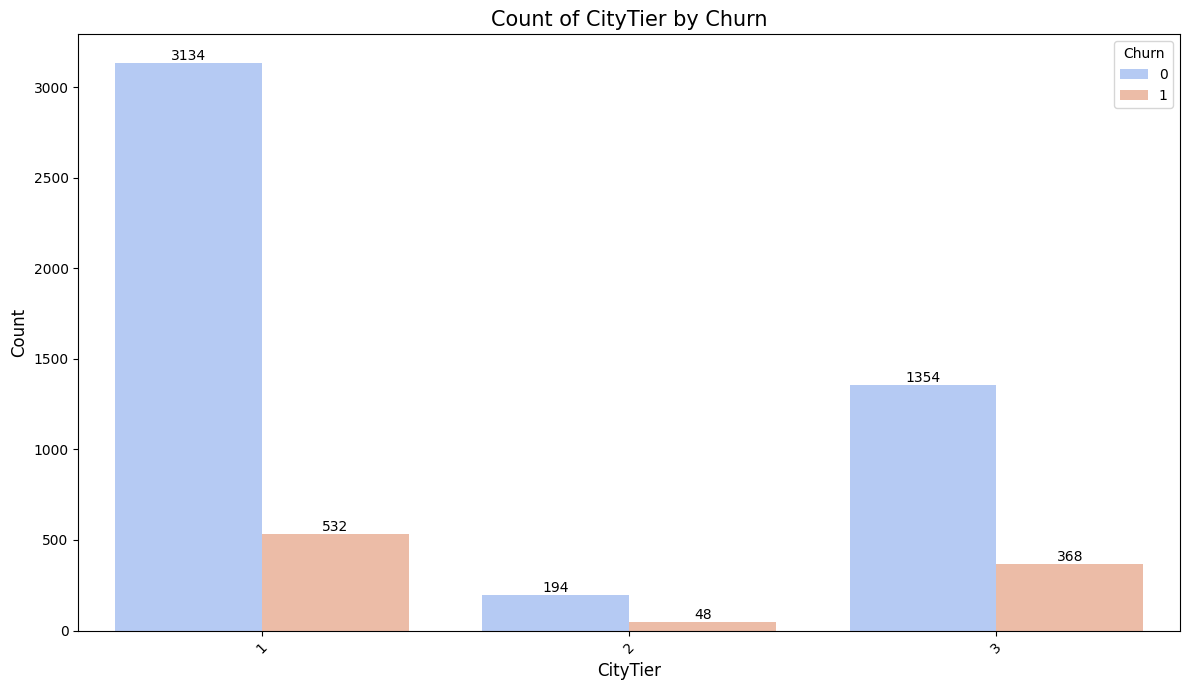

Chi-squared Test for CityTier: Chi2-statistic=40.982, p-value=0.000
Conclusion: There is a statistically significant association between CityTier and Churn.
--------------------------------------------------

Analyzing Bivariate Feature: SatisfactionScore vs. Churn


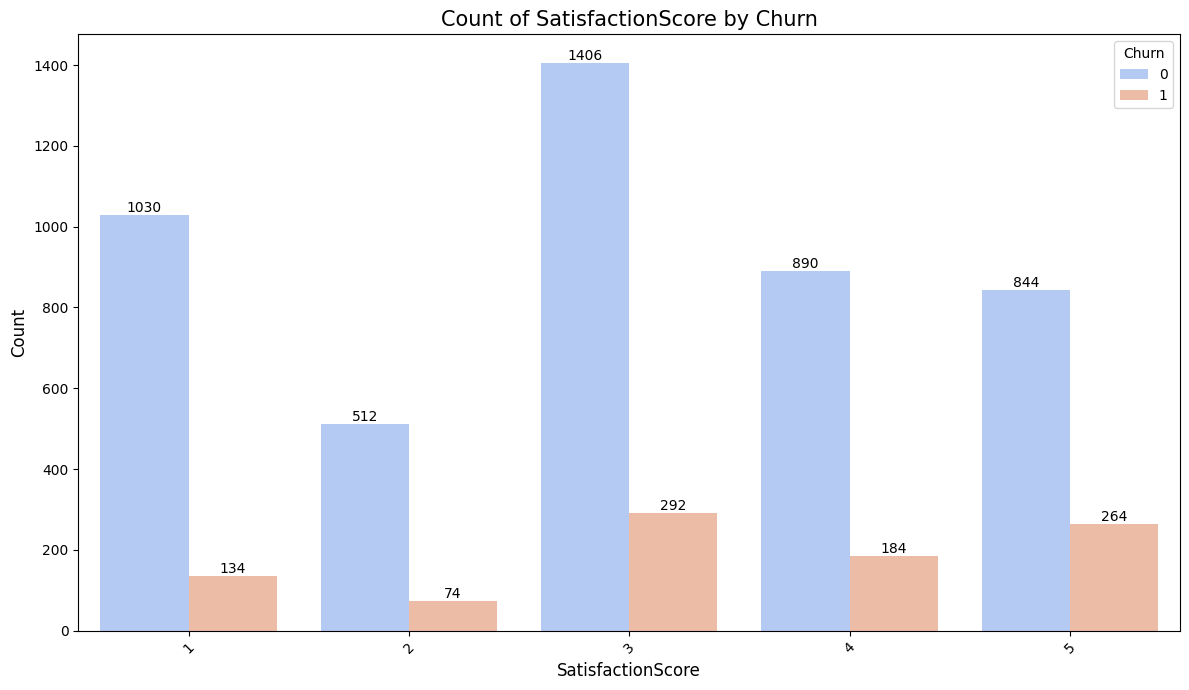

Chi-squared Test for SatisfactionScore: Chi2-statistic=69.865, p-value=0.000
Conclusion: There is a statistically significant association between SatisfactionScore and Churn.
--------------------------------------------------

Analyzing Bivariate Feature: Complain vs. Churn


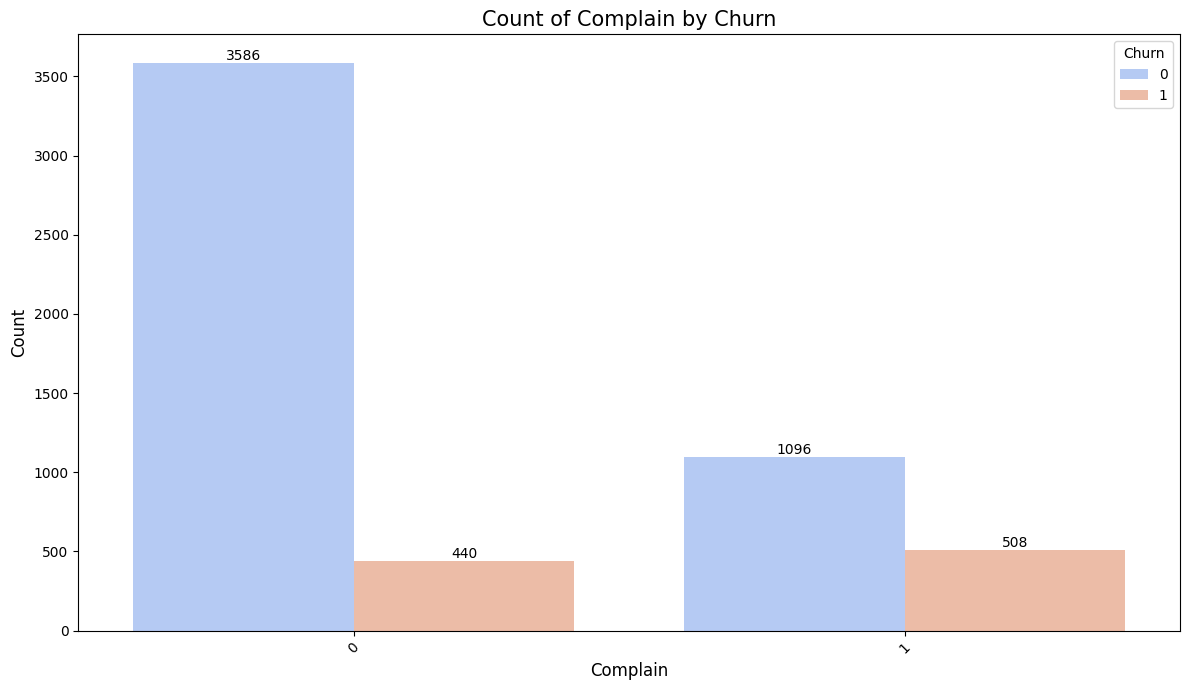

Chi-squared Test for Complain: Chi2-statistic=350.925, p-value=0.000
Conclusion: There is a statistically significant association between Complain and Churn.
--------------------------------------------------


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming df_ecommerce is already loaded and all_categorical is defined

print("--- Starting Bivariate Analysis with Churn ---")

for col in all_categorical:
    print(f'\nAnalyzing Bivariate Feature: {col} vs. Churn')

    # Visualization: Grouped Countplot for counts
    plt.figure(figsize=(12, 7))
    ax = sns.countplot(data=df_ecommerce, x=col, hue='Churn', palette='coolwarm')
    plt.title(f'Count of {col} by Churn', fontsize=15)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45)

    # Add count labels to the bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', fontsize=10)
    
    plt.tight_layout()
    plt.show()

    # Chi-squared Test for Association
    contingency_table = pd.crosstab(df_ecommerce[col], df_ecommerce['Churn'])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    
    print(f'Chi-squared Test for {col}: Chi2-statistic={chi2:.3f}, p-value={p:.3f}')
    
    if p < 0.05:
        print(f'Conclusion: There is a statistically significant association between {col} and Churn.')
    else:
        print(f'Conclusion: There is no statistically significant association between {col} and Churn.')
        
    print("-" * 50)

Based on the provided charts, here are some key insights regarding customer churn:

* **Marital Status:** Single customers have the highest churn rate at **26.7%**, significantly higher than divorced (**14.6%**) or married (**11.5%**) customers.
* **Customer Complaints:** A strong correlation exists between complaints and churn. Customers who complained (**31.7%**) are much more likely to churn compared to those who didn't (**10.9%**).
* **Preferred Payment Method:** "Cash on Delivery" has the highest churn rate at **24.9%**. This is a potential red flag, as it's the only payment method with a churn rate over 20%. Other methods like Credit Card, Debit Card, E-wallet, and UPI have lower, more consistent churn rates.
* **Satisfaction Score:** There's a clear inverse relationship between satisfaction and churn. Customers with the lowest satisfaction score (1) have a churn rate of **11.5%**, while those with the highest score (5) have the highest churn rate at **23.8%**. This seemingly counterintuitive finding warrants further investigation as it may indicate that customers who are highly satisfied and then churn are doing so for reasons unrelated to satisfaction with the product/service itself, or that the score is being used differently than intended.
* **Preferred Order Category:** "Mobile Phone" orders have a very high churn rate of **27.4%**, which is significantly higher than any other category. "Grocery" orders have the lowest churn rate at **4.9%**.
* **City Tier:** Churn rates increase as the city tier number increases. Tier 1 cities have a churn rate of **14.5%**, Tier 2 at **19.8%**, and Tier 3 at **21.4%**.
* **Preferred Login Device:** Customers who prefer to use a "Computer" to log in have a higher churn rate (**19.8%**) than those who use a "Mobile Phone" (**15.6%**).
* **Gender:** Churn rates are similar across genders, with females at **15.5%** and males at **17.7%**. This suggests that gender is not a major factor in predicting churn.

## 3.7. Missing Values Analysis

--- Starting Missing Values Analysis ---

Overall Missing values by column:
                             Total Missing  Percentage (%)
DaySinceLastOrder                      307        5.452931
OrderAmountHikeFromlastYear            265        4.706927
Tenure                                 264        4.689165
OrderCount                             258        4.582593
CouponUsed                             256        4.547069
HourSpendOnApp                         255        4.529307
WarehouseToHome                        251        4.458259

Columns with missing values are:
['DaySinceLastOrder', 'OrderAmountHikeFromlastYear', 'Tenure', 'OrderCount', 'CouponUsed', 'HourSpendOnApp', 'WarehouseToHome']


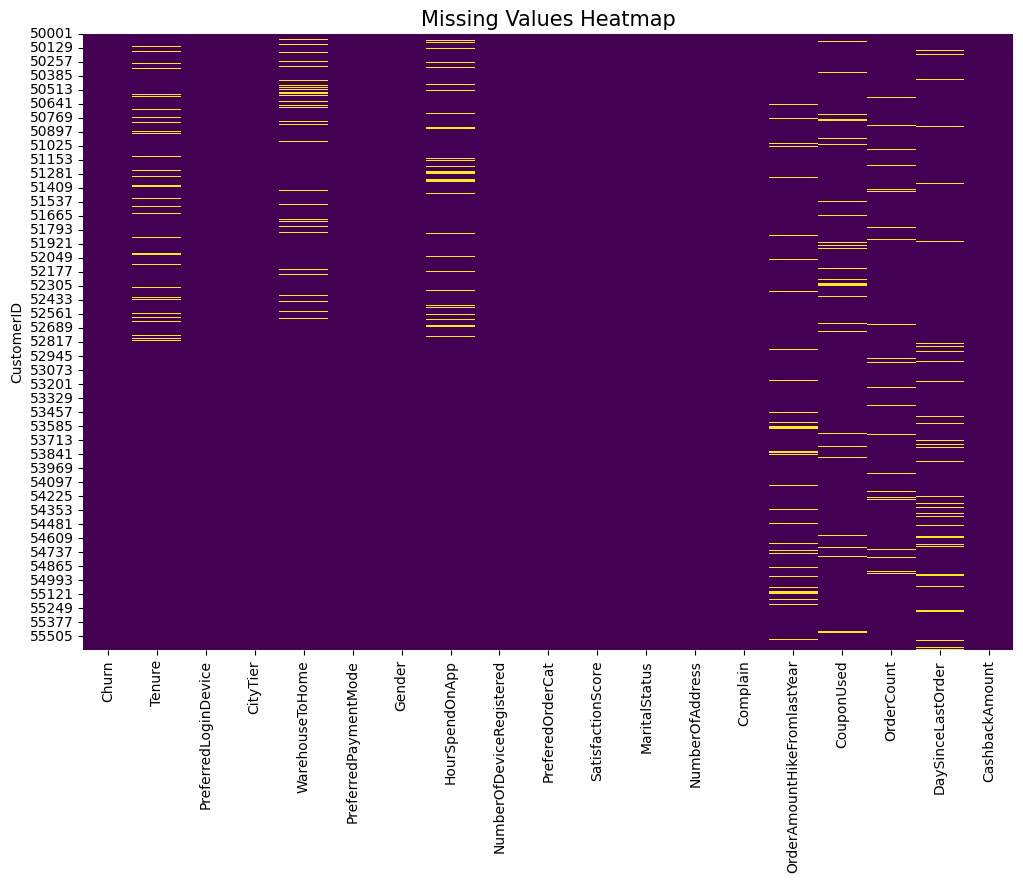

--------------------------------------------------


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Starting Missing Values Analysis ---")

# Overall Missing Values
missing_data = df_ecommerce.isnull().sum()
total_rows = len(df_ecommerce)

missing_df = pd.DataFrame({
    'Total Missing': missing_data,
    'Percentage (%)': (missing_data / total_rows) * 100
}).sort_values(by='Percentage (%)', ascending=False)

columns_with_missing_data = missing_df[missing_df['Total Missing'] > 0]

print("\nOverall Missing values by column:")
print(columns_with_missing_data)

if not columns_with_missing_data.empty:
    print("\nColumns with missing values are:")
    print(columns_with_missing_data.index.tolist())
else:
    print("\nNo missing values found in the dataset.")

# Visualize missing data as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_ecommerce.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap', fontsize=15)
plt.show()
print("-" * 50)

## 3.8. Multicollinearity and Correlation

--- Correlation Analysis (Spearman Method) ---


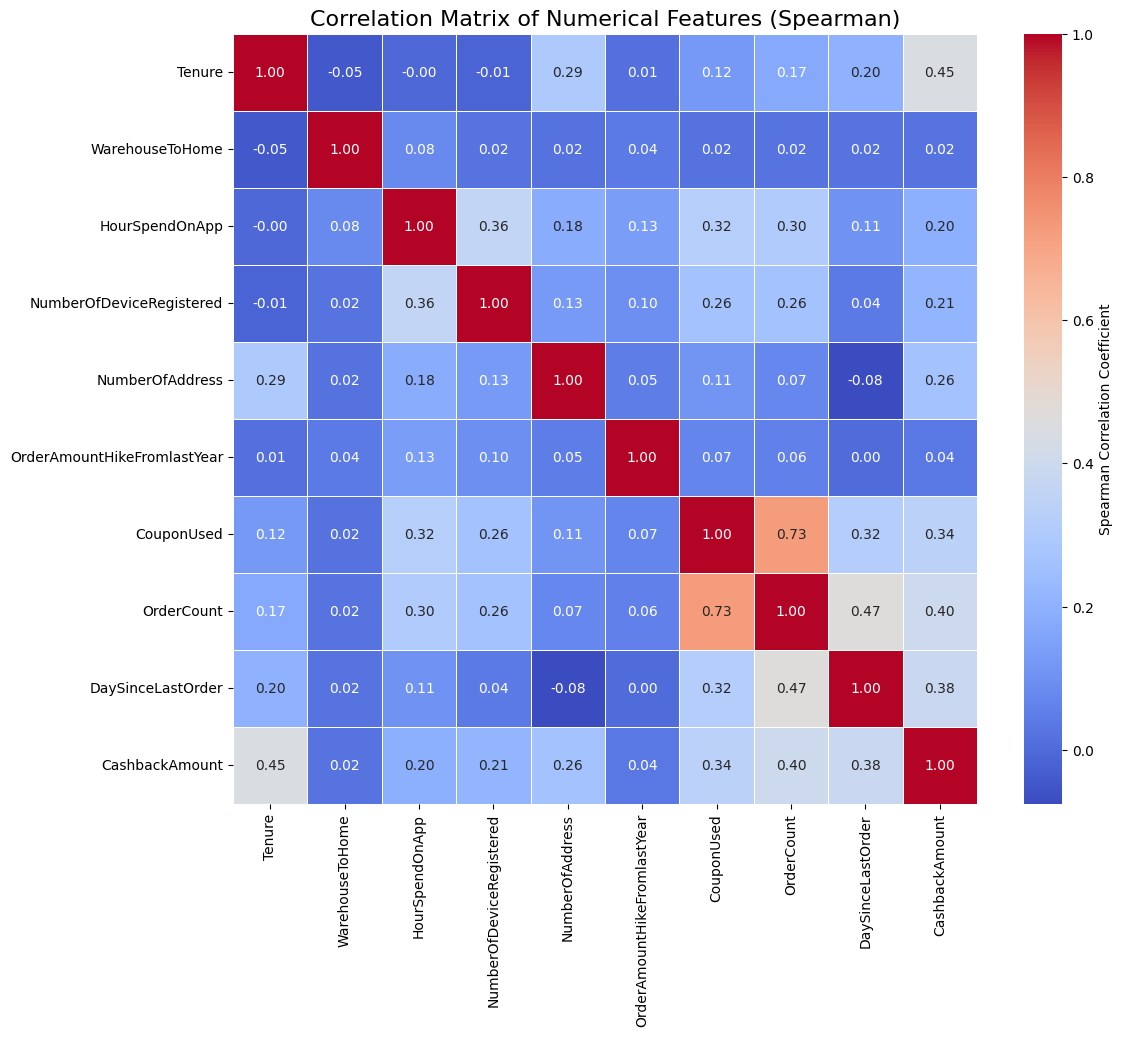


--- Multicollinearity Analysis with VIF ---
                       feature        VIF
9               CashbackAmount  31.054016
2               HourSpendOnApp  19.558858
5  OrderAmountHikeFromlastYear  16.465731
3     NumberOfDeviceRegistered  15.542530
7                   OrderCount   5.746735
6                   CouponUsed   4.541017
1              WarehouseToHome   4.243046
4              NumberOfAddress   4.093194
8            DaySinceLastOrder   3.758446
0                       Tenure   2.570139

--- VIF Interpretation ---
VIF values:
- VIF = 1: No correlation between the feature and other features.
- 1 < VIF < 5: Moderate correlation.
- VIF >= 5: High correlation, which may be problematic.

--------------------------------------------------


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming df_ecommerce is your DataFrame and you've already handled missing values

# We will use only the numerical features for this analysis
numerical_features = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'NumberOfAddress', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']

# --- Correlation Matrix and Heatmap ---
print("--- Correlation Analysis (Spearman Method) ---")

# Calculate the correlation matrix using the Spearman method
corr_matrix = df_ecommerce[numerical_features].corr(method='spearman')

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            linewidths=.5, cbar_kws={'label': 'Spearman Correlation Coefficient'})
plt.title('Correlation Matrix of Numerical Features (Spearman)', fontsize=16)
plt.show()

# --- Variance Inflation Factor (VIF) ---
# VIF measures multicollinearity. VIF > 5-10 is often a sign of high multicollinearity.
print("\n--- Multicollinearity Analysis with VIF ---")

# Drop rows with any missing values for VIF calculation
df_no_missing = df_ecommerce[numerical_features].dropna()
df_numeric = df_no_missing.astype(float)   # force to float

vif_data = pd.DataFrame()
vif_data["feature"] = df_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(df_numeric.values, i)
                   for i in range(df_numeric.shape[1])]

# Sort VIF values in descending order
vif_data.sort_values(by='VIF', ascending=False, inplace=True)
print(vif_data)

# Interpret VIF results
print("\n--- VIF Interpretation ---")
print("VIF values:")
print("- VIF = 1: No correlation between the feature and other features.")
print("- 1 < VIF < 5: Moderate correlation.")
print("- VIF >= 5: High correlation, which may be problematic.")

print("\n" + "-" * 50)

### Analysis of Numerical Features and Multicollinearity

Based on the provided correlation matrix and VIF analysis, here are the key insights.

-----

### Feature Correlations (Spearman)

The correlation matrix shows the relationships between pairs of numerical features.

  * **Moderate Positive Correlations**:
      * **OrderCount and CouponUsed (0.73)**: Customers who place more orders tend to use more coupons.
      * **DaysSinceLastOrder and OrderCount (0.47)**: This is an interesting inverse relationship. The correlation is moderate, but it suggests that as the number of orders increases, the days since the last order might also increase, or vice-versa.
      * **Tenure and CashbackAmount (0.45)**: Customers who have been with the company longer tend to receive more cashback.
  * **Weak Correlations**: Most other feature pairs show very weak correlations (values close to 0), indicating they have minimal linear relationship with each other. For example, **HoursSpendOnApp** has a very low correlation with all other features.

-----

### Multicollinearity Analysis (VIF)

Multicollinearity is a concern when independent variables in a model are highly correlated with each other. A VIF (Variance Inflation Factor) score of 5 or higher is generally considered problematic.

  * **High Multicollinearity (VIF \> 5)**:

      * **CashbackAmount (31.05)**: This feature has a very high VIF, indicating it is highly correlated with other features, particularly **Tenure** as seen in the correlation matrix. This could lead to unstable model coefficients.
      * **HoursSpendOnApp (19.56)**: Also has a high VIF, suggesting it is correlated with other features, despite the low pairwise correlations in the matrix. This may be due to a complex, non-linear relationship or correlations with a combination of other variables.
      * **OrderAmountHikeFromLastYear (16.47)**: This feature is highly correlated with other variables, which could pose a problem for model stability.
      * **NumberOfDeviceRegistered (15.54)**: A high VIF suggests this feature is also highly correlated with other variables.
      * **OrderCount (5.75)**: The VIF is just above the threshold, which could be problematic due to its high correlation with **CouponUsed**.

  * **Moderate to Low Multicollinearity (VIF \< 5)**:

      * **CouponUsed (4.54)**: The VIF is on the higher end of the moderate range, likely due to its correlation with **OrderCount**.
      * **WarehouseToHome (4.24)**, **NumberOfAddress (4.09)**, **DaysSinceLastOrder (3.76)**, and **Tenure (2.57)**: These features have VIF scores within the acceptable range, indicating they are not highly correlated with other features and are suitable for inclusion in a regression model.

## 3.9. Save Dataset

In [ ]:
# df_ecommerce.to_csv('eda.csv')

# 4. Preprocessing

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from collections import Counter
import joblib

# --- Global variable for reproducibility ---
RANDOM_STATE = 42

# --- 1. Load the dataset ---
try:
    df = pd.read_csv('eda.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'eda.csv' not found. Please check the file path.")
    exit()

# --- 2. Define features and target ---
TARGET = 'Churn'

# Categorization based on the provided feedback
# CustomerID is not used as features
df.set_index('CustomerID', inplace=True)

ordinal_features = ['CityTier', 'SatisfactionScore']
numerical_features = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'NumberOfAddress', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']
categorical_features = ['PreferedOrderCat', 'MaritalStatus', 'PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'Complain']

# Separate target variable
X = df.drop(columns=[TARGET])
y = df[TARGET]

# --- 3. Split the data to prevent data leakage ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
print(f"Original data shape: {X.shape}")
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"\nOriginal Churn distribution: {Counter(y)}")
print(f"Training Churn distribution: {Counter(y_train)}")

# --- 4. Define Preprocessing Pipelines ---
# A. Numerical Preprocessor
numerical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# B. Nominal Categorical Preprocessor (One-Hot Encoding)
nominal_preprocessor = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# C. Ordinal Categorical Preprocessor (Ordinal Encoding)
ordinal_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Impute missing values with the most frequent category
    ('ordinal', OrdinalEncoder())
])

# D. Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_preprocessor, numerical_features),
        ('nominal_cat', nominal_preprocessor, categorical_features),
        ('ordinal_cat', ordinal_preprocessor, ordinal_features)
    ],
    remainder='passthrough'
)

# --- 6. Apply Preprocessing to Data ---
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("\nData preprocessing and feature engineering complete.")

# --- 7. Handle Class Imbalance using SMOTE on Training Data Only ---
smote = SMOTE(random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

print(f"\nOriginal training set size: {X_train_processed.shape[0]}")
print(f"Resampled training set size: {X_train_resampled.shape[0]}")
print(f"Resampled Churn distribution: {Counter(y_train_resampled)}")

# --- 8. Final Ready Data for Modeling ---
print("\nPreprocessing workflow complete. The data is now ready for model training.")

# Save the preprocessor
joblib.dump(preprocessor, 'preprocessor.pkl')
print(f"\nPreprocessor saved to 'preprocessor.pkl'")

Dataset loaded successfully.
Original data shape: (5630, 18)
Training data shape: (4504, 18)
Testing data shape: (1126, 18)

Original Churn distribution: Counter({0: 4682, 1: 948})
Training Churn distribution: Counter({0: 3746, 1: 758})

Data preprocessing and feature engineering complete.

Original training set size: 4504
Resampled training set size: 7492
Resampled Churn distribution: Counter({0: 3746, 1: 3746})

Preprocessing workflow complete. The data is now ready for model training.

Preprocessor saved to 'preprocessor.pkl'


In [ ]:
# If X_test is still a DataFrame after preprocessing
test_df = X_test.copy()
test_df['Churn'] = y_test.values

# If X_test is a NumPy array after preprocessing
# you’ll need to bring back the feature names
if not isinstance(X_test, pd.DataFrame):
    feature_names = preprocessor.get_feature_names_out()
    test_df = pd.DataFrame(X_test, columns=feature_names)
    test_df['Churn'] = y_test.values

# Save to CSV for inspection or later use
test_df.to_csv("test_set.csv")

print("Test set saved successfully with shape:", test_df.shape)

Test set saved successfully with shape: (1126, 19)


# 5. Methodology (Modeling/Analysis)

## 5.1. Benchmark Model


--- Benchmarking Models Without Hyperparameter Tuning ---

Training LogisticRegression (default params)...
Classification Report for LogisticRegression:

              precision    recall  f1-score   support

           0       0.96      0.79      0.87       936
           1       0.44      0.83      0.58       190

    accuracy                           0.80      1126
   macro avg       0.70      0.81      0.72      1126
weighted avg       0.87      0.80      0.82      1126



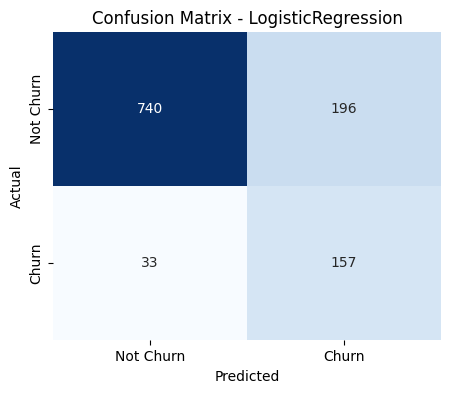


Training KNeighborsClassifier (default params)...
Classification Report for KNeighborsClassifier:

              precision    recall  f1-score   support

           0       0.99      0.87      0.92       936
           1       0.59      0.96      0.73       190

    accuracy                           0.88      1126
   macro avg       0.79      0.91      0.83      1126
weighted avg       0.92      0.88      0.89      1126



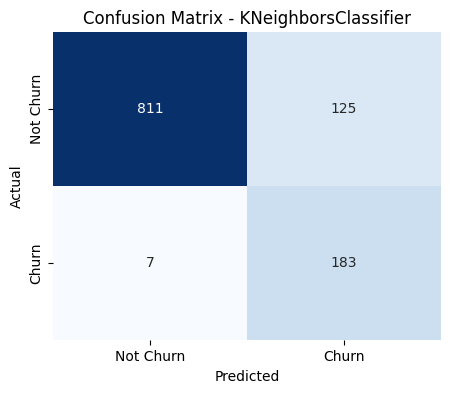


Training DecisionTreeClassifier (default params)...
Classification Report for DecisionTreeClassifier:

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       936
           1       0.84      0.94      0.89       190

    accuracy                           0.96      1126
   macro avg       0.92      0.95      0.93      1126
weighted avg       0.96      0.96      0.96      1126



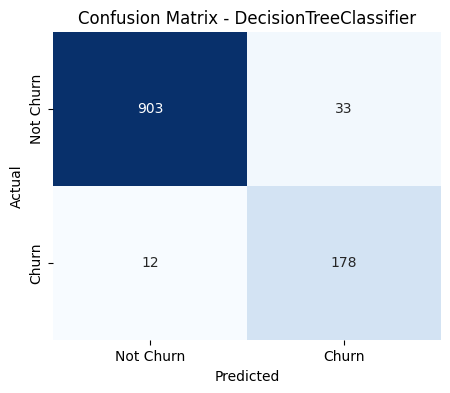


Training RandomForestClassifier (default params)...
Classification Report for RandomForestClassifier:

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       936
           1       0.93      0.88      0.91       190

    accuracy                           0.97      1126
   macro avg       0.95      0.94      0.94      1126
weighted avg       0.97      0.97      0.97      1126



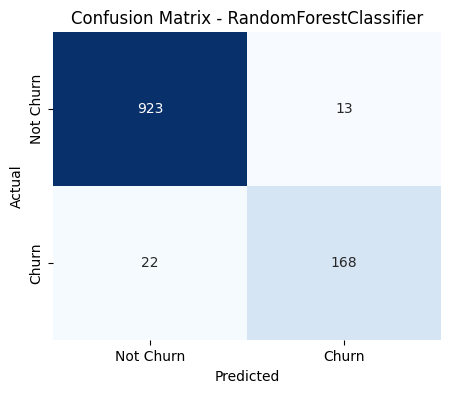


Training XGBClassifier (default params)...
Classification Report for XGBClassifier:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       936
           1       0.96      0.96      0.96       190

    accuracy                           0.99      1126
   macro avg       0.98      0.98      0.98      1126
weighted avg       0.99      0.99      0.99      1126



/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:50:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


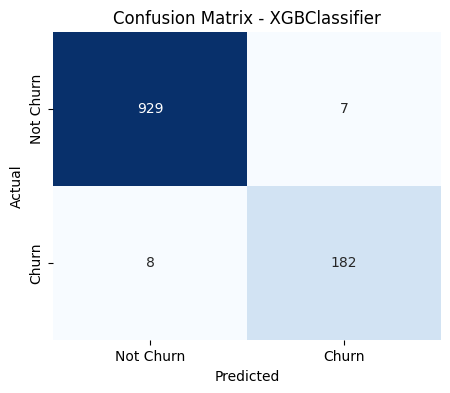


--- Simple Models Results Summary (No Tuning, Sorted by F2-Score) ---
                 Model  F2-Score  ROC-AUC  F3-Score  F4-Score  Precision   Recall
         XGBClassifier  0.958904 0.997627  0.958399  0.958191   0.962963 0.957895
DecisionTreeClassifier  0.916581 0.950793  0.926601  0.930791   0.843602 0.936842
RandomForestClassifier  0.892667 0.995133  0.888419  0.886681   0.928177 0.884211
  KNeighborsClassifier  0.856742 0.968466  0.906838  0.929211   0.594156 0.963158
    LogisticRegression  0.705301 0.882720  0.761028  0.786620   0.444759 0.826316


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Import all necessary models and metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import fbeta_score, roc_auc_score, precision_score, recall_score, classification_report, confusion_matrix, make_scorer

# --- Benchmark Models Without Hyperparameter Tuning ---
print("\n--- Benchmarking Models Without Hyperparameter Tuning ---")

simple_models = {
    'LogisticRegression': LogisticRegression(random_state=RANDOM_STATE, solver='liblinear'),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'RandomForestClassifier': RandomForestClassifier(random_state=RANDOM_STATE),
    'XGBClassifier': XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss')
}

results_simple = []

for name, model in simple_models.items():
    print(f"\nTraining {name} (default params)...")
    model.fit(X_train_resampled, y_train_resampled)

    y_pred = model.predict(X_test_processed)
    y_pred_proba = model.predict_proba(X_test_processed)[:, 1] if hasattr(model, 'predict_proba') else None

    f2 = fbeta_score(y_test, y_pred, beta=2)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 'N/A'
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f3 = fbeta_score(y_test, y_pred, beta=3)
    f4 = fbeta_score(y_test, y_pred, beta=4)
    conf_matrix = confusion_matrix(y_test, y_pred)

    results_simple.append({
        'Model': name,
        'F2-Score': f2,
        'ROC-AUC': roc_auc,
        'F3-Score': f3,
        'F4-Score': f4,
        'Precision': precision,
        'Recall': recall
    })
    
    print(f"Classification Report for {name}:\n")
    print(classification_report(y_test, y_pred, zero_division=0))

    # --- Plot Confusion Matrix ---
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Not Churn", "Churn"], 
                yticklabels=["Not Churn", "Churn"])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# --- Results Summary ---
results_simple_df = pd.DataFrame(results_simple).sort_values(by='F2-Score', ascending=False)
print("\n--- Simple Models Results Summary (No Tuning, Sorted by F2-Score) ---")
print(results_simple_df.to_string(index=False))


## 5.2. Hyperparameter Tuning

--- Starting Model Training & Hyperparameter Tuning ---

Training and tuning LogisticRegression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for LogisticRegression: {'C': 100, 'penalty': 'l1'}
Best F2-Score on training data: 0.8356

Training and tuning KNeighborsClassifier...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for KNeighborsClassifier: {'n_neighbors': 3, 'weights': 'distance'}
Best F2-Score on training data: 0.9815

Training and tuning DecisionTreeClassifier...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for DecisionTreeClassifier: {'max_depth': None, 'min_samples_split': 2}
Best F2-Score on training data: 0.9495

Training and tuning RandomForestClassifier...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for RandomForestClassifier: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}
Best F2-Score on training data: 0.9810

Training and 

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:51:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:51:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:51:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:51:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not

Best parameters for XGBClassifier: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Best F2-Score on training data: 0.9829

--- Final Model Evaluation on the Test Set ---

Evaluating LogisticRegression...
Classification Report for LogisticRegression:

              precision    recall  f1-score   support

           0       0.96      0.79      0.87       936
           1       0.44      0.82      0.58       190

    accuracy                           0.80      1126
   macro avg       0.70      0.81      0.72      1126
weighted avg       0.87      0.80      0.82      1126

Confusion Matrix for LogisticRegression:

[[741 195]
 [ 34 156]]


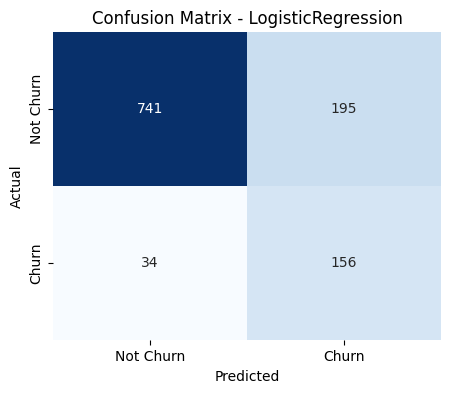


Evaluating KNeighborsClassifier...
Classification Report for KNeighborsClassifier:

              precision    recall  f1-score   support

           0       0.99      0.92      0.96       936
           1       0.72      0.96      0.82       190

    accuracy                           0.93      1126
   macro avg       0.86      0.94      0.89      1126
weighted avg       0.95      0.93      0.93      1126

Confusion Matrix for KNeighborsClassifier:

[[865  71]
 [  8 182]]


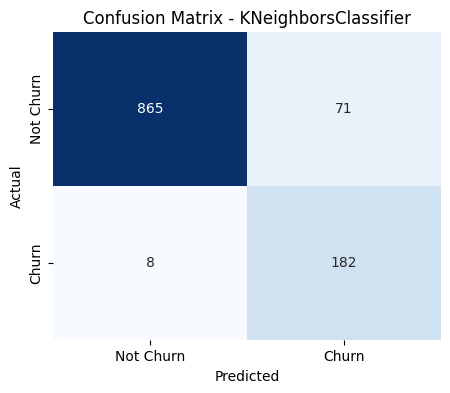


Evaluating DecisionTreeClassifier...
Classification Report for DecisionTreeClassifier:

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       936
           1       0.84      0.94      0.89       190

    accuracy                           0.96      1126
   macro avg       0.92      0.95      0.93      1126
weighted avg       0.96      0.96      0.96      1126

Confusion Matrix for DecisionTreeClassifier:

[[903  33]
 [ 12 178]]


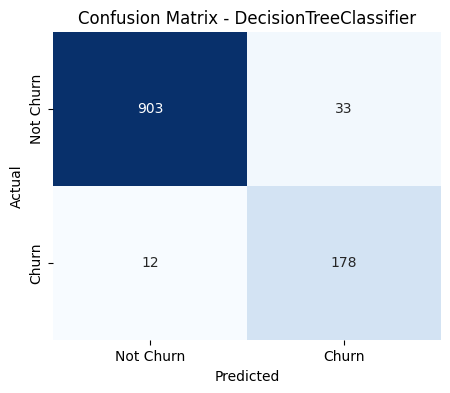


Evaluating RandomForestClassifier...
Classification Report for RandomForestClassifier:

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       936
           1       0.93      0.88      0.91       190

    accuracy                           0.97      1126
   macro avg       0.95      0.94      0.94      1126
weighted avg       0.97      0.97      0.97      1126

Confusion Matrix for RandomForestClassifier:

[[923  13]
 [ 22 168]]


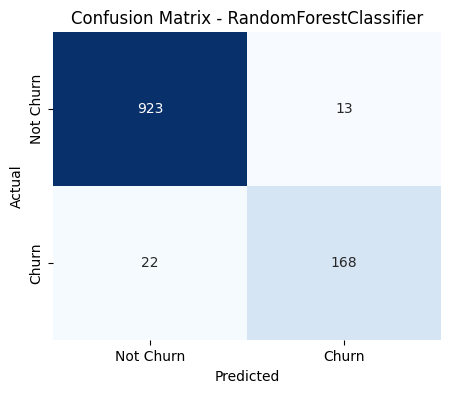


Evaluating XGBClassifier...
Classification Report for XGBClassifier:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       936
           1       0.97      0.96      0.97       190

    accuracy                           0.99      1126
   macro avg       0.98      0.98      0.98      1126
weighted avg       0.99      0.99      0.99      1126

Confusion Matrix for XGBClassifier:

[[931   5]
 [  8 182]]


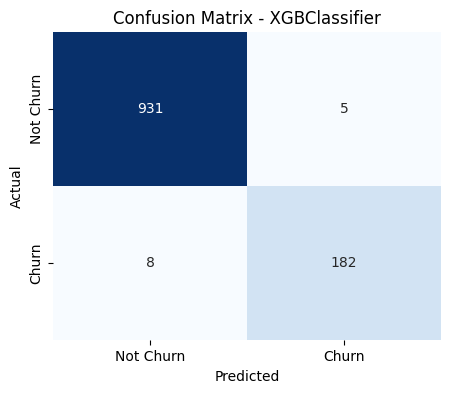


--- Final Results Summary (Sorted by F2-Score) ---
                 Model  F2-Score  ROC-AUC  F3-Score  F4-Score  Precision   Recall
         XGBClassifier  0.960929 0.998459  0.959410  0.958785   0.973262 0.957895
DecisionTreeClassifier  0.916581 0.950793  0.926601  0.930791   0.843602 0.936842
  KNeighborsClassifier  0.898322 0.976046  0.927152  0.939569   0.719368 0.957895
RandomForestClassifier  0.892667 0.995133  0.888419  0.886681   0.928177 0.884211
    LogisticRegression  0.702070 0.883120  0.756914  0.782070   0.444444 0.821053

Final Best Model: XGBClassifier with an F2-Score of 0.9609

Best model 'XGBClassifier' saved to 'best_benchmark_model.pkl'


In [ ]:
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import StratifiedKFold, GridSearchCV

# --- 1. Define Models and Hyperparameter Grids ---
# A dictionary to hold all models and their tuning grids.
models = {
    'LogisticRegression': {
        'model': LogisticRegression(random_state=RANDOM_STATE, solver='liblinear'),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2']
        }
    },
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance']
        }
    },
    'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(random_state=RANDOM_STATE),
        'params': {
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 5, 10]
        }
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(random_state=RANDOM_STATE),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, None],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'XGBClassifier': {
        'model': XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    }
}

# --- 2. Custom Scorers for Evaluation ---
f2_scorer = make_scorer(fbeta_score, beta=2)
f3_scorer = make_scorer(fbeta_score, beta=3)
f4_scorer = make_scorer(fbeta_score, beta=4)
precision_scorer = make_scorer(precision_score)
roc_auc_scorer = make_scorer(roc_auc_score)
recall_scorer = make_scorer(recall_score)

scoring_metrics = {
    'F2-Score': f2_scorer,
    'ROC-AUC': roc_auc_scorer,
    'F3-Score': f3_scorer,
    'F4-Score': f4_scorer,
    'Precision': precision_scorer,
    'Recall': recall_scorer
}

# --- 3. Hyperparameter Tuning and Cross-Validation ---
best_models = {}
best_params = {}
best_score = 0
best_model_name = ''

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print("--- Starting Model Training & Hyperparameter Tuning ---")

for name, item in models.items():
    print(f"\nTraining and tuning {name}...")
    
    grid_search = GridSearchCV(
        estimator=item['model'],
        param_grid=item['params'],
        scoring=f2_scorer,
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train_resampled, y_train_resampled)
    
    best_models[name] = grid_search.best_estimator_
    best_params[name] = grid_search.best_params_
    
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best F2-Score on training data: {grid_search.best_score_:.4f}")

# --- 4. Final Evaluation on the Test Set ---
print("\n--- Final Model Evaluation on the Test Set ---")
results = []

for name, model in best_models.items():
    print(f"\nEvaluating {name}...")
    y_pred = model.predict(X_test_processed)
    y_pred_proba = model.predict_proba(X_test_processed)[:, 1] if hasattr(model, 'predict_proba') else None

    f2 = fbeta_score(y_test, y_pred, beta=2)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 'N/A'
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f3 = fbeta_score(y_test, y_pred, beta=3)
    f4 = fbeta_score(y_test, y_pred, beta=4)
    conf_matrix = confusion_matrix(y_test, y_pred)

    results.append({
        'Model': name,
        'F2-Score': f2,
        'ROC-AUC': roc_auc,
        'F3-Score': f3,
        'F4-Score': f4,
        'Precision': precision,
        'Recall': recall
    })
    
    print(f"Classification Report for {name}:\n")
    print(classification_report(y_test, y_pred, zero_division=0))
    print(f"Confusion Matrix for {name}:\n")
    print(conf_matrix)

    # --- Plot Confusion Matrix ---
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Not Churn", "Churn"], 
                yticklabels=["Not Churn", "Churn"])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# --- 5. Decide the Best Model ---
results_df = pd.DataFrame(results).sort_values(by='F2-Score', ascending=False)
print("\n--- Final Results Summary (Sorted by F2-Score) ---")
print(results_df.to_string(index=False))

best_model = results_df.iloc[0]
print(f"\nFinal Best Model: {best_model['Model']} with an F2-Score of {best_model['F2-Score']:.4f}")

best_model_name = results_df.iloc[0]['Model']
best_model_instance = best_models[best_model_name]

# Save the best model
joblib.dump(best_model_instance, 'best_benchmark_model.pkl')
print(f"\nBest model '{best_model_name}' saved to 'best_benchmark_model.pkl'")

Test Load Model

In [ ]:
# import joblib
# import pandas as pd
# import numpy as np
# from sklearn.metrics import classification_report, fbeta_score

# # Assuming the following variables are available from your previous script:
# # X_test_processed, y_test, and best_model_name

# # --- 1. Load the saved model ---
# try:
#     best_model_instance = joblib.load('best_benchmark_model.pkl')
#     print("Model 'best_benchmark_model.pkl' loaded successfully.")
    
# except FileNotFoundError:
#     print("Error: The model file 'best_benchmark_model.pkl' was not found.")
#     best_model_instance = None

# if best_model_instance:
#     # --- 2. Make predictions on the test set ---
#     y_pred_loaded = best_model_instance.predict(X_test_processed)
    
#     # --- 3. Evaluate the loaded model's performance ---
#     f2_loaded = fbeta_score(y_test, y_pred_loaded, beta=2)
    
#     print("\n--- Evaluation of Loaded Model ---")
#     print(f"Loaded model's F2-Score on test set: {f2_loaded:.4f}")
#     print("\nClassification Report of Loaded Model:")
#     print(classification_report(y_test, y_pred_loaded))

#     # --- 4. Cross-check with the original best model's score ---
#     # This assumes you have the 'best_model_name' and the 'best_models' dictionary from the previous cell
#     # You can get the score of the original best model by re-evaluating it.
#     y_pred_original = best_models[best_model_name].predict(X_test_processed)
#     f2_original = fbeta_score(y_test, y_pred_original, beta=2)
    
#     print(f"\nOriginal best model's F2-Score: {f2_original:.4f}")

#     if np.isclose(f2_loaded, f2_original):
#         print("✅ Success: The scores match. The model was loaded correctly.")
#     else:
#         print("❌ Warning: The scores do not match. There might be an issue with the saved model.")

## 5.3. Feature Importances

In [ ]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score, classification_report, roc_auc_score, precision_score

# --- 2. Feature Importance & Selection (Corrected) ---
print("\n--- Feature Importance Analysis ---")
feature_names = preprocessor.get_feature_names_out()

target_n_features = 20

if hasattr(best_model_instance, 'feature_importances_'):
    importances = best_model_instance.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    print(f"Top {target_n_features} Most Important Features:")
    print(feature_importance_df.head(target_n_features).to_string(index=False))

    # --- 3. Retrain on Important Features Only ---
    top_features_list = feature_importance_df['Feature'].head(target_n_features).tolist()

    # Get the indices of the top features in the processed data
    top_feature_indices = [np.where(feature_names == f)[0][0] for f in top_features_list]

    # Create the new reduced datasets by slicing the processed data
    X_train_reduced_resampled = X_train_resampled[:, top_feature_indices]
    X_test_reduced_processed = X_test_processed[:, top_feature_indices]

    print(f"\nTraining on a reduced set of {len(top_features_list)} features.")
    
    # Retrain the best model with its best parameters on the reduced feature set
    simplified_model = best_model_instance.__class__(**best_model_instance.get_params())
    simplified_model.fit(X_train_reduced_resampled, y_train_resampled)

    # --- 4. Evaluate and Compare ---
    # Predictions for the original model
    y_pred_original = best_model_instance.predict(X_test_processed)
    y_pred_proba_original = best_model_instance.predict_proba(X_test_processed)[:, 1] if hasattr(best_model_instance, 'predict_proba') else None
    
    # Predictions for the simplified model
    y_pred_simplified = simplified_model.predict(X_test_reduced_processed)
    y_pred_proba_simplified = simplified_model.predict_proba(X_test_reduced_processed)[:, 1] if hasattr(simplified_model, 'predict_proba') else None

    # Calculate metrics for original model
    f2_original = fbeta_score(y_test, y_pred_original, beta=2)
    f3_original = fbeta_score(y_test, y_pred_original, beta=3)
    f4_original = fbeta_score(y_test, y_pred_original, beta=4)
    precision_original = precision_score(y_test, y_pred_original)
    roc_auc_original = roc_auc_score(y_test, y_pred_proba_original) if y_pred_proba_original is not None else 'N/A'

    # Calculate metrics for simplified model
    f2_simplified = fbeta_score(y_test, y_pred_simplified, beta=2)
    f3_simplified = fbeta_score(y_test, y_pred_simplified, beta=3)
    f4_simplified = fbeta_score(y_test, y_pred_simplified, beta=4)
    precision_simplified = precision_score(y_test, y_pred_simplified)
    roc_auc_simplified = roc_auc_score(y_test, y_pred_proba_simplified) if y_pred_proba_simplified is not None else 'N/A'


    print("\n--- Performance Comparison (Full vs. Simplified Model) ---")
    results_df = pd.DataFrame({
        'Metric': ['F2-Score', 'ROC-AUC', 'F3-Score', 'F4-Score', 'Precision'],
        'Full Model': [f2_original, roc_auc_original, f3_original, f4_original, precision_original],
        'Simplified Model': [f2_simplified, roc_auc_simplified, f3_simplified, f4_simplified, precision_simplified]
    })
    print(results_df.to_string(index=False))

    print("\nSimplified Model Classification Report:")
    print(classification_report(y_test, y_pred_simplified))

    if f2_simplified >= (f2_original * 0.95):
        print("\nConclusion: The simplified model performs comparably to the full model.")
        print("This model is more interpretable and can be used for the Streamlit simulation.")
        joblib.dump(simplified_model, 'simplified_best_model.pkl')
        joblib.dump(top_features_list, 'simplified_features.pkl')
        print("Simplified model and its feature list saved successfully.")
    else:
        print("\nConclusion: The performance drop is significant.")
        print("It is recommended to use the full model for the simulation to maintain accuracy.")
else:
    print("The best model does not have a 'feature_importances_' attribute.")


--- Feature Importance Analysis ---
Top 20 Most Important Features:
                                           Feature  Importance
                                       num__Tenure    0.120086
             nominal_cat__PreferedOrderCat_Grocery    0.108384
                           nominal_cat__Complain_0    0.106523
  nominal_cat__PreferedOrderCat_Laptop & Accessory    0.051318
                     num__NumberOfDeviceRegistered    0.050162
        nominal_cat__PreferedOrderCat_Mobile Phone    0.050098
             nominal_cat__PreferedOrderCat_Fashion    0.047481
                           nominal_cat__Complain_1    0.039626
                              num__NumberOfAddress    0.030921
                 nominal_cat__MaritalStatus_Single    0.030809
                             ordinal_cat__CityTier    0.029241
        nominal_cat__PreferredPaymentMode_E wallet    0.027469
    nominal_cat__PreferredLoginDevice_Mobile Phone    0.026886
                nominal_cat__MaritalStatus_Marrie

/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:51:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Performance Comparison (Full vs. Simplified Model) ---
   Metric  Full Model  Simplified Model
 F2-Score    0.960929          0.917722
  ROC-AUC    0.998459          0.993511
 F3-Score    0.959410          0.916754
 F4-Score    0.958785          0.916357
Precision    0.973262          0.925532

Simplified Model Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       936
           1       0.93      0.92      0.92       190

    accuracy                           0.97      1126
   macro avg       0.95      0.95      0.95      1126
weighted avg       0.97      0.97      0.97      1126


Conclusion: The simplified model performs comparably to the full model.
This model is more interpretable and can be used for the Streamlit simulation.
Simplified model and its feature list saved successfully.


/home/hendra/.pyenv/versions/purwadhika-jcdsol19/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



--- Feature Importance & SHAP Analysis ---
Top 20 Most Important Features (Model-based):
                                           Feature  Importance
                                       num__Tenure    0.120086
             nominal_cat__PreferedOrderCat_Grocery    0.108384
                           nominal_cat__Complain_0    0.106523
  nominal_cat__PreferedOrderCat_Laptop & Accessory    0.051318
                     num__NumberOfDeviceRegistered    0.050162
        nominal_cat__PreferedOrderCat_Mobile Phone    0.050098
             nominal_cat__PreferedOrderCat_Fashion    0.047481
                           nominal_cat__Complain_1    0.039626
                              num__NumberOfAddress    0.030921
                 nominal_cat__MaritalStatus_Single    0.030809
                             ordinal_cat__CityTier    0.029241
        nominal_cat__PreferredPaymentMode_E wallet    0.027469
    nominal_cat__PreferredLoginDevice_Mobile Phone    0.026886
                nominal_cat_

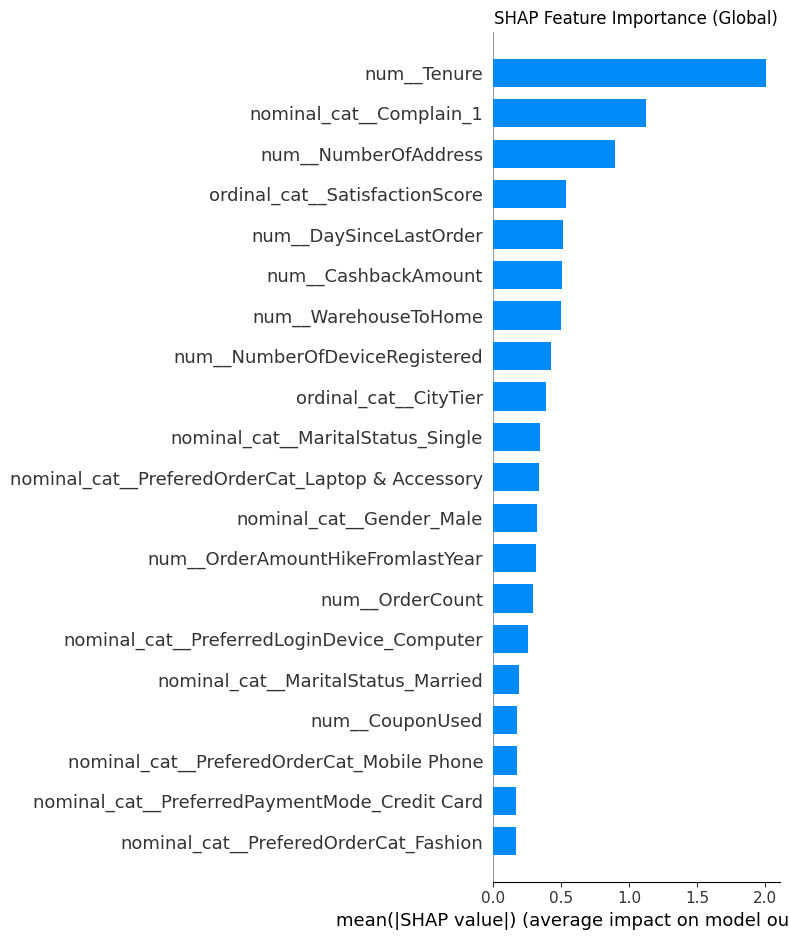

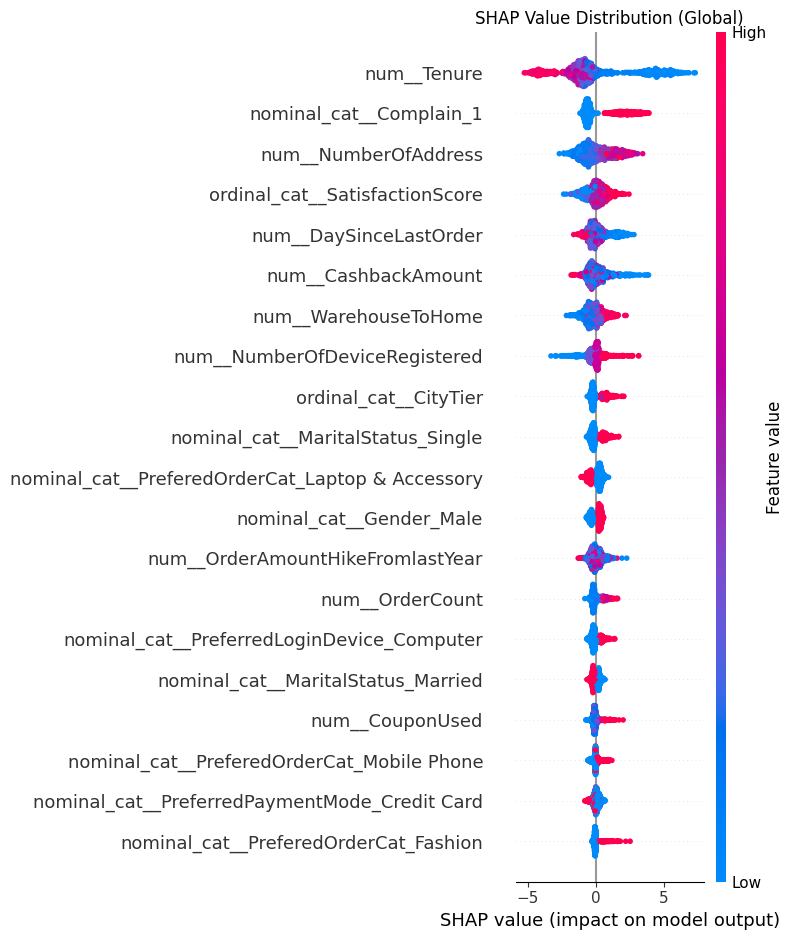

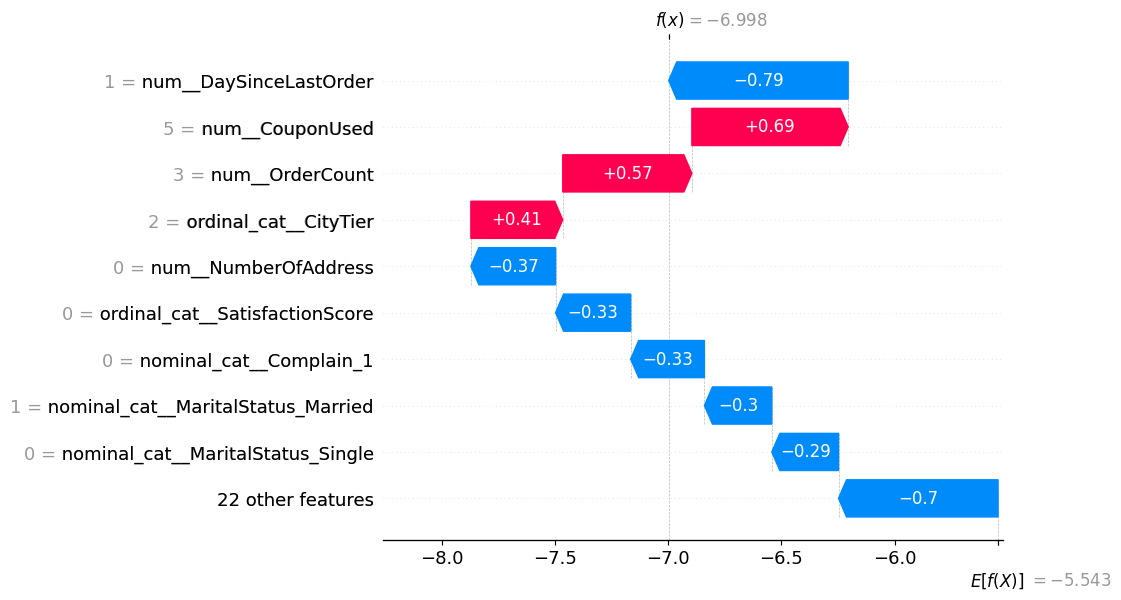

In [ ]:
import shap

# --- 2. Feature Importance & SHAP Analysis ---
print("\n--- Feature Importance & SHAP Analysis ---")

# Get feature names from preprocessor
feature_names = preprocessor.get_feature_names_out()

target_n_features = 20

# --- Tree-based models (with feature_importances_) ---
if hasattr(best_model_instance, 'feature_importances_'):
    importances = best_model_instance.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    print(f"Top {target_n_features} Most Important Features (Model-based):")
    print(feature_importance_df.head(target_n_features).to_string(index=False))

# --- SHAP Analysis ---
print("\n--- SHAP Value Analysis ---")

# Use a sample of the test set for SHAP (to save time & memory)
# X_sample = X_test_processed[:200]
X_sample = X_test_processed.copy()

# Initialize SHAP explainer
try:
    explainer = shap.Explainer(best_model_instance, X_sample, feature_names=feature_names)
    shap_values = explainer(X_sample)

    # SHAP summary plot (bar plot for global importance)
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type="bar", show=False)
    plt.title("SHAP Feature Importance (Global)")
    plt.tight_layout()
    plt.show()

    # SHAP beeswarm plot (distribution of feature impacts)
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)
    plt.title("SHAP Value Distribution (Global)")
    plt.tight_layout()
    plt.show()

    # Optional: visualize a single prediction
    shap.plots.waterfall(shap_values[0])

except Exception as e:
    print(f"SHAP analysis failed: {e}")

# --- Continue with Reduced Feature Training as in your original code ---


The charts present two different methods for determining feature importance in a churn prediction model. The first is a SHAP (SHapley Additive exPlanations) summary plot, and the second is a more traditional feature importance ranking. Both provide insights into which variables have the most impact on the model's output.

---

### SHAP Feature Importance Analysis

The SHAP plot ranks features by their average impact on the model's output magnitude. A longer bar indicates a more significant influence on predicting churn.

1.  **Tenure** is the most impactful feature, having the greatest influence on the model's churn predictions. This suggests that the length of time a customer has been with the company is a primary driver of churn.
2.  **Complaint_1** (having a complaint) is the second most important feature, indicating that whether or not a customer has complained has a strong influence on the model's prediction.
3.  **NumberOfAddress** and **SatisfactionScore** are also highly influential features, ranking third and fourth respectively.

---

### Top 20 Most Important Features

This list provides a ranked order of feature importance based on a different methodology, likely from a tree-based model. While the exact values differ, the top features are generally consistent.

1.  **Tenure** is again ranked as the most important feature.
2.  **PreferredOrderCat_Grocery** is ranked as the second most important feature, highlighting that customers who prefer ordering groceries are significantly different from others in terms of churn.
3.  **PreferredOrderCat_Laptop & Accessory** also ranks highly, indicating this category has a notable impact on the model's predictions.

---

### Key Takeaways

* **Tenure is the single most important factor** for predicting churn, according to both analyses. This reinforces that customer loyalty, as measured by tenure, is a critical variable.
* **Customer behavior** such as having a complaint, the number of addresses they have, and their preferred order category (like groceries or laptops) are also strong predictors of churn.
* **Satisfaction Score** is a moderately important feature in the SHAP analysis, but it ranks lower in the second list. This difference may be due to the different methods used, but it still confirms that satisfaction plays a role in churn.
* The analyses collectively indicate that the most significant predictors of churn are **Tenure**, followed by **Complaints**, and then **Customer demographics and behavior**.

# 6. Conclusion & Recommendations

## 6.1. 📈 Conclusions
* Churn is highly concentrated among **new, unmarried customers, and the most dissatisfied customers** (those with a satisfaction score of 5).
* **Customer support quality, effective complaint resolution**, and personalized engagement incentives like **cashback and coupons** are key levers for churn reduction.
* Retention strategies should be **segmented** not only by tenure, satisfaction, and activity level but also by **marital status, city tier, and preferred product category** to address the highest-risk groups.

## ✅ 6.2. Business Recommendations
### 1. Onboarding & Early Retention
* Create a **"first 3 months" program** with discounts, loyalty points, or personalized offers, specifically targeting **new customers with a short tenure**.
* Send reactivation nudges if **DaySinceLastOrder > median (≈2–3 days)**.

### 2. Customer Support & Complaints
* Implement a **24-hour SLA** for complaint resolution, as customers who complain are the highest churn risk.
* Provide compensation (e.g., coupons, cashback) after service failures, particularly for those in high-risk categories like **Mobile Phone buyers**.

### 3. Satisfaction Monitoring
* Run post-purchase **satisfaction/NPS surveys**.
* **Target customers with high satisfaction scores (e.g., 4 or 5)** with immediate recovery campaigns, as these are your most dissatisfied customers and highest churn risk.

### 4. Cashback & Loyalty Programs
* Expand cashback or loyalty tiers for **at-risk customers**, particularly those with a lower CashbackAmount.
* Reward repeat purchases through **points-based loyalty programs** to encourage engagement and increase tenure.

### 5. Behavior-Based Retention
* Trigger reactivation offers if customers become inactive.
* Offer personalized discounts for volatile segments like **Fashion or Mobile Phone buyers** and avoid relying on a one-size-fits-all approach.
* **Review payment methods**: Given the high churn rate for "Cash on Delivery," consider incentives to encourage a shift to other payment modes like UPI or credit/debit cards.

### 6. Segmentation & Personalization
* Focus on the **Single + Short Tenure + High Dissatisfaction** (Satisfaction Score 5) demographic as the **highest-risk churn cluster**.
* Customize campaigns by **City Tier** (e.g., Tier-2/3 may be more price-sensitive and respond better to direct discounts, while Tier-1 customers might value faster delivery or premium support).
* Target users who registered more devices with personalized offers to increase their commitment to a single platform.

## ⚡ 6.3. Business Impact

### 6.3.1. Impactful Simulation

* Following the acceptable churn rate `5-10%` and acquiring new customers potentially costs **5–25x more** than retaining existing ones

**Simulation Increase Average Tenure by `2`**
* Predicted Reduced Churn `7.55%` to `9.15%` with potential reduced cost to `445` to `2245` cost retention unit.
![](./assets/tenure_increase_10.png)

-------

**Simulation Increase Resolved Complain `31%`**
* Predicted Reduced Churn `6.84%` to `9.86%` with potential reduced cost to `385` to `1925` cost retention unit.
![](./assets/complain_decrease_10.png)

-------

**Simulation Combination of Increase Average Tenure by `2` and Increase Resolved Complain `31%`**
* Predicted Reduced Churn `12.26%` to `4.44%` with potential reduced cost to `710` to `3510` cost retention unit.
![](./assets/tenure_complain_5.png)

-------

* Reducing churn from **16% → 10% monthly** can significantly improve retention.
* Since acquiring new customers costs **5–25x more** than retaining existing ones, these targeted strategies provide a substantial **ROI**, focusing resources on the most impactful retention levers.